## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


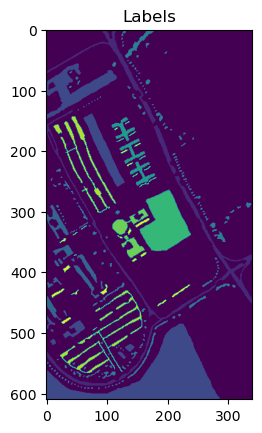

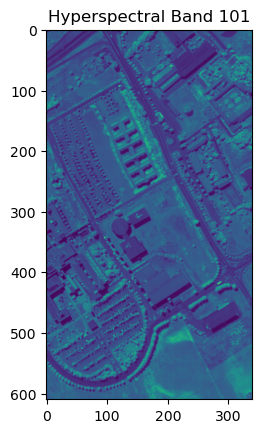

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 20 train


All datasets saved to the 'indices' folder.
(180, 5, 5, 103)
(45, 5, 5, 103)
(42551, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1151, PSNR: 9.3894


	 Training Batch [200/535], Loss: 0.0600, PSNR: 10.4900


	 Training Batch [400/535], Loss: 0.0268, PSNR: 13.9504


Epoch [1/50] Training Loss: 0.0533, PSNR: 11.4032
	[Val]   Batch [1/134] Loss: 0.0186, PSNR: 15.5000
	[Val]   Batch [10/134] Loss: 0.0163, PSNR: 17.8709
	[Val]   Batch [20/134] Loss: 0.0175, PSNR: 15.6710
	[Val]   Batch [30/134] Loss: 0.0190, PSNR: 15.1349
	[Val]   Batch [40/134] Loss: 0.0173, PSNR: 14.1667
	[Val]   Batch [50/134] Loss: 0.0184, PSNR: 15.3338
	[Val]   Batch [60/134] Loss: 0.0167, PSNR: 15.9837


	[Val]   Batch [70/134] Loss: 0.0158, PSNR: 16.1870
	[Val]   Batch [80/134] Loss: 0.0154, PSNR: 16.1808
	[Val]   Batch [90/134] Loss: 0.0162, PSNR: 16.1714
	[Val]   Batch [100/134] Loss: 0.0183, PSNR: 15.5850
	[Val]   Batch [110/134] Loss: 0.0187, PSNR: 14.0972
	[Val]   Batch [120/134] Loss: 0.0153, PSNR: 15.2432
	[Val]   Batch [130/134] Loss: 0.0169, PSNR: 13.2688
Epoch [1/50] Validation Loss: 0.0176, PSNR: 15.5280

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0174, PSNR: 15.5719


	 Training Batch [200/535], Loss: 0.0111, PSNR: 16.3736


	 Training Batch [400/535], Loss: 0.0082, PSNR: 18.8662


Epoch [2/50] Training Loss: 0.0115, PSNR: 17.4963
	[Val]   Batch [1/134] Loss: 0.0087, PSNR: 18.8117
	[Val]   Batch [10/134] Loss: 0.0069, PSNR: 21.5880
	[Val]   Batch [20/134] Loss: 0.0075, PSNR: 19.3513
	[Val]   Batch [30/134] Loss: 0.0086, PSNR: 18.6051
	[Val]   Batch [40/134] Loss: 0.0077, PSNR: 17.6762
	[Val]   Batch [50/134] Loss: 0.0080, PSNR: 18.9282
	[Val]   Batch [60/134] Loss: 0.0069, PSNR: 19.7830
	[Val]   Batch [70/134] Loss: 0.0068, PSNR: 19.8654


	[Val]   Batch [80/134] Loss: 0.0065, PSNR: 19.9586
	[Val]   Batch [90/134] Loss: 0.0069, PSNR: 19.8944
	[Val]   Batch [100/134] Loss: 0.0083, PSNR: 19.0464
	[Val]   Batch [110/134] Loss: 0.0078, PSNR: 17.8708
	[Val]   Batch [120/134] Loss: 0.0058, PSNR: 19.4437
	[Val]   Batch [130/134] Loss: 0.0070, PSNR: 17.0804
Epoch [2/50] Validation Loss: 0.0078, PSNR: 19.0749

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0079, PSNR: 19.1280


	 Training Batch [200/535], Loss: 0.0073, PSNR: 18.3747


	 Training Batch [400/535], Loss: 0.0080, PSNR: 19.2590


Epoch [3/50] Training Loss: 0.0068, PSNR: 19.6888
	[Val]   Batch [1/134] Loss: 0.0062, PSNR: 20.2981
	[Val]   Batch [10/134] Loss: 0.0049, PSNR: 23.1412
	[Val]   Batch [20/134] Loss: 0.0052, PSNR: 20.9145
	[Val]   Batch [30/134] Loss: 0.0059, PSNR: 20.1935
	[Val]   Batch [40/134] Loss: 0.0055, PSNR: 19.1688
	[Val]   Batch [50/134] Loss: 0.0055, PSNR: 20.5554
	[Val]   Batch [60/134] Loss: 0.0048, PSNR: 21.4213


	[Val]   Batch [70/134] Loss: 0.0047, PSNR: 21.4135
	[Val]   Batch [80/134] Loss: 0.0045, PSNR: 21.5724
	[Val]   Batch [90/134] Loss: 0.0048, PSNR: 21.4760
	[Val]   Batch [100/134] Loss: 0.0058, PSNR: 20.5620
	[Val]   Batch [110/134] Loss: 0.0053, PSNR: 19.5749
	[Val]   Batch [120/134] Loss: 0.0038, PSNR: 21.3393
	[Val]   Batch [130/134] Loss: 0.0048, PSNR: 18.7617
Epoch [3/50] Validation Loss: 0.0055, PSNR: 20.6061

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0055, PSNR: 20.6106


	 Training Batch [200/535], Loss: 0.0046, PSNR: 19.8492


	 Training Batch [400/535], Loss: 0.0038, PSNR: 22.4515


Epoch [4/50] Training Loss: 0.0050, PSNR: 21.0059
	[Val]   Batch [1/134] Loss: 0.0043, PSNR: 21.8618
	[Val]   Batch [10/134] Loss: 0.0034, PSNR: 24.6343
	[Val]   Batch [20/134] Loss: 0.0035, PSNR: 22.6117
	[Val]   Batch [30/134] Loss: 0.0040, PSNR: 21.9023
	[Val]   Batch [40/134] Loss: 0.0037, PSNR: 20.8698
	[Val]   Batch [50/134] Loss: 0.0036, PSNR: 22.3925
	[Val]   Batch [60/134] Loss: 0.0034, PSNR: 22.8795
	[Val]   Batch [70/134] Loss: 0.0034, PSNR: 22.9051


	[Val]   Batch [80/134] Loss: 0.0031, PSNR: 23.0997
	[Val]   Batch [90/134] Loss: 0.0033, PSNR: 23.0608
	[Val]   Batch [100/134] Loss: 0.0040, PSNR: 22.1587
	[Val]   Batch [110/134] Loss: 0.0035, PSNR: 21.3971
	[Val]   Batch [120/134] Loss: 0.0025, PSNR: 23.0505
	[Val]   Batch [130/134] Loss: 0.0031, PSNR: 20.6141
Epoch [4/50] Validation Loss: 0.0038, PSNR: 22.1925

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0031, PSNR: 20.7536


	 Training Batch [200/535], Loss: 0.0038, PSNR: 22.3528


	 Training Batch [400/535], Loss: 0.0027, PSNR: 23.9524


Epoch [5/50] Training Loss: 0.0036, PSNR: 22.4141
	[Val]   Batch [1/134] Loss: 0.0031, PSNR: 23.2359
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 26.0021
	[Val]   Batch [20/134] Loss: 0.0024, PSNR: 24.2227
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.5172
	[Val]   Batch [40/134] Loss: 0.0025, PSNR: 22.5338
	[Val]   Batch [50/134] Loss: 0.0024, PSNR: 24.1605


	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0894
	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.2313
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.4121
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.3634
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.6420
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.2491
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.6394
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.2212
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.6299

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0029, PSNR: 21.4351


	 Training Batch [200/535], Loss: 0.0037, PSNR: 22.3917


	 Training Batch [400/535], Loss: 0.0025, PSNR: 24.1134


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.4802
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 23.9745
	[Val]   Batch [10/134] Loss: 0.0021, PSNR: 26.7866
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.2056
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.4598
	[Val]   Batch [40/134] Loss: 0.0020, PSNR: 23.5122
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.1362
	[Val]   Batch [60/134] Loss: 0.0022, PSNR: 24.8143


	[Val]   Batch [70/134] Loss: 0.0021, PSNR: 25.0155
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.1978
	[Val]   Batch [90/134] Loss: 0.0021, PSNR: 25.0965
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5049
	[Val]   Batch [110/134] Loss: 0.0018, PSNR: 24.3679
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.6358
	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.1420
Epoch [6/50] Validation Loss: 0.0023, PSNR: 24.4681

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 24.1175


	 Training Batch [200/535], Loss: 0.0020, PSNR: 24.0992


	 Training Batch [400/535], Loss: 0.0020, PSNR: 24.6331


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.0999
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.5441
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.3928
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0044
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1842
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.2969
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.9172
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3912


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6175
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8226
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.6643
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1682
	[Val]   Batch [110/134] Loss: 0.0014, PSNR: 25.2267
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.4442
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.8356
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1320

LOG: Epoch [8/50]
	 Training Batch [1/535], Loss: 0.0018, PSNR: 25.6981


	 Training Batch [200/535], Loss: 0.0015, PSNR: 24.9466


	 Training Batch [400/535], Loss: 0.0021, PSNR: 25.1063


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.5823
	[Val]   Batch [1/134] Loss: 0.0021, PSNR: 24.9581
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 27.8664
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.6221
	[Val]   Batch [30/134] Loss: 0.0017, PSNR: 25.7304
	[Val]   Batch [40/134] Loss: 0.0015, PSNR: 24.9239
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.4808
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.8364


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.0855
	[Val]   Batch [80/134] Loss: 0.0015, PSNR: 26.3401
	[Val]   Batch [90/134] Loss: 0.0017, PSNR: 26.0947
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.6742
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.8901
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.0948


	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.3897
Epoch [8/50] Validation Loss: 0.0018, PSNR: 25.6488

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.0055


	 Training Batch [200/535], Loss: 0.0018, PSNR: 24.3192


	 Training Batch [400/535], Loss: 0.0026, PSNR: 23.9704


Epoch [9/50] Training Loss: 0.0021, PSNR: 24.9111
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.2817
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.1947
	[Val]   Batch [20/134] Loss: 0.0013, PSNR: 27.0987
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.1549
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.3713
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.8789
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.1729


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4203
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.6784
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.4336
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.0482
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.3941
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5535
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.8095


Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.0331

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 26.4631


	 Training Batch [200/535], Loss: 0.0025, PSNR: 26.0930


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.4259


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.1857
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.5568
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.4881
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.5092
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.5073
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.7553
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2316
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.4624


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7073
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 27.0294
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.7407
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.3785
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.8354
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 27.9555
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.1479
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.3700

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.5974


	 Training Batch [200/535], Loss: 0.0023, PSNR: 24.6253


	 Training Batch [400/535], Loss: 0.0021, PSNR: 24.9346


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4319
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.7047
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6765
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.7370
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.7062
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 25.9901
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.4194
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.6706


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.8998
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.2299
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.9145
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.5927
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.0543
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2095
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.3302
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.5748

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 25.7479


	 Training Batch [200/535], Loss: 0.0041, PSNR: 23.5845


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.2781


Epoch [12/50] Training Loss: 0.0018, PSNR: 25.6468
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.9901
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.9605
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1834
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0869
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.4049
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7724
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 26.9776


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.1903
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.5762
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.2210
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9098
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.5123
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.6095
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.7278
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9212

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0020, PSNR: 25.0844


	 Training Batch [200/535], Loss: 0.0028, PSNR: 25.4693


	 Training Batch [400/535], Loss: 0.0011, PSNR: 26.2338


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8110
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.1420
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0838
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3812
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2491
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.5984
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9174
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1556


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3645
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.7397
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3844
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.0760
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.6666
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7279
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.9059
Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.0890

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.6597


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.7705


	 Training Batch [400/535], Loss: 0.0016, PSNR: 25.9484


Epoch [14/50] Training Loss: 0.0016, PSNR: 26.0352
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.3153
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.2844
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.6711
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.4910
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.8628
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 28.1580
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4019


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.5786
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 27.9587
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.6039
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.2915
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9655
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0268
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.1645


Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.3255

LOG: Epoch [15/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9802


	 Training Batch [200/535], Loss: 0.0021, PSNR: 26.7429


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.7773


Epoch [15/50] Training Loss: 0.0016, PSNR: 26.1353
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5345
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4856
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.9807
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.7582
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.1262
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.3951
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.6428


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.8404
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2406
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8372
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.5488
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.2389
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.2834
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4143
Epoch [15/50] Validation Loss: 0.0011, PSNR: 27.5689

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 24.8143


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.3429


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.1416


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3295
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7290
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.6488
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.2499
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.9684
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.3549
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5686


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.8663
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.0520
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4462
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0567
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.7421
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.4080
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.4564


	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6327
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7746

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 26.4654


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.8928


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8664


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.4847
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9026
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7840
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.4609
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.1544
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5311
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7302
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.0647


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.2429
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6194
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2349
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.9132
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5299
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5559
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.7738
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9363

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0015, PSNR: 26.4358


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3404


	 Training Batch [400/535], Loss: 0.0017, PSNR: 25.8195


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6166
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.1685
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.9892
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.8366
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.4824
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8377
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0641
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.4305


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.5648
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9035
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5318
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.2473
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8001
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7842
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1126
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.2326

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 27.0696


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.5660


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.4297


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.8481
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.3292
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1018
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0436
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.6807
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0234
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.2093
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6720


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.8683
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.0960
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.7113
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.4781
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8620
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8586
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.2573
Epoch [19/50] Validation Loss: 0.0009, PSNR: 28.4076

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 25.9540


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.3434


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.3156


Epoch [20/50] Training Loss: 0.0013, PSNR: 27.0275
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.6343
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2882
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.3701
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 29.0078
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.2678
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.4672


	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 28.9754
	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.1325
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.3693
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.0307
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7494
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.0461
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.9948
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.5500
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.6733

LOG: Epoch [21/50]


	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2439


	 Training Batch [200/535], Loss: 0.0018, PSNR: 27.4322


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.5787


Epoch [21/50] Training Loss: 0.0012, PSNR: 27.2060
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9221
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.5363
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7353
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.3751
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6053
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.8422
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3318


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.5241
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.7042
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.4056
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1226
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.3133
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2494
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.8711
Epoch [21/50] Validation Loss: 0.0008, PSNR: 29.0032

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.6841


	 Training Batch [200/535], Loss: 0.0010, PSNR: 27.8828


	 Training Batch [400/535], Loss: 0.0011, PSNR: 29.6393


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.4239
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.1826
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7058
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.8768
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.6256
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.8088
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.0201
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.5534


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7998
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8940
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.6402
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.4003
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4364
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3139
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0202
Epoch [22/50] Validation Loss: 0.0008, PSNR: 29.2077

LOG: Epoch [23/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 28.7819


	 Training Batch [200/535], Loss: 0.0017, PSNR: 27.1096


	 Training Batch [400/535], Loss: 0.0009, PSNR: 28.6590


Epoch [23/50] Training Loss: 0.0011, PSNR: 27.5889
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.5664
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.0168
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3250
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.0820
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 29.1219
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.4598
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9240


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.1702
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.2637
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 30.0470
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7744
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.7420
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.5838
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.3688
Epoch [23/50] Validation Loss: 0.0007, PSNR: 29.5708

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.2987


	 Training Batch [200/535], Loss: 0.0010, PSNR: 26.4551


	 Training Batch [400/535], Loss: 0.0008, PSNR: 26.7957


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.7845
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8290
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.2086
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5703
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3754
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.3116
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7043
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1122


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4425
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4539
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.3302
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0413
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8723
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7315


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5476
Epoch [24/50] Validation Loss: 0.0007, PSNR: 29.8149

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6881


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.0425


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5351


Epoch [25/50] Training Loss: 0.0010, PSNR: 27.8992
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.8251
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.2374
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3406
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.2533
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.1454
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5153
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.0746


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4034
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.3429
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.2635
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 30.0229
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.6110
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.5425
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2914
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.7343

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.6058


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.4004


	 Training Batch [400/535], Loss: 0.0013, PSNR: 28.8556


Epoch [26/50] Training Loss: 0.0010, PSNR: 28.0771
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.2295
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.5107
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7324
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.6729
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4407
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8885
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3425


	[Val]   Batch [70/134] Loss: 0.0005, PSNR: 30.7762
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6528
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.6018
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3643
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9040
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7506
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6381
Epoch [26/50] Validation Loss: 0.0006, PSNR: 30.0813
Early stopping triggered at epoch 26. No improvement for 3 epochs.


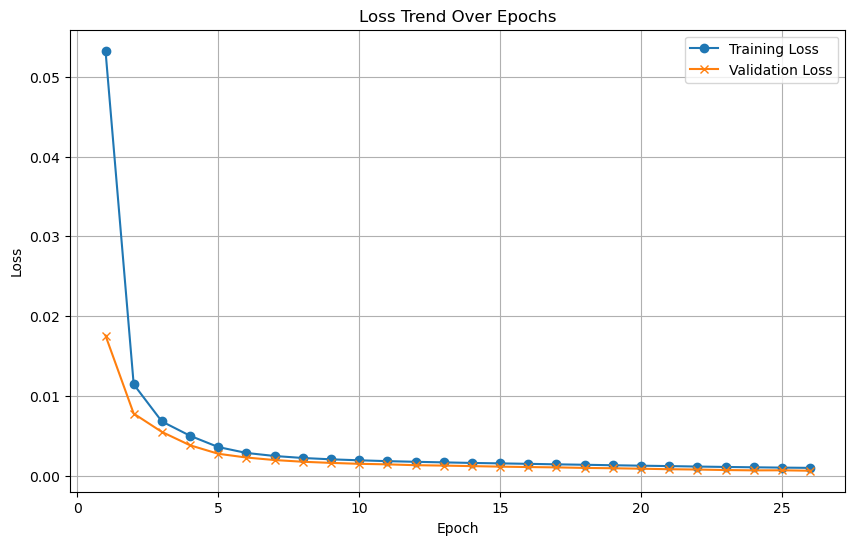

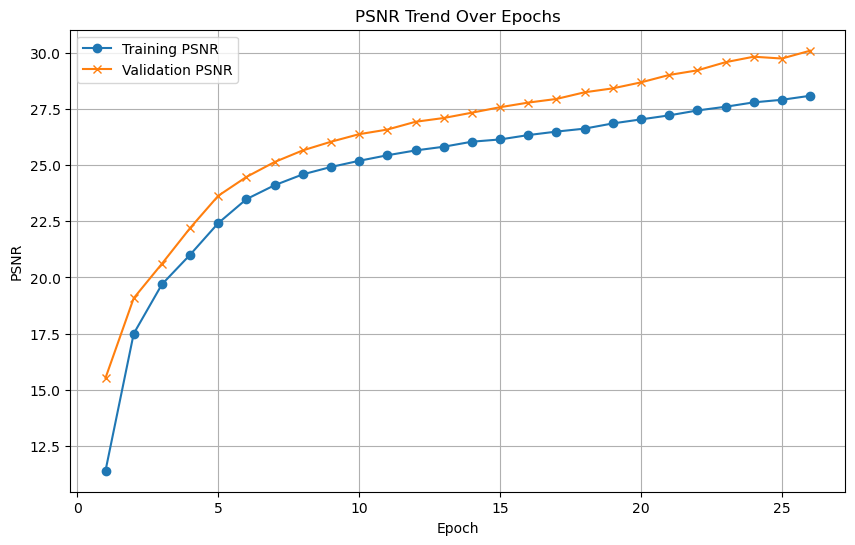

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/167 for test dataset.


    Processed batch 101/167 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.2360
    Validation Batch [1/1], Loss: 2.2002
Validation Loss: 2.2002, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2002. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1913
    Validation Batch [1/1], Loss: 2.2000
Validation Loss: 2.2000, Validation Accuracy: 11.11%
Validation loss improved from 2.2002 to 2.2000. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.1562
    Validation Batch [1/1], Loss: 2.1998
Validation Loss: 2.1998, Validation Accuracy: 11.11%
Validation loss improved from 2.2000 to 2.1998. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.1298
    Validation Batch [1/1], Loss: 2.1997
Validation Loss: 2.1997, Validation Accuracy: 11.11%
Validation loss improved from 2.1998 to 2.1997. Saving model...

LOG: Epoch [5/1000

Epoch [20/1000] completed, Average Training Loss: 1.8555
    Validation Batch [1/1], Loss: 2.1876
Validation Loss: 2.1876, Validation Accuracy: 11.11%
Validation loss improved from 2.1901 to 2.1876. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 1.8364
    Validation Batch [1/1], Loss: 2.1843
Validation Loss: 2.1843, Validation Accuracy: 11.11%
Validation loss improved from 2.1876 to 2.1843. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.8174
    Validation Batch [1/1], Loss: 2.1803
Validation Loss: 2.1803, Validation Accuracy: 11.11%
Validation loss improved from 2.1843 to 2.1803. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.8043
    Validation Batch [1/1], Loss: 2.1756
Validation Loss: 2.1756, Validation Accuracy: 22.22%
Validation loss improved from 2.1803 to 2.1756. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [2

Epoch [48/1000] completed, Average Training Loss: 1.6005
    Validation Batch [1/1], Loss: 1.7751
Validation Loss: 1.7751, Validation Accuracy: 53.33%
Validation loss improved from 1.7962 to 1.7751. Saving model...

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.5641
    Validation Batch [1/1], Loss: 1.7546
Validation Loss: 1.7546, Validation Accuracy: 53.33%
Validation loss improved from 1.7751 to 1.7546. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.5774
    Validation Batch [1/1], Loss: 1.7349
Validation Loss: 1.7349, Validation Accuracy: 53.33%
Validation loss improved from 1.7546 to 1.7349. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.5786
    Validation Batch [1/1], Loss: 1.7161
Validation Loss: 1.7161, Validation Accuracy: 57.78%
Validation loss improved from 1.7349 to 1.7161. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [5


LOG: Epoch [78/1000] - Training
Epoch [78/1000] completed, Average Training Loss: 1.3884
    Validation Batch [1/1], Loss: 1.4152
Validation Loss: 1.4152, Validation Accuracy: 68.89%
Validation loss improved from 1.4240 to 1.4152. Saving model...

LOG: Epoch [79/1000] - Training
Epoch [79/1000] completed, Average Training Loss: 1.3866
    Validation Batch [1/1], Loss: 1.4060
Validation Loss: 1.4060, Validation Accuracy: 68.89%
Validation loss improved from 1.4152 to 1.4060. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.3607
    Validation Batch [1/1], Loss: 1.4009
Validation Loss: 1.4009, Validation Accuracy: 68.89%
Validation loss improved from 1.4060 to 1.4009. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.3429
    Validation Batch [1/1], Loss: 1.3960
Validation Loss: 1.3960, Validation Accuracy: 68.89%
Validation loss improved from 1.4009 to 1.3960. Saving model...

LOG: Ep

    Validation Batch [1/1], Loss: 1.2375
Validation Loss: 1.2375, Validation Accuracy: 73.33%
Validation loss improved from 1.2446 to 1.2375. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 1.1749
    Validation Batch [1/1], Loss: 1.2336
Validation Loss: 1.2336, Validation Accuracy: 73.33%
Validation loss improved from 1.2375 to 1.2336. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000] completed, Average Training Loss: 1.1443
    Validation Batch [1/1], Loss: 1.2263
Validation Loss: 1.2263, Validation Accuracy: 73.33%
Validation loss improved from 1.2336 to 1.2263. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.1224
    Validation Batch [1/1], Loss: 1.2212
Validation Loss: 1.2212, Validation Accuracy: 75.56%
Validation loss improved from 1.2263 to 1.2212. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.1235


    Validation Batch [1/1], Loss: 0.9699
Validation Loss: 0.9699, Validation Accuracy: 86.67%
Validation loss improved from 0.9994 to 0.9699. Saving model...

LOG: Epoch [139/1000] - Training
Epoch [139/1000] completed, Average Training Loss: 0.8638
    Validation Batch [1/1], Loss: 0.9730
Validation Loss: 0.9730, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.8956
    Validation Batch [1/1], Loss: 0.9984
Validation Loss: 0.9984, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.8718
    Validation Batch [1/1], Loss: 0.9757
Validation Loss: 0.9757, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.8874
    Validation Batch [1/1], Loss: 0.9347
Vali

    Validation Batch [1/1], Loss: 0.8078
Validation Loss: 0.8078, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.6881
    Validation Batch [1/1], Loss: 0.7795
Validation Loss: 0.7795, Validation Accuracy: 91.11%
Validation loss improved from 0.7878 to 0.7795. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.6641
    Validation Batch [1/1], Loss: 0.7395
Validation Loss: 0.7395, Validation Accuracy: 95.56%
Validation loss improved from 0.7795 to 0.7395. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 0.6426
    Validation Batch [1/1], Loss: 0.7657
Validation Loss: 0.7657, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 0.6638
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.6091
Validation Loss: 0.6091, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 0.4773
    Validation Batch [1/1], Loss: 0.5940
Validation Loss: 0.5940, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 0.4617
    Validation Batch [1/1], Loss: 0.5811
Validation Loss: 0.5811, Validation Accuracy: 97.78%
Validation loss improved from 0.5911 to 0.5811. Saving model...

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.4960
    Validation Batch [1/1], Loss: 0.5599
Validation Loss: 0.5599, Validation Accuracy: 97.78%
Validation loss improved from 0.5811 to 0.5599. Saving model...

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.4638
    Validation Batch [1/1], Lo

Epoch [226/1000] completed, Average Training Loss: 0.3363
    Validation Batch [1/1], Loss: 0.4391
Validation Loss: 0.4391, Validation Accuracy: 97.78%
Validation loss improved from 0.4485 to 0.4391. Saving model...

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.3465
    Validation Batch [1/1], Loss: 0.4508
Validation Loss: 0.4508, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.3622
    Validation Batch [1/1], Loss: 0.5086
Validation Loss: 0.5086, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.3429
    Validation Batch [1/1], Loss: 0.4598
Validation Loss: 0.4598, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training 

Epoch [256/1000] completed, Average Training Loss: 0.2687
    Validation Batch [1/1], Loss: 0.3688
Validation Loss: 0.3688, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.2475
    Validation Batch [1/1], Loss: 0.3671
Validation Loss: 0.3671, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.2451
    Validation Batch [1/1], Loss: 0.3695
Validation Loss: 0.3695, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.2496
    Validation Batch [1/1], Loss: 0.3386
Validation Loss: 0.3386, Validation Accuracy: 97.78%
Validation loss improved from 0.3469 to 0.3386. Saving model...

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training 

Epoch [284/1000] completed, Average Training Loss: 0.2095
    Validation Batch [1/1], Loss: 0.3014
Validation Loss: 0.3014, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.2045
    Validation Batch [1/1], Loss: 0.2914
Validation Loss: 0.2914, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.1671
    Validation Batch [1/1], Loss: 0.2922
Validation Loss: 0.2922, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.1828
    Validation Batch [1/1], Loss: 0.3409
Validation Loss: 0.3409, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.1983
  

Epoch [312/1000] completed, Average Training Loss: 0.1590
    Validation Batch [1/1], Loss: 0.2484
Validation Loss: 0.2484, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.1574
    Validation Batch [1/1], Loss: 0.2473
Validation Loss: 0.2473, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.1544
    Validation Batch [1/1], Loss: 0.2365
Validation Loss: 0.2365, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.1694
    Validation Batch [1/1], Loss: 0.2245
Validation Loss: 0.2245, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.1396
  

Epoch [341/1000] completed, Average Training Loss: 0.1269
    Validation Batch [1/1], Loss: 0.2026
Validation Loss: 0.2026, Validation Accuracy: 100.00%
Validation loss improved from 0.2119 to 0.2026. Saving model...

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.1129
    Validation Batch [1/1], Loss: 0.1926
Validation Loss: 0.1926, Validation Accuracy: 97.78%
Validation loss improved from 0.2026 to 0.1926. Saving model...

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.1263
    Validation Batch [1/1], Loss: 0.2025
Validation Loss: 0.2025, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.1206
    Validation Batch [1/1], Loss: 0.2095
Validation Loss: 0.2095, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, A

Epoch [371/1000] completed, Average Training Loss: 0.0904
    Validation Batch [1/1], Loss: 0.2141
Validation Loss: 0.2141, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.2028
Validation Loss: 0.2028, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.1052
    Validation Batch [1/1], Loss: 0.1851
Validation Loss: 0.1851, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.0982
    Validation Batch [1/1], Loss: 0.1774
Validation Loss: 0.1774, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [375/1000] - Training
Epoch [375/1000] completed, Average Training Loss: 0.0946
  

    Validation Batch [1/1], Loss: 0.1485
Validation Loss: 0.1485, Validation Accuracy: 97.78%
Validation loss improved from 0.1531 to 0.1485. Saving model...

LOG: Epoch [402/1000] - Training
Epoch [402/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.1892
Validation Loss: 0.1892, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [403/1000] - Training
Epoch [403/1000] completed, Average Training Loss: 0.0814
    Validation Batch [1/1], Loss: 0.2336
Validation Loss: 0.2336, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [404/1000] - Training
Epoch [404/1000] completed, Average Training Loss: 0.0745
    Validation Batch [1/1], Loss: 0.2170
Validation Loss: 0.2170, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0730
    Validation Batch [1/1], Loss: 0.1935
Vali

Epoch [432/1000] completed, Average Training Loss: 0.0625
    Validation Batch [1/1], Loss: 0.1716
Validation Loss: 0.1716, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [433/1000] - Training
Epoch [433/1000] completed, Average Training Loss: 0.0704
    Validation Batch [1/1], Loss: 0.2094
Validation Loss: 0.2094, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [434/1000] - Training
Epoch [434/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.1462
Validation Loss: 0.1462, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [435/1000] - Training
Epoch [435/1000] completed, Average Training Loss: 0.0671
    Validation Batch [1/1], Loss: 0.1317
Validation Loss: 0.1317, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.0613

Epoch [462/1000] completed, Average Training Loss: 0.0615
    Validation Batch [1/1], Loss: 0.1235
Validation Loss: 0.1235, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [463/1000] - Training
Epoch [463/1000] completed, Average Training Loss: 0.0569
    Validation Batch [1/1], Loss: 0.1440
Validation Loss: 0.1440, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [464/1000] - Training
Epoch [464/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.2034
Validation Loss: 0.2034, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [465/1000] - Training
Epoch [465/1000] completed, Average Training Loss: 0.0522
    Validation Batch [1/1], Loss: 0.2451
Validation Loss: 0.2451, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0589
  

Epoch [493/1000] completed, Average Training Loss: 0.0418
    Validation Batch [1/1], Loss: 0.1251
Validation Loss: 0.1251, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0512
    Validation Batch [1/1], Loss: 0.1155
Validation Loss: 0.1155, Validation Accuracy: 97.78%
Validation loss improved from 0.1200 to 0.1155. Saving model...

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.0448
    Validation Batch [1/1], Loss: 0.1239
Validation Loss: 0.1239, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0488
    Validation Batch [1/1], Loss: 0.1639
Validation Loss: 0.1639, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training

Epoch [523/1000] completed, Average Training Loss: 0.0412
    Validation Batch [1/1], Loss: 0.1580
Validation Loss: 0.1580, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0430
    Validation Batch [1/1], Loss: 0.1839
Validation Loss: 0.1839, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.1601
Validation Loss: 0.1601, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.0395
    Validation Batch [1/1], Loss: 0.1255
Validation Loss: 0.1255, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.042

Epoch [554/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.1384
Validation Loss: 0.1384, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.0393
    Validation Batch [1/1], Loss: 0.1298
Validation Loss: 0.1298, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.1143
Validation Loss: 0.1143, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [557/1000] - Training
Epoch [557/1000] completed, Average Training Loss: 0.0386
    Validation Batch [1/1], Loss: 0.1124
Validation Loss: 0.1124, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0314
  

Epoch [584/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.1422
Validation Loss: 0.1422, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.1623
Validation Loss: 0.1623, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [586/1000] - Training
Epoch [586/1000] completed, Average Training Loss: 0.0379
    Validation Batch [1/1], Loss: 0.1546
Validation Loss: 0.1546, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [587/1000] - Training
Epoch [587/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.1469
Validation Loss: 0.1469, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [588/1000] - Training
Epoch [588/1000] completed, Average Training Loss: 0.028

    Validation Batch [1/1], Loss: 0.1108
Validation Loss: 0.1108, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [614/1000] - Training
Epoch [614/1000] completed, Average Training Loss: 0.0349
    Validation Batch [1/1], Loss: 0.1135
Validation Loss: 0.1135, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [615/1000] - Training
Epoch [615/1000] completed, Average Training Loss: 0.0255
    Validation Batch [1/1], Loss: 0.1210
Validation Loss: 0.1210, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.1272
Validation Loss: 0.1272, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0357
    Validation Batch [1/1], Loss: 0.1105
Validation Loss

Epoch [644/1000] completed, Average Training Loss: 0.0248
    Validation Batch [1/1], Loss: 0.1018
Validation Loss: 0.1018, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [645/1000] - Training
Epoch [645/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.1039
Validation Loss: 0.1039, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [646/1000] - Training
Epoch [646/1000] completed, Average Training Loss: 0.0282
    Validation Batch [1/1], Loss: 0.1043
Validation Loss: 0.1043, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [647/1000] - Training
Epoch [647/1000] completed, Average Training Loss: 0.0279
    Validation Batch [1/1], Loss: 0.1050
Validation Loss: 0.1050, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [648/1000] - Training
Epoch [648/1000] completed, Average Training Loss: 0.027

Epoch [674/1000] completed, Average Training Loss: 0.0239
    Validation Batch [1/1], Loss: 0.1121
Validation Loss: 0.1121, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [675/1000] - Training
Epoch [675/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.1021
Validation Loss: 0.1021, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [676/1000] - Training
Epoch [676/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.0961
Validation Loss: 0.0961, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [677/1000] - Training
Epoch [677/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.0994
Validation Loss: 0.0994, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [678/1000] - Training
Epoch [678/1000] completed, Average Training Loss: 0.02

Epoch [704/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0826
Validation Loss: 0.0826, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [705/1000] - Training
Epoch [705/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0901
Validation Loss: 0.0901, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [706/1000] - Training
Epoch [706/1000] completed, Average Training Loss: 0.0200
    Validation Batch [1/1], Loss: 0.1131
Validation Loss: 0.1131, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [707/1000] - Training
Epoch [707/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.1524
Validation Loss: 0.1524, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.015

Epoch [731/1000] completed, Average Training Loss: 0.0224
    Validation Batch [1/1], Loss: 0.1653
Validation Loss: 0.1653, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.0199
    Validation Batch [1/1], Loss: 0.1239
Validation Loss: 0.1239, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [733/1000] - Training
Epoch [733/1000] completed, Average Training Loss: 0.0219
    Validation Batch [1/1], Loss: 0.0993
Validation Loss: 0.0993, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [734/1000] - Training
Epoch [734/1000] completed, Average Training Loss: 0.0194
    Validation Batch [1/1], Loss: 0.0898
Validation Loss: 0.0898, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [735/1000] - Training
Epoch [735/1000] completed, Average Training Loss: 0.017

Epoch [762/1000] completed, Average Training Loss: 0.0150
    Validation Batch [1/1], Loss: 0.1117
Validation Loss: 0.1117, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [763/1000] - Training
Epoch [763/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.1057
Validation Loss: 0.1057, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [764/1000] - Training
Epoch [764/1000] completed, Average Training Loss: 0.0189
    Validation Batch [1/1], Loss: 0.1035
Validation Loss: 0.1035, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [765/1000] - Training
Epoch [765/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0982
Validation Loss: 0.0982, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [766/1000] - Training
Epoch [766/1000] completed, Average Training Loss: 0.016

Epoch [791/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.1328
Validation Loss: 0.1328, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [792/1000] - Training
Epoch [792/1000] completed, Average Training Loss: 0.0144
    Validation Batch [1/1], Loss: 0.1176
Validation Loss: 0.1176, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [793/1000] - Training
Epoch [793/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.0947
Validation Loss: 0.0947, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 80/100

LOG: Epoch [794/1000] - Training
Epoch [794/1000] completed, Average Training Loss: 0.0141
    Validation Batch [1/1], Loss: 0.0828
Validation Loss: 0.0828, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [795/1000] - Training
Epoch [795/1000] completed, Average Training Loss: 0.016

Epoch [820/1000] completed, Average Training Loss: 0.0110
    Validation Batch [1/1], Loss: 0.1037
Validation Loss: 0.1037, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [821/1000] - Training
Epoch [821/1000] completed, Average Training Loss: 0.0139
    Validation Batch [1/1], Loss: 0.1076
Validation Loss: 0.1076, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [822/1000] - Training
Epoch [822/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.1030
Validation Loss: 0.1030, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [823/1000] - Training
Epoch [823/1000] completed, Average Training Loss: 0.0148
    Validation Batch [1/1], Loss: 0.1009
Validation Loss: 0.1009, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0169
  

Epoch [850/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0973
Validation Loss: 0.0973, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.1147
Validation Loss: 0.1147, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [852/1000] - Training
Epoch [852/1000] completed, Average Training Loss: 0.0118
    Validation Batch [1/1], Loss: 0.1159
Validation Loss: 0.1159, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [853/1000] - Training
Epoch [853/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.1055
Validation Loss: 0.1055, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [854/1000] - Training
Epoch [854/1000] completed, Average Training Loss: 0.013

    Validation Batch [1/1], Loss: 0.1196
Validation Loss: 0.1196, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [881/1000] - Training
Epoch [881/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.1620
Validation Loss: 0.1620, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [882/1000] - Training
Epoch [882/1000] completed, Average Training Loss: 0.0114
    Validation Batch [1/1], Loss: 0.1892
Validation Loss: 0.1892, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [883/1000] - Training
Epoch [883/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.1218
Validation Loss: 0.1218, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [884/1000] - Training
Epoch [884/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0974
Validation Loss

    Validation Batch [1/1], Loss: 0.0865
Validation Loss: 0.0865, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [911/1000] - Training
Epoch [911/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.0868
Validation Loss: 0.0868, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [912/1000] - Training
Epoch [912/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.0891
Validation Loss: 0.0891, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [913/1000] - Training
Epoch [913/1000] completed, Average Training Loss: 0.0092
    Validation Batch [1/1], Loss: 0.0924
Validation Loss: 0.0924, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [914/1000] - Training
Epoch [914/1000] completed, Average Training Loss: 0.0102
    Validation Batch [1/1], Loss: 0.0970
Validation Loss

Epoch [941/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.1192
Validation Loss: 0.1192, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [942/1000] - Training
Epoch [942/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.1285
Validation Loss: 0.1285, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [943/1000] - Training
Epoch [943/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.1333
Validation Loss: 0.1333, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [944/1000] - Training
Epoch [944/1000] completed, Average Training Loss: 0.0123
    Validation Batch [1/1], Loss: 0.1284
Validation Loss: 0.1284, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [945/1000] - Training
Epoch [945/1000] completed, Average Training Loss: 0.012

    Validation Batch [1/1], Loss: 0.1069
Validation Loss: 0.1069, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [972/1000] - Training
Epoch [972/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.0898
Validation Loss: 0.0898, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [973/1000] - Training
Epoch [973/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.0796
Validation Loss: 0.0796, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [974/1000] - Training
Epoch [974/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.0768
Validation Loss: 0.0768, Validation Accuracy: 97.78%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [975/1000] - Training
Epoch [975/1000] completed, Average Training Loss: 0.0099
    Validation Batch [1/1], Loss: 0.0878
Validation Loss

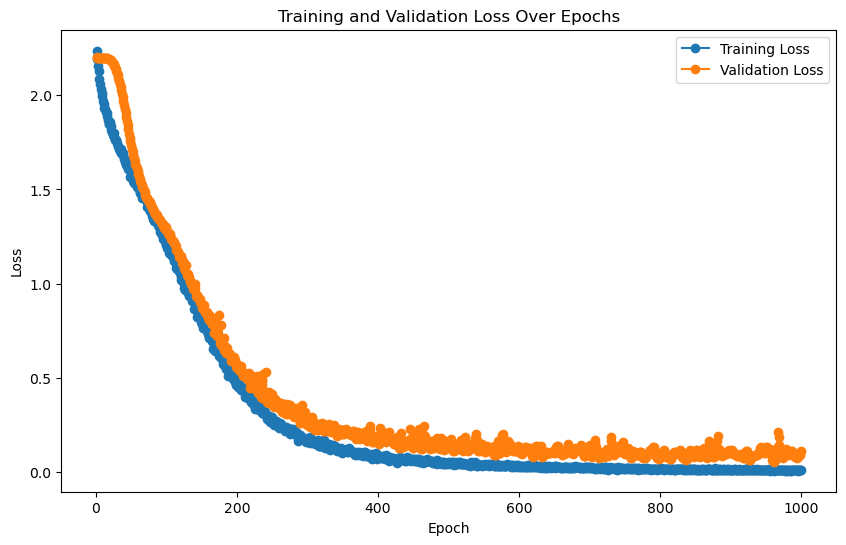

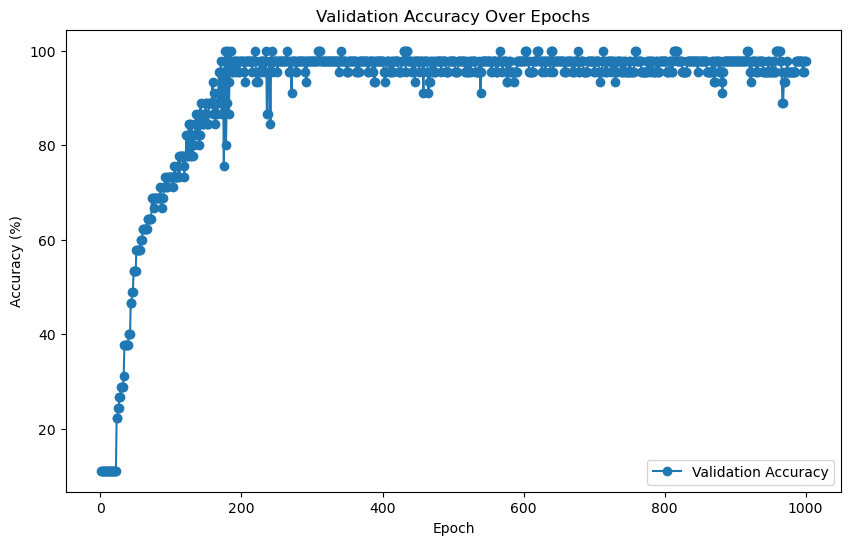


Evaluating on the test set...
    Test Batch [1/167], Loss: 0.1865



Final Test Loss: 0.4504, Test Accuracy: 86.59%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.
  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.


  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.
  Processed batch 90/167 for test dataset.


  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.


  Processed batch 150/167 for test dataset.
  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)

LOG: Training features shape: (180, 64), Training labels shape: (180,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42551, 64), Test labels shape: (42551,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 73.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.60      0.60      0.60         5
           2       0.43      0.60      0.50         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.50      0.20      0.29         5
           6       1.00      0.80      0.89         5
           7       0.50      0.60      0.55         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)
Train reps shape: (180, 64)
Train labels shape: (180,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42551, 64)
Test labels shape: (42551,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1466  |  Val Loss: 2.0057
Validation loss improved from inf to 2.0057.
[Epoch 2/1000] Train Loss: 1.9870  |  Val Loss: 1.8844
Validation loss improved from 2.0057 to 1.8844.
[Epoch 3/1000] Train Loss: 1.8749  |  Val Loss: 1.7890
Validation loss improved from 1.8844 to 1.7890.
[Epoch 4/1000] Train Loss: 1.7750  |  Val Loss: 1.6949
Validation loss improved from 1.7890 to 1.6949.
[Epoch 5/1000] Train Loss: 1.6796  |  Val Loss: 1.6039
Validation loss improved from 1.6949 to 1.6039.
[Epoch 6/1000] Train Loss: 1.5865  |  Val Loss: 1.5155
Validation loss improved from 1.6039 to 1.5155.
[Epoch 7/1000] Train Loss: 1.4984  |  Val Loss: 1.4319
Validation loss improved from 1.5155 to 1.4319.


[Epoch 8/1000] Train Loss: 1.4103  |  Val Loss: 1.3580
Validation loss improved from 1.4319 to 1.3580.
[Epoch 9/1000] Train Loss: 1.3332  |  Val Loss: 1.2891
Validation loss improved from 1.3580 to 1.2891.
[Epoch 10/1000] Train Loss: 1.2579  |  Val Loss: 1.2271
Validation loss improved from 1.2891 to 1.2271.
[Epoch 11/1000] Train Loss: 1.1889  |  Val Loss: 1.1707
Validation loss improved from 1.2271 to 1.1707.
[Epoch 12/1000] Train Loss: 1.1192  |  Val Loss: 1.1041
Validation loss improved from 1.1707 to 1.1041.
[Epoch 13/1000] Train Loss: 1.0574  |  Val Loss: 1.0429
Validation loss improved from 1.1041 to 1.0429.
[Epoch 14/1000] Train Loss: 0.9971  |  Val Loss: 0.9928
Validation loss improved from 1.0429 to 0.9928.
[Epoch 15/1000] Train Loss: 0.9398  |  Val Loss: 0.9570
Validation loss improved from 0.9928 to 0.9570.
[Epoch 16/1000] Train Loss: 0.8866  |  Val Loss: 0.9130
Validation loss improved from 0.9570 to 0.9130.
[Epoch 17/1000] Train Loss: 0.8418  |  Val Loss: 0.8622
Validation

[Epoch 24/1000] Train Loss: 0.6234  |  Val Loss: 0.6805
Validation loss improved from 0.6988 to 0.6805.
[Epoch 25/1000] Train Loss: 0.6001  |  Val Loss: 0.6592
Validation loss improved from 0.6805 to 0.6592.
[Epoch 26/1000] Train Loss: 0.5814  |  Val Loss: 0.6362
Validation loss improved from 0.6592 to 0.6362.
[Epoch 27/1000] Train Loss: 0.5553  |  Val Loss: 0.6183
Validation loss improved from 0.6362 to 0.6183.
[Epoch 28/1000] Train Loss: 0.5366  |  Val Loss: 0.6008
Validation loss improved from 0.6183 to 0.6008.
[Epoch 29/1000] Train Loss: 0.5200  |  Val Loss: 0.5800
Validation loss improved from 0.6008 to 0.5800.
[Epoch 30/1000] Train Loss: 0.5047  |  Val Loss: 0.5597
Validation loss improved from 0.5800 to 0.5597.
[Epoch 31/1000] Train Loss: 0.4866  |  Val Loss: 0.5604
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 0.4755  |  Val Loss: 0.5429
Validation loss improved from 0.5597 to 0.5429.
[Epoch 33/1000] Train Loss: 0.4677  |  Val Loss: 0.5446
!!

[Epoch 34/1000] Train Loss: 0.4474  |  Val Loss: 0.5312
Validation loss improved from 0.5429 to 0.5312.
[Epoch 35/1000] Train Loss: 0.4405  |  Val Loss: 0.5277
Validation loss improved from 0.5312 to 0.5277.
[Epoch 36/1000] Train Loss: 0.4271  |  Val Loss: 0.5186
Validation loss improved from 0.5277 to 0.5186.
[Epoch 37/1000] Train Loss: 0.4190  |  Val Loss: 0.5023
Validation loss improved from 0.5186 to 0.5023.
[Epoch 38/1000] Train Loss: 0.4129  |  Val Loss: 0.4995
Validation loss improved from 0.5023 to 0.4995.
[Epoch 39/1000] Train Loss: 0.3974  |  Val Loss: 0.5023
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 40/1000] Train Loss: 0.4022  |  Val Loss: 0.4924
Validation loss improved from 0.4995 to 0.4924.


[Epoch 41/1000] Train Loss: 0.3885  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 0.3994  |  Val Loss: 0.4871
Validation loss improved from 0.4924 to 0.4871.
[Epoch 43/1000] Train Loss: 0.3664  |  Val Loss: 0.5002
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.3817  |  Val Loss: 0.4779
Validation loss improved from 0.4871 to 0.4779.
[Epoch 45/1000] Train Loss: 0.3644  |  Val Loss: 0.4865
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 0.3643  |  Val Loss: 0.4889
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 47/1000] Train Loss: 0.3540  |  Val Loss: 0.4853
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 48/1000] Train Loss: 0.3429  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 49/1000] Train Loss: 0.3371  |  Val Loss: 0.4736
Validation loss improved from 0.4779 to 0.4736.
[Epoch 50/1000] Train Loss: 

[Epoch 55/1000] Train Loss: 0.3107  |  Val Loss: 0.4807
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 56/1000] Train Loss: 0.3261  |  Val Loss: 0.4847
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 57/1000] Train Loss: 0.3137  |  Val Loss: 0.4949
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 58/1000] Train Loss: 0.3087  |  Val Loss: 0.4671
Validation loss improved from 0.4699 to 0.4671.
[Epoch 59/1000] Train Loss: 0.3114  |  Val Loss: 0.4785
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 60/1000] Train Loss: 0.3092  |  Val Loss: 0.4900
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 61/1000] Train Loss: 0.3017  |  Val Loss: 0.4720
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 62/1000] Train Loss: 0.2899  |  Val Loss: 0.4742
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 63/1000] Train Loss: 0.2889  |  Val Loss: 0.4808
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 64/1000] 

[Epoch 65/1000] Train Loss: 0.2797  |  Val Loss: 0.4856
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 66/1000] Train Loss: 0.2794  |  Val Loss: 0.4777
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 67/1000] Train Loss: 0.2678  |  Val Loss: 0.4722
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 68/1000] Train Loss: 0.2734  |  Val Loss: 0.4770
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 69/1000] Train Loss: 0.2658  |  Val Loss: 0.4767
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 70/1000] Train Loss: 0.2635  |  Val Loss: 0.4769
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 71/1000] Train Loss: 0.2580  |  Val Loss: 0.4718
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 72/1000] Train Loss: 0.2594  |  Val Loss: 0.4773
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 73/1000] Train Loss: 0.2578  |  Val Loss: 0.4994
!! Validation loss did NOT improve !! Patience: 15/100


[Epoch 74/1000] Train Loss: 0.2572  |  Val Loss: 0.4883
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 75/1000] Train Loss: 0.2525  |  Val Loss: 0.4886
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 76/1000] Train Loss: 0.2511  |  Val Loss: 0.4794
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 77/1000] Train Loss: 0.2487  |  Val Loss: 0.4986
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 78/1000] Train Loss: 0.2417  |  Val Loss: 0.5128
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 79/1000] Train Loss: 0.2404  |  Val Loss: 0.4989
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 80/1000] Train Loss: 0.2383  |  Val Loss: 0.4883
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 81/1000] Train Loss: 0.2405  |  Val Loss: 0.4952
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 82/1000] Train Loss: 0.2304  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 24/100
[

[Epoch 87/1000] Train Loss: 0.2190  |  Val Loss: 0.5157
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 88/1000] Train Loss: 0.2143  |  Val Loss: 0.5075
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 89/1000] Train Loss: 0.2187  |  Val Loss: 0.5339
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 90/1000] Train Loss: 0.2156  |  Val Loss: 0.5316
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 91/1000] Train Loss: 0.2102  |  Val Loss: 0.5384
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 92/1000] Train Loss: 0.2078  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 93/1000] Train Loss: 0.2033  |  Val Loss: 0.5409
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 94/1000] Train Loss: 0.2050  |  Val Loss: 0.5301
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 95/1000] Train Loss: 0.1991  |  Val Loss: 0.5332
!! Validation loss did NOT improve !! Patience: 37/100


[Epoch 96/1000] Train Loss: 0.1995  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 97/1000] Train Loss: 0.1970  |  Val Loss: 0.5406
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 98/1000] Train Loss: 0.1937  |  Val Loss: 0.5438
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 99/1000] Train Loss: 0.1958  |  Val Loss: 0.5686
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 100/1000] Train Loss: 0.1869  |  Val Loss: 0.5563
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 101/1000] Train Loss: 0.1915  |  Val Loss: 0.5623
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 102/1000] Train Loss: 0.1924  |  Val Loss: 0.5579
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 103/1000] Train Loss: 0.1833  |  Val Loss: 0.5579
!! Validation loss did NOT improve !! Patience: 45/100


[Epoch 104/1000] Train Loss: 0.1940  |  Val Loss: 0.5637
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 105/1000] Train Loss: 0.1871  |  Val Loss: 0.5518
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 106/1000] Train Loss: 0.1827  |  Val Loss: 0.5937
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 107/1000] Train Loss: 0.1757  |  Val Loss: 0.5657
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 108/1000] Train Loss: 0.1836  |  Val Loss: 0.5701
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 109/1000] Train Loss: 0.1887  |  Val Loss: 0.6488
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 110/1000] Train Loss: 0.1878  |  Val Loss: 0.5713
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 111/1000] Train Loss: 0.1735  |  Val Loss: 0.5714
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 112/1000] Train Loss: 0.1752  |  Val Loss: 0.6353
!! Validation loss did NOT improve !! Patience:

[Epoch 120/1000] Train Loss: 0.1539  |  Val Loss: 0.5941
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 121/1000] Train Loss: 0.1592  |  Val Loss: 0.6014
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 122/1000] Train Loss: 0.1457  |  Val Loss: 0.6840
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 123/1000] Train Loss: 0.1564  |  Val Loss: 0.6427
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 124/1000] Train Loss: 0.1484  |  Val Loss: 0.6385
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 125/1000] Train Loss: 0.1461  |  Val Loss: 0.6737
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 126/1000] Train Loss: 0.1501  |  Val Loss: 0.6557
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 127/1000] Train Loss: 0.1431  |  Val Loss: 0.6413
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 128/1000] Train Loss: 0.1471  |  Val Loss: 0.6511
!! Validation loss did NOT improve !! Patience:

[Epoch 129/1000] Train Loss: 0.1389  |  Val Loss: 0.6400
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 130/1000] Train Loss: 0.1392  |  Val Loss: 0.6650
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 131/1000] Train Loss: 0.1355  |  Val Loss: 0.6745
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 132/1000] Train Loss: 0.1323  |  Val Loss: 0.6610
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 133/1000] Train Loss: 0.1410  |  Val Loss: 0.6734
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 134/1000] Train Loss: 0.1305  |  Val Loss: 0.6520
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 135/1000] Train Loss: 0.1314  |  Val Loss: 0.6617
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 136/1000] Train Loss: 0.1291  |  Val Loss: 0.7101
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 137/1000] Train Loss: 0.1300  |  Val Loss: 0.6914
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 138/1000] Train Loss: 0.1244  |  Val Loss: 0.6574
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 139/1000] Train Loss: 0.1247  |  Val Loss: 0.7112
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 140/1000] Train Loss: 0.1299  |  Val Loss: 0.7169
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 141/1000] Train Loss: 0.1275  |  Val Loss: 0.6532
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 142/1000] Train Loss: 0.1296  |  Val Loss: 0.7128
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 143/1000] Train Loss: 0.1432  |  Val Loss: 0.7250
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 144/1000] Train Loss: 0.1192  |  Val Loss: 0.6852
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 145/1000] Train Loss: 0.1280  |  Val Loss: 0.7001
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.1294  |  Val Loss: 0.7279
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 151/1000] Train Loss: 0.1187  |  Val Loss: 0.6811
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 152/1000] Train Loss: 0.1133  |  Val Loss: 0.7609
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 153/1000] Train Loss: 0.1157  |  Val Loss: 0.7621
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 154/1000] Train Loss: 0.1073  |  Val Loss: 0.7096
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 155/1000] Train Loss: 0.1084  |  Val Loss: 0.7536
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 156/1000] Train Loss: 0.1080  |  Val Loss: 0.7860
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 157/1000] Train Loss: 0.1071  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 99/100


[Epoch 158/1000] Train Loss: 0.1083  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 158 !!
No improvement for 100 epochs.


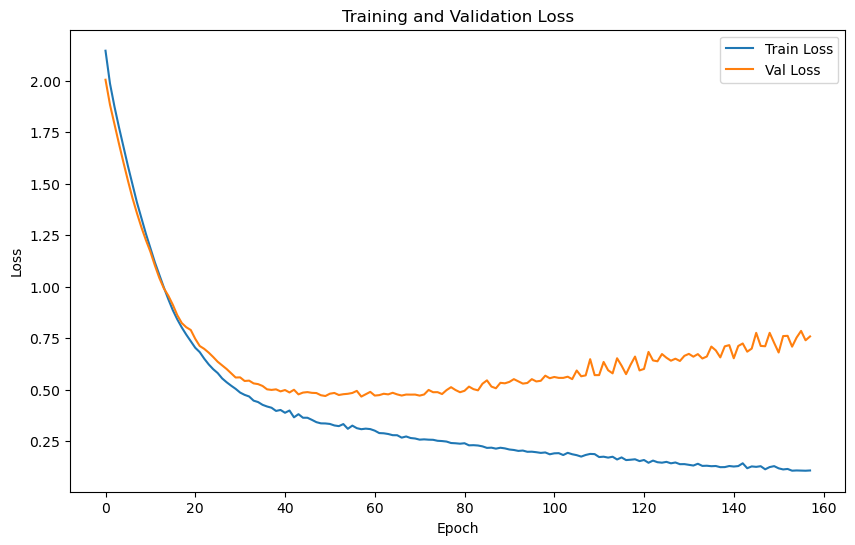

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.9185 | Test Accuracy: 74.98%


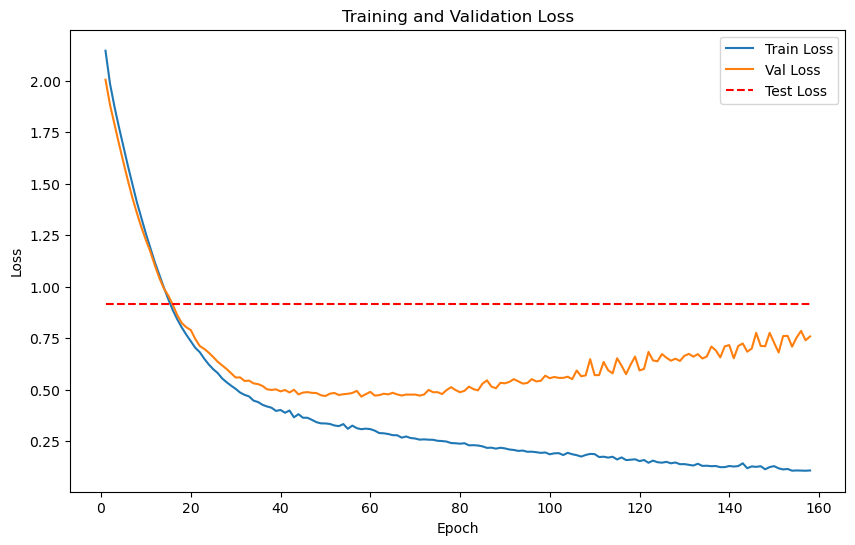

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 8.2767
Epoch [1/2000], Avg Train Loss: 8.2767
Epoch [1/2000], Avg Val Loss: 4.1501
Validation loss improved from inf to 4.1501. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.1178
Epoch [2/2000], Avg Train Loss: 8.1178
Epoch [2/2000], Avg Val Loss: 4.1130
Validation loss improved from 4.1501 to 4.1130. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.1475
Epoch [3/2000], Avg Train Loss: 8.1475
Epoch [3/2000], Avg Val Loss: 4.0764
Validation loss improved from 4.1130 to 4.0764. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.3821
Epoch [4/2000], Avg Train Loss: 8.3821
Epoch [4/2000], Avg Val Loss: 4.0407
Validation loss improved from 4.0764 to 4.0407. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2495
Epoch [5/2000], Avg Train Loss: 8.2495
Epoch [5/2000], Avg Val Loss: 4.0061
Validation loss improved from 4.0407 to 4.0061. Saving mode

Epoch [8/2000], Avg Val Loss: 3.9073
Validation loss improved from 3.9394 to 3.9073. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 7.8787
Epoch [9/2000], Avg Train Loss: 7.8787
Epoch [9/2000], Avg Val Loss: 3.8761
Validation loss improved from 3.9073 to 3.8761. Saving model...

LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 7.7256
Epoch [10/2000], Avg Train Loss: 7.7256
Epoch [10/2000], Avg Val Loss: 3.8457
Validation loss improved from 3.8761 to 3.8457. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 7.7112
Epoch [11/2000], Avg Train Loss: 7.7112
Epoch [11/2000], Avg Val Loss: 3.8163
Validation loss improved from 3.8457 to 3.8163. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 7.7296
Epoch [12/2000], Avg Train Loss: 7.7296
Epoch [12/2000], Avg Val Loss: 3.7874
Validation loss improved from 3.8163 to 3.7874. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Lo

    Batch [1/1], Train Loss: 6.8405
Epoch [25/2000], Avg Train Loss: 6.8405
Epoch [25/2000], Avg Val Loss: 3.4759
Validation loss improved from 3.4962 to 3.4759. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.8152
Epoch [26/2000], Avg Train Loss: 6.8152
Epoch [26/2000], Avg Val Loss: 3.4561
Validation loss improved from 3.4759 to 3.4561. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.5320
Epoch [27/2000], Avg Train Loss: 6.5320
Epoch [27/2000], Avg Val Loss: 3.4370
Validation loss improved from 3.4561 to 3.4370. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 6.5697
Epoch [28/2000], Avg Train Loss: 6.5697
Epoch [28/2000], Avg Val Loss: 3.4186
Validation loss improved from 3.4370 to 3.4186. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 6.4900
Epoch [29/2000], Avg Train Loss: 6.4900
Epoch [29/2000], Avg Val Loss: 3.4008
Validation loss improved from 3.4186 to 3.

    Batch [1/1], Train Loss: 5.9340
Epoch [48/2000], Avg Train Loss: 5.9340
Epoch [48/2000], Avg Val Loss: 3.1508
Validation loss improved from 3.1603 to 3.1508. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Train Loss: 5.6739
Epoch [49/2000], Avg Train Loss: 5.6739
Epoch [49/2000], Avg Val Loss: 3.1415
Validation loss improved from 3.1508 to 3.1415. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 5.7787
Epoch [50/2000], Avg Train Loss: 5.7787
Epoch [50/2000], Avg Val Loss: 3.1325
Validation loss improved from 3.1415 to 3.1325. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.6464
Epoch [51/2000], Avg Train Loss: 5.6464
Epoch [51/2000], Avg Val Loss: 3.1238
Validation loss improved from 3.1325 to 3.1238. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.6114
Epoch [52/2000], Avg Train Loss: 5.6114
Epoch [52/2000], Avg Val Loss: 3.1153
Validation loss improved from 3.1238 to 3.

    Batch [1/1], Train Loss: 5.2496
Epoch [69/2000], Avg Train Loss: 5.2496
Epoch [69/2000], Avg Val Loss: 3.0053
Validation loss improved from 3.0102 to 3.0053. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.2885
Epoch [70/2000], Avg Train Loss: 5.2885
Epoch [70/2000], Avg Val Loss: 3.0005
Validation loss improved from 3.0053 to 3.0005. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.3166
Epoch [71/2000], Avg Train Loss: 5.3166
Epoch [71/2000], Avg Val Loss: 2.9959
Validation loss improved from 3.0005 to 2.9959. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.1982
Epoch [72/2000], Avg Train Loss: 5.1982
Epoch [72/2000], Avg Val Loss: 2.9913
Validation loss improved from 2.9959 to 2.9913. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2151
Epoch [73/2000], Avg Train Loss: 5.2151
Epoch [73/2000], Avg Val Loss: 2.9869
Validation loss improved from 2.9913 to 2.

    Batch [1/1], Train Loss: 4.8934
Epoch [91/2000], Avg Train Loss: 4.8934
Epoch [91/2000], Avg Val Loss: 2.9221
Validation loss improved from 2.9250 to 2.9221. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 4.8739
Epoch [92/2000], Avg Train Loss: 4.8739
Epoch [92/2000], Avg Val Loss: 2.9192
Validation loss improved from 2.9221 to 2.9192. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 4.9568
Epoch [93/2000], Avg Train Loss: 4.9568
Epoch [93/2000], Avg Val Loss: 2.9164
Validation loss improved from 2.9192 to 2.9164. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 4.9339
Epoch [94/2000], Avg Train Loss: 4.9339
Epoch [94/2000], Avg Val Loss: 2.9137
Validation loss improved from 2.9164 to 2.9137. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 4.9464
Epoch [95/2000], Avg Train Loss: 4.9464
Epoch [95/2000], Avg Val Loss: 2.9110
Validation loss improved from 2.9137 to 2.

Epoch [111/2000], Avg Val Loss: 2.8736
Validation loss improved from 2.8757 to 2.8736. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.8146
Epoch [112/2000], Avg Train Loss: 4.8146
Epoch [112/2000], Avg Val Loss: 2.8716
Validation loss improved from 2.8736 to 2.8716. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.7404
Epoch [113/2000], Avg Train Loss: 4.7404
Epoch [113/2000], Avg Val Loss: 2.8696
Validation loss improved from 2.8716 to 2.8696. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 4.7420
Epoch [114/2000], Avg Train Loss: 4.7420
Epoch [114/2000], Avg Val Loss: 2.8677
Validation loss improved from 2.8696 to 2.8677. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.7549
Epoch [115/2000], Avg Train Loss: 4.7549
Epoch [115/2000], Avg Val Loss: 2.8657
Validation loss improved from 2.8677 to 2.8657. Saving model...

LOG: Epoch [116/2000] - Training
    Bat

Epoch [132/2000], Avg Val Loss: 2.8352
Validation loss improved from 2.8368 to 2.8352. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 4.6112
Epoch [133/2000], Avg Train Loss: 4.6112
Epoch [133/2000], Avg Val Loss: 2.8336
Validation loss improved from 2.8352 to 2.8336. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.5856
Epoch [134/2000], Avg Train Loss: 4.5856
Epoch [134/2000], Avg Val Loss: 2.8320
Validation loss improved from 2.8336 to 2.8320. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.6207
Epoch [135/2000], Avg Train Loss: 4.6207
Epoch [135/2000], Avg Val Loss: 2.8304
Validation loss improved from 2.8320 to 2.8304. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.6166
Epoch [136/2000], Avg Train Loss: 4.6166
Epoch [136/2000], Avg Val Loss: 2.8289
Validation loss improved from 2.8304 to 2.8289. Saving model...

LOG: Epoch [137/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5156
Epoch [155/2000], Avg Train Loss: 4.5156
Epoch [155/2000], Avg Val Loss: 2.8019
Validation loss improved from 2.8032 to 2.8019. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.5431
Epoch [156/2000], Avg Train Loss: 4.5431
Epoch [156/2000], Avg Val Loss: 2.8005
Validation loss improved from 2.8019 to 2.8005. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.5169
Epoch [157/2000], Avg Train Loss: 4.5169
Epoch [157/2000], Avg Val Loss: 2.7992
Validation loss improved from 2.8005 to 2.7992. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.4495
Epoch [158/2000], Avg Train Loss: 4.4495
Epoch [158/2000], Avg Val Loss: 2.7979
Validation loss improved from 2.7992 to 2.7979. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.4944
Epoch [159/2000], Avg Train Loss: 4.4944
Epoch [159/2000], Avg Val Loss: 2.7966
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4421
Epoch [175/2000], Avg Train Loss: 4.4421
Epoch [175/2000], Avg Val Loss: 2.7762
Validation loss improved from 2.7775 to 2.7762. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 4.4469
Epoch [176/2000], Avg Train Loss: 4.4469
Epoch [176/2000], Avg Val Loss: 2.7750
Validation loss improved from 2.7762 to 2.7750. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 4.4121
Epoch [177/2000], Avg Train Loss: 4.4121
Epoch [177/2000], Avg Val Loss: 2.7738
Validation loss improved from 2.7750 to 2.7738. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 4.3713
Epoch [178/2000], Avg Train Loss: 4.3713
Epoch [178/2000], Avg Val Loss: 2.7725
Validation loss improved from 2.7738 to 2.7725. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 4.4369
Epoch [179/2000], Avg Train Loss: 4.4369
Epoch [179/2000], Avg Val Loss: 2.7713
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3237
Epoch [200/2000], Avg Train Loss: 4.3237
Epoch [200/2000], Avg Val Loss: 2.7473
Validation loss improved from 2.7483 to 2.7473. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.3557
Epoch [201/2000], Avg Train Loss: 4.3557
Epoch [201/2000], Avg Val Loss: 2.7462
Validation loss improved from 2.7473 to 2.7462. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.3634
Epoch [202/2000], Avg Train Loss: 4.3634
Epoch [202/2000], Avg Val Loss: 2.7452
Validation loss improved from 2.7462 to 2.7452. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.3724
Epoch [203/2000], Avg Train Loss: 4.3724
Epoch [203/2000], Avg Val Loss: 2.7442
Validation loss improved from 2.7452 to 2.7442. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.3869
Epoch [204/2000], Avg Train Loss: 4.3869
Epoch [204/2000], Avg Val Loss: 2.7432
Validation loss improved fro

Epoch [217/2000], Avg Val Loss: 2.7304
Validation loss improved from 2.7314 to 2.7304. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.2790
Epoch [218/2000], Avg Train Loss: 4.2790
Epoch [218/2000], Avg Val Loss: 2.7294
Validation loss improved from 2.7304 to 2.7294. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.3058
Epoch [219/2000], Avg Train Loss: 4.3058
Epoch [219/2000], Avg Val Loss: 2.7284
Validation loss improved from 2.7294 to 2.7284. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.3573
Epoch [220/2000], Avg Train Loss: 4.3573
Epoch [220/2000], Avg Val Loss: 2.7274
Validation loss improved from 2.7284 to 2.7274. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.2932
Epoch [221/2000], Avg Train Loss: 4.2932
Epoch [221/2000], Avg Val Loss: 2.7264
Validation loss improved from 2.7274 to 2.7264. Saving model...

LOG: Epoch [222/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2615
Epoch [240/2000], Avg Train Loss: 4.2615
Epoch [240/2000], Avg Val Loss: 2.7081
Validation loss improved from 2.7090 to 2.7081. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 4.2736
Epoch [241/2000], Avg Train Loss: 4.2736
Epoch [241/2000], Avg Val Loss: 2.7072
Validation loss improved from 2.7081 to 2.7072. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 4.2151
Epoch [242/2000], Avg Train Loss: 4.2151
Epoch [242/2000], Avg Val Loss: 2.7064
Validation loss improved from 2.7072 to 2.7064. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/1], Train Loss: 4.2252
Epoch [243/2000], Avg Train Loss: 4.2252
Epoch [243/2000], Avg Val Loss: 2.7056
Validation loss improved from 2.7064 to 2.7056. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 4.2731
Epoch [244/2000], Avg Train Loss: 4.2731
Epoch [244/2000], Avg Val Loss: 2.7047
Validation loss improved fro

Epoch [258/2000], Avg Val Loss: 2.6936
Validation loss improved from 2.6943 to 2.6936. Saving model...

LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 4.2037
Epoch [259/2000], Avg Train Loss: 4.2037
Epoch [259/2000], Avg Val Loss: 2.6929
Validation loss improved from 2.6936 to 2.6929. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 4.1961
Epoch [260/2000], Avg Train Loss: 4.1961
Epoch [260/2000], Avg Val Loss: 2.6922
Validation loss improved from 2.6929 to 2.6922. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 4.1947
Epoch [261/2000], Avg Train Loss: 4.1947
Epoch [261/2000], Avg Val Loss: 2.6915
Validation loss improved from 2.6922 to 2.6915. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/1], Train Loss: 4.2191
Epoch [262/2000], Avg Train Loss: 4.2191
Epoch [262/2000], Avg Val Loss: 2.6908
Validation loss improved from 2.6915 to 2.6908. Saving model...

LOG: Epoch [263/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1511
Epoch [286/2000], Avg Train Loss: 4.1511
Epoch [286/2000], Avg Val Loss: 2.6734
Validation loss improved from 2.6741 to 2.6734. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 4.1713
Epoch [287/2000], Avg Train Loss: 4.1713
Epoch [287/2000], Avg Val Loss: 2.6728
Validation loss improved from 2.6734 to 2.6728. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 4.1517
Epoch [288/2000], Avg Train Loss: 4.1517
Epoch [288/2000], Avg Val Loss: 2.6721
Validation loss improved from 2.6728 to 2.6721. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 4.1638
Epoch [289/2000], Avg Train Loss: 4.1638
Epoch [289/2000], Avg Val Loss: 2.6715
Validation loss improved from 2.6721 to 2.6715. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 4.1472
Epoch [290/2000], Avg Train Loss: 4.1472
Epoch [290/2000], Avg Val Loss: 2.6708
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1568
Epoch [304/2000], Avg Train Loss: 4.1568
Epoch [304/2000], Avg Val Loss: 2.6616
Validation loss improved from 2.6623 to 2.6616. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.1341
Epoch [305/2000], Avg Train Loss: 4.1341
Epoch [305/2000], Avg Val Loss: 2.6610
Validation loss improved from 2.6616 to 2.6610. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 4.1149
Epoch [306/2000], Avg Train Loss: 4.1149
Epoch [306/2000], Avg Val Loss: 2.6603
Validation loss improved from 2.6610 to 2.6603. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 4.1212
Epoch [307/2000], Avg Train Loss: 4.1212
Epoch [307/2000], Avg Val Loss: 2.6596
Validation loss improved from 2.6603 to 2.6596. Saving model...

LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 4.0703
Epoch [308/2000], Avg Train Loss: 4.0703
Epoch [308/2000], Avg Val Loss: 2.6590
Validation loss improved fro

Epoch [327/2000], Avg Val Loss: 2.6479
Validation loss improved from 2.6484 to 2.6479. Saving model...

LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 4.1250
Epoch [328/2000], Avg Train Loss: 4.1250
Epoch [328/2000], Avg Val Loss: 2.6474
Validation loss improved from 2.6479 to 2.6474. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 4.0817
Epoch [329/2000], Avg Train Loss: 4.0817
Epoch [329/2000], Avg Val Loss: 2.6469
Validation loss improved from 2.6474 to 2.6469. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 4.1123
Epoch [330/2000], Avg Train Loss: 4.1123
Epoch [330/2000], Avg Val Loss: 2.6464
Validation loss improved from 2.6469 to 2.6464. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 4.1171
Epoch [331/2000], Avg Train Loss: 4.1171
Epoch [331/2000], Avg Val Loss: 2.6459
Validation loss improved from 2.6464 to 2.6459. Saving model...

LOG: Epoch [332/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.0999
Epoch [347/2000], Avg Train Loss: 4.0999
Epoch [347/2000], Avg Val Loss: 2.6375
Validation loss improved from 2.6380 to 2.6375. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.1013
Epoch [348/2000], Avg Train Loss: 4.1013
Epoch [348/2000], Avg Val Loss: 2.6371
Validation loss improved from 2.6375 to 2.6371. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.0553
Epoch [349/2000], Avg Train Loss: 4.0553
Epoch [349/2000], Avg Val Loss: 2.6366
Validation loss improved from 2.6371 to 2.6366. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.0919
Epoch [350/2000], Avg Train Loss: 4.0919
Epoch [350/2000], Avg Val Loss: 2.6361
Validation loss improved from 2.6366 to 2.6361. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.0254
Epoch [351/2000], Avg Train Loss: 4.0254
Epoch [351/2000], Avg Val Loss: 2.6357
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0394
Epoch [376/2000], Avg Train Loss: 4.0394
Epoch [376/2000], Avg Val Loss: 2.6256
Validation loss improved from 2.6260 to 2.6256. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.0437
Epoch [377/2000], Avg Train Loss: 4.0437
Epoch [377/2000], Avg Val Loss: 2.6253
Validation loss improved from 2.6256 to 2.6253. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 4.0195
Epoch [378/2000], Avg Train Loss: 4.0195
Epoch [378/2000], Avg Val Loss: 2.6249
Validation loss improved from 2.6253 to 2.6249. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 4.0443
Epoch [379/2000], Avg Train Loss: 4.0443
Epoch [379/2000], Avg Val Loss: 2.6246
Validation loss improved from 2.6249 to 2.6246. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 4.0521
Epoch [380/2000], Avg Train Loss: 4.0521
Epoch [380/2000], Avg Val Loss: 2.6242
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0543
Epoch [393/2000], Avg Train Loss: 4.0543
Epoch [393/2000], Avg Val Loss: 2.6189
Validation loss improved from 2.6193 to 2.6189. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 4.0203
Epoch [394/2000], Avg Train Loss: 4.0203
Epoch [394/2000], Avg Val Loss: 2.6186
Validation loss improved from 2.6189 to 2.6186. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 3.9972
Epoch [395/2000], Avg Train Loss: 3.9972
Epoch [395/2000], Avg Val Loss: 2.6182
Validation loss improved from 2.6186 to 2.6182. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.0430
Epoch [396/2000], Avg Train Loss: 4.0430
Epoch [396/2000], Avg Val Loss: 2.6178
Validation loss improved from 2.6182 to 2.6178. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 3.9932
Epoch [397/2000], Avg Train Loss: 3.9932
Epoch [397/2000], Avg Val Loss: 2.6174
Validation loss improved fro

Epoch [411/2000], Avg Val Loss: 2.6127
Validation loss improved from 2.6130 to 2.6127. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.0373
Epoch [412/2000], Avg Train Loss: 4.0373
Epoch [412/2000], Avg Val Loss: 2.6123
Validation loss improved from 2.6127 to 2.6123. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 3.9905
Epoch [413/2000], Avg Train Loss: 3.9905
Epoch [413/2000], Avg Val Loss: 2.6119
Validation loss improved from 2.6123 to 2.6119. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 3.9540
Epoch [414/2000], Avg Train Loss: 3.9540
Epoch [414/2000], Avg Val Loss: 2.6116
Validation loss improved from 2.6119 to 2.6116. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 4.0136
Epoch [415/2000], Avg Train Loss: 4.0136
Epoch [415/2000], Avg Val Loss: 2.6113
Validation loss improved from 2.6116 to 2.6113. Saving model...

LOG: Epoch [416/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9492
Epoch [434/2000], Avg Train Loss: 3.9492
Epoch [434/2000], Avg Val Loss: 2.6065
Validation loss improved from 2.6068 to 2.6065. Saving model...

LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 3.9661
Epoch [435/2000], Avg Train Loss: 3.9661
Epoch [435/2000], Avg Val Loss: 2.6063
Validation loss improved from 2.6065 to 2.6063. Saving model...

LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 3.9748
Epoch [436/2000], Avg Train Loss: 3.9748
Epoch [436/2000], Avg Val Loss: 2.6060
Validation loss improved from 2.6063 to 2.6060. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 3.9657
Epoch [437/2000], Avg Train Loss: 3.9657
Epoch [437/2000], Avg Val Loss: 2.6057
Validation loss improved from 2.6060 to 2.6057. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 3.9324
Epoch [438/2000], Avg Train Loss: 3.9324
Epoch [438/2000], Avg Val Loss: 2.6055
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9742
Epoch [456/2000], Avg Train Loss: 3.9742
Epoch [456/2000], Avg Val Loss: 2.6009
Validation loss improved from 2.6012 to 2.6009. Saving model...

LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 3.9648
Epoch [457/2000], Avg Train Loss: 3.9648
Epoch [457/2000], Avg Val Loss: 2.6007
Validation loss improved from 2.6009 to 2.6007. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/1], Train Loss: 3.9225
Epoch [458/2000], Avg Train Loss: 3.9225
Epoch [458/2000], Avg Val Loss: 2.6004
Validation loss improved from 2.6007 to 2.6004. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 3.9304
Epoch [459/2000], Avg Train Loss: 3.9304
Epoch [459/2000], Avg Val Loss: 2.6002
Validation loss improved from 2.6004 to 2.6002. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 3.9329
Epoch [460/2000], Avg Train Loss: 3.9329
Epoch [460/2000], Avg Val Loss: 2.5999
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9271
Epoch [477/2000], Avg Train Loss: 3.9271
Epoch [477/2000], Avg Val Loss: 2.5967
Validation loss improved from 2.5969 to 2.5967. Saving model...

LOG: Epoch [478/2000] - Training
    Batch [1/1], Train Loss: 3.9525
Epoch [478/2000], Avg Train Loss: 3.9525
Epoch [478/2000], Avg Val Loss: 2.5966
Validation loss improved from 2.5967 to 2.5966. Saving model...

LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 3.8972
Epoch [479/2000], Avg Train Loss: 3.8972
Epoch [479/2000], Avg Val Loss: 2.5965
Validation loss improved from 2.5966 to 2.5965. Saving model...

LOG: Epoch [480/2000] - Training
    Batch [1/1], Train Loss: 3.9100
Epoch [480/2000], Avg Train Loss: 3.9100
Epoch [480/2000], Avg Val Loss: 2.5964
Validation loss improved from 2.5965 to 2.5964. Saving model...

LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 3.9164
Epoch [481/2000], Avg Train Loss: 3.9164
Epoch [481/2000], Avg Val Loss: 2.5963
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9369
Epoch [496/2000], Avg Train Loss: 3.9369
Epoch [496/2000], Avg Val Loss: 2.5933
Validation loss improved from 2.5936 to 2.5933. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 3.8788
Epoch [497/2000], Avg Train Loss: 3.8788
Epoch [497/2000], Avg Val Loss: 2.5931
Validation loss improved from 2.5933 to 2.5931. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 3.9216
Epoch [498/2000], Avg Train Loss: 3.9216
Epoch [498/2000], Avg Val Loss: 2.5928
Validation loss improved from 2.5931 to 2.5928. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.9437
Epoch [499/2000], Avg Train Loss: 3.9437
Epoch [499/2000], Avg Val Loss: 2.5926
Validation loss improved from 2.5928 to 2.5926. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.9215
Epoch [500/2000], Avg Train Loss: 3.9215
Epoch [500/2000], Avg Val Loss: 2.5923
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8626
Epoch [518/2000], Avg Train Loss: 3.8626
Epoch [518/2000], Avg Val Loss: 2.5888
Validation loss improved from 2.5890 to 2.5888. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.8776
Epoch [519/2000], Avg Train Loss: 3.8776
Epoch [519/2000], Avg Val Loss: 2.5887
Validation loss improved from 2.5888 to 2.5887. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.9126
Epoch [520/2000], Avg Train Loss: 3.9126
Epoch [520/2000], Avg Val Loss: 2.5884
Validation loss improved from 2.5887 to 2.5884. Saving model...

LOG: Epoch [521/2000] - Training
    Batch [1/1], Train Loss: 3.9267
Epoch [521/2000], Avg Train Loss: 3.9267
Epoch [521/2000], Avg Val Loss: 2.5882
Validation loss improved from 2.5884 to 2.5882. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 3.9077
Epoch [522/2000], Avg Train Loss: 3.9077
Epoch [522/2000], Avg Val Loss: 2.5880
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8656
Epoch [541/2000], Avg Train Loss: 3.8656
Epoch [541/2000], Avg Val Loss: 2.5850
Validation loss improved from 2.5852 to 2.5850. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 3.8967
Epoch [542/2000], Avg Train Loss: 3.8967
Epoch [542/2000], Avg Val Loss: 2.5848
Validation loss improved from 2.5850 to 2.5848. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 3.8835
Epoch [543/2000], Avg Train Loss: 3.8835
Epoch [543/2000], Avg Val Loss: 2.5846
Validation loss improved from 2.5848 to 2.5846. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.8643
Epoch [544/2000], Avg Train Loss: 3.8643
Epoch [544/2000], Avg Val Loss: 2.5844
Validation loss improved from 2.5846 to 2.5844. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/1], Train Loss: 3.8950
Epoch [545/2000], Avg Train Loss: 3.8950
Epoch [545/2000], Avg Val Loss: 2.5842
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8488
Epoch [565/2000], Avg Train Loss: 3.8488
Epoch [565/2000], Avg Val Loss: 2.5825
Validation loss did not improve. Patience: 8/100

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 3.8933
Epoch [566/2000], Avg Train Loss: 3.8933
Epoch [566/2000], Avg Val Loss: 2.5825
Validation loss did not improve. Patience: 9/100

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 3.8668
Epoch [567/2000], Avg Train Loss: 3.8668
Epoch [567/2000], Avg Val Loss: 2.5825
Validation loss did not improve. Patience: 10/100

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 3.8939
Epoch [568/2000], Avg Train Loss: 3.8939
Epoch [568/2000], Avg Val Loss: 2.5824
Validation loss did not improve. Patience: 11/100

LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 3.8563
Epoch [569/2000], Avg Train Loss: 3.8563
Epoch [569/2000], Avg Val Loss: 2.5824
Validation loss did not improve. Patience: 12/100

LOG: Epoch [570/2000] - Training
  

    Batch [1/1], Train Loss: 3.8379
Epoch [586/2000], Avg Train Loss: 3.8379
Epoch [586/2000], Avg Val Loss: 2.5819
Validation loss improved from 2.5820 to 2.5819. Saving model...

LOG: Epoch [587/2000] - Training
    Batch [1/1], Train Loss: 3.8629
Epoch [587/2000], Avg Train Loss: 3.8629
Epoch [587/2000], Avg Val Loss: 2.5818
Validation loss improved from 2.5819 to 2.5818. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.8442
Epoch [588/2000], Avg Train Loss: 3.8442
Epoch [588/2000], Avg Val Loss: 2.5816
Validation loss improved from 2.5818 to 2.5816. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 3.9294
Epoch [589/2000], Avg Train Loss: 3.9294
Epoch [589/2000], Avg Val Loss: 2.5814
Validation loss improved from 2.5816 to 2.5814. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.8505
Epoch [590/2000], Avg Train Loss: 3.8505
Epoch [590/2000], Avg Val Loss: 2.5813
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8479
Epoch [608/2000], Avg Train Loss: 3.8479
Epoch [608/2000], Avg Val Loss: 2.5793
Validation loss did not improve. Patience: 1/100

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.8374
Epoch [609/2000], Avg Train Loss: 3.8374
Epoch [609/2000], Avg Val Loss: 2.5793
Validation loss did not improve. Patience: 2/100

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.8653
Epoch [610/2000], Avg Train Loss: 3.8653
Epoch [610/2000], Avg Val Loss: 2.5793
Validation loss did not improve. Patience: 3/100

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.8385
Epoch [611/2000], Avg Train Loss: 3.8385
Epoch [611/2000], Avg Val Loss: 2.5793
Validation loss did not improve. Patience: 4/100

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 3.8409
Epoch [612/2000], Avg Train Loss: 3.8409
Epoch [612/2000], Avg Val Loss: 2.5792
Validation loss improved from 2.5793 to 2.5792. Saving model...

LOG: Epoch [613/2000] -

    Batch [1/1], Train Loss: 3.8451
Epoch [629/2000], Avg Train Loss: 3.8451
Epoch [629/2000], Avg Val Loss: 2.5764
Validation loss improved from 2.5766 to 2.5764. Saving model...

LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 3.8161
Epoch [630/2000], Avg Train Loss: 3.8161
Epoch [630/2000], Avg Val Loss: 2.5762
Validation loss improved from 2.5764 to 2.5762. Saving model...

LOG: Epoch [631/2000] - Training
    Batch [1/1], Train Loss: 3.8458
Epoch [631/2000], Avg Train Loss: 3.8458
Epoch [631/2000], Avg Val Loss: 2.5761
Validation loss improved from 2.5762 to 2.5761. Saving model...

LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 3.8629
Epoch [632/2000], Avg Train Loss: 3.8629
Epoch [632/2000], Avg Val Loss: 2.5759
Validation loss improved from 2.5761 to 2.5759. Saving model...

LOG: Epoch [633/2000] - Training
    Batch [1/1], Train Loss: 3.8369
Epoch [633/2000], Avg Train Loss: 3.8369
Epoch [633/2000], Avg Val Loss: 2.5757
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7718
Epoch [653/2000], Avg Train Loss: 3.7718
Epoch [653/2000], Avg Val Loss: 2.5717
Validation loss improved from 2.5719 to 2.5717. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 3.8143
Epoch [654/2000], Avg Train Loss: 3.8143
Epoch [654/2000], Avg Val Loss: 2.5716
Validation loss improved from 2.5717 to 2.5716. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 3.8227
Epoch [655/2000], Avg Train Loss: 3.8227
Epoch [655/2000], Avg Val Loss: 2.5715
Validation loss improved from 2.5716 to 2.5715. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.8131
Epoch [656/2000], Avg Train Loss: 3.8131
Epoch [656/2000], Avg Val Loss: 2.5713
Validation loss improved from 2.5715 to 2.5713. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 3.8385
Epoch [657/2000], Avg Train Loss: 3.8385
Epoch [657/2000], Avg Val Loss: 2.5711
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8122
Epoch [670/2000], Avg Train Loss: 3.8122
Epoch [670/2000], Avg Val Loss: 2.5709
Validation loss did not improve. Patience: 6/100

LOG: Epoch [671/2000] - Training
    Batch [1/1], Train Loss: 3.7708
Epoch [671/2000], Avg Train Loss: 3.7708
Epoch [671/2000], Avg Val Loss: 2.5710
Validation loss did not improve. Patience: 7/100

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 3.7848
Epoch [672/2000], Avg Train Loss: 3.7848
Epoch [672/2000], Avg Val Loss: 2.5709
Validation loss did not improve. Patience: 8/100

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.7663
Epoch [673/2000], Avg Train Loss: 3.7663
Epoch [673/2000], Avg Val Loss: 2.5709
Validation loss did not improve. Patience: 9/100

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.7898
Epoch [674/2000], Avg Train Loss: 3.7898
Epoch [674/2000], Avg Val Loss: 2.5708
Validation loss did not improve. Patience: 10/100

LOG: Epoch [675/2000] - Training
    

    Batch [1/1], Train Loss: 3.7591
Epoch [698/2000], Avg Train Loss: 3.7591
Epoch [698/2000], Avg Val Loss: 2.5703
Validation loss did not improve. Patience: 4/100

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.7915
Epoch [699/2000], Avg Train Loss: 3.7915
Epoch [699/2000], Avg Val Loss: 2.5703
Validation loss did not improve. Patience: 5/100

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.7953
Epoch [700/2000], Avg Train Loss: 3.7953
Epoch [700/2000], Avg Val Loss: 2.5704
Validation loss did not improve. Patience: 6/100

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 3.7914
Epoch [701/2000], Avg Train Loss: 3.7914
Epoch [701/2000], Avg Val Loss: 2.5704
Validation loss did not improve. Patience: 7/100

LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 3.7580
Epoch [702/2000], Avg Train Loss: 3.7580
Epoch [702/2000], Avg Val Loss: 2.5704
Validation loss did not improve. Patience: 8/100

LOG: Epoch [703/2000] - Training
    B

    Batch [1/1], Train Loss: 3.8019
Epoch [713/2000], Avg Train Loss: 3.8019
Epoch [713/2000], Avg Val Loss: 2.5700
Validation loss did not improve. Patience: 1/100

LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 3.7394
Epoch [714/2000], Avg Train Loss: 3.7394
Epoch [714/2000], Avg Val Loss: 2.5699
Validation loss improved from 2.5700 to 2.5699. Saving model...

LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 3.7962
Epoch [715/2000], Avg Train Loss: 3.7962
Epoch [715/2000], Avg Val Loss: 2.5698
Validation loss improved from 2.5699 to 2.5698. Saving model...

LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 3.7849
Epoch [716/2000], Avg Train Loss: 3.7849
Epoch [716/2000], Avg Val Loss: 2.5697
Validation loss improved from 2.5698 to 2.5697. Saving model...

LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 3.7770
Epoch [717/2000], Avg Train Loss: 3.7770
Epoch [717/2000], Avg Val Loss: 2.5696
Validation loss improved from 2.5697 to 2.5

    Batch [1/1], Train Loss: 3.7795
Epoch [740/2000], Avg Train Loss: 3.7795
Epoch [740/2000], Avg Val Loss: 2.5665
Validation loss improved from 2.5666 to 2.5665. Saving model...

LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 3.7611
Epoch [741/2000], Avg Train Loss: 3.7611
Epoch [741/2000], Avg Val Loss: 2.5665
Validation loss did not improve. Patience: 1/100

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.7599
Epoch [742/2000], Avg Train Loss: 3.7599
Epoch [742/2000], Avg Val Loss: 2.5666
Validation loss did not improve. Patience: 2/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.7854
Epoch [743/2000], Avg Train Loss: 3.7854
Epoch [743/2000], Avg Val Loss: 2.5666
Validation loss did not improve. Patience: 3/100

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.7592
Epoch [744/2000], Avg Train Loss: 3.7592
Epoch [744/2000], Avg Val Loss: 2.5667
Validation loss did not improve. Patience: 4/100

LOG: Epoch [745/2000] -

    Batch [1/1], Train Loss: 3.7832
Epoch [753/2000], Avg Train Loss: 3.7832
Epoch [753/2000], Avg Val Loss: 2.5676
Validation loss did not improve. Patience: 13/100

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.7624
Epoch [754/2000], Avg Train Loss: 3.7624
Epoch [754/2000], Avg Val Loss: 2.5676
Validation loss did not improve. Patience: 14/100

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.7321
Epoch [755/2000], Avg Train Loss: 3.7321
Epoch [755/2000], Avg Val Loss: 2.5677
Validation loss did not improve. Patience: 15/100

LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 3.7617
Epoch [756/2000], Avg Train Loss: 3.7617
Epoch [756/2000], Avg Val Loss: 2.5678
Validation loss did not improve. Patience: 16/100

LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 3.7661
Epoch [757/2000], Avg Train Loss: 3.7661
Epoch [757/2000], Avg Val Loss: 2.5679
Validation loss did not improve. Patience: 17/100

LOG: Epoch [758/2000] - Training


Epoch [786/2000], Avg Val Loss: 2.5645
Validation loss improved from 2.5647 to 2.5645. Saving model...

LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 3.7306
Epoch [787/2000], Avg Train Loss: 3.7306
Epoch [787/2000], Avg Val Loss: 2.5644
Validation loss improved from 2.5645 to 2.5644. Saving model...

LOG: Epoch [788/2000] - Training
    Batch [1/1], Train Loss: 3.7575
Epoch [788/2000], Avg Train Loss: 3.7575
Epoch [788/2000], Avg Val Loss: 2.5643
Validation loss improved from 2.5644 to 2.5643. Saving model...

LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 3.8054
Epoch [789/2000], Avg Train Loss: 3.8054
Epoch [789/2000], Avg Val Loss: 2.5641
Validation loss improved from 2.5643 to 2.5641. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.7511
Epoch [790/2000], Avg Train Loss: 3.7511
Epoch [790/2000], Avg Val Loss: 2.5639
Validation loss improved from 2.5641 to 2.5639. Saving model...

LOG: Epoch [791/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7118
Epoch [797/2000], Avg Train Loss: 3.7118
Epoch [797/2000], Avg Val Loss: 2.5625
Validation loss improved from 2.5627 to 2.5625. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.7350
Epoch [798/2000], Avg Train Loss: 3.7350
Epoch [798/2000], Avg Val Loss: 2.5622
Validation loss improved from 2.5625 to 2.5622. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.7317
Epoch [799/2000], Avg Train Loss: 3.7317
Epoch [799/2000], Avg Val Loss: 2.5620
Validation loss improved from 2.5622 to 2.5620. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.7197
Epoch [800/2000], Avg Train Loss: 3.7197
Epoch [800/2000], Avg Val Loss: 2.5619
Validation loss improved from 2.5620 to 2.5619. Saving model...

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.7676
Epoch [801/2000], Avg Train Loss: 3.7676
Epoch [801/2000], Avg Val Loss: 2.5618
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7567
Epoch [830/2000], Avg Train Loss: 3.7567
Epoch [830/2000], Avg Val Loss: 2.5638
Validation loss did not improve. Patience: 16/100

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.7013
Epoch [831/2000], Avg Train Loss: 3.7013
Epoch [831/2000], Avg Val Loss: 2.5639
Validation loss did not improve. Patience: 17/100

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.7557
Epoch [832/2000], Avg Train Loss: 3.7557
Epoch [832/2000], Avg Val Loss: 2.5639
Validation loss did not improve. Patience: 18/100

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.7193
Epoch [833/2000], Avg Train Loss: 3.7193
Epoch [833/2000], Avg Val Loss: 2.5641
Validation loss did not improve. Patience: 19/100

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.7193
Epoch [834/2000], Avg Train Loss: 3.7193
Epoch [834/2000], Avg Val Loss: 2.5642
Validation loss did not improve. Patience: 20/100

LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 3.6873
Epoch [841/2000], Avg Train Loss: 3.6873
Epoch [841/2000], Avg Val Loss: 2.5653
Validation loss did not improve. Patience: 27/100

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 3.7033
Epoch [842/2000], Avg Train Loss: 3.7033
Epoch [842/2000], Avg Val Loss: 2.5653
Validation loss did not improve. Patience: 28/100

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 3.7258
Epoch [843/2000], Avg Train Loss: 3.7258
Epoch [843/2000], Avg Val Loss: 2.5654
Validation loss did not improve. Patience: 29/100

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 3.7426
Epoch [844/2000], Avg Train Loss: 3.7426
Epoch [844/2000], Avg Val Loss: 2.5654
Validation loss did not improve. Patience: 30/100

LOG: Epoch [845/2000] - Training
    Batch [1/1], Train Loss: 3.7272
Epoch [845/2000], Avg Train Loss: 3.7272
Epoch [845/2000], Avg Val Loss: 2.5655
Validation loss did not improve. Patience: 31/100

LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 3.7251
Epoch [877/2000], Avg Train Loss: 3.7251
Epoch [877/2000], Avg Val Loss: 2.5644
Validation loss did not improve. Patience: 63/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.7138
Epoch [878/2000], Avg Train Loss: 3.7138
Epoch [878/2000], Avg Val Loss: 2.5644
Validation loss did not improve. Patience: 64/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.6976
Epoch [879/2000], Avg Train Loss: 3.6976
Epoch [879/2000], Avg Val Loss: 2.5644
Validation loss did not improve. Patience: 65/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.7486
Epoch [880/2000], Avg Train Loss: 3.7486
Epoch [880/2000], Avg Val Loss: 2.5644
Validation loss did not improve. Patience: 66/100

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.6890
Epoch [881/2000], Avg Train Loss: 3.6890
Epoch [881/2000], Avg Val Loss: 2.5644
Validation loss did not improve. Patience: 67/100

LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 3.6968
Epoch [886/2000], Avg Train Loss: 3.6968
Epoch [886/2000], Avg Val Loss: 2.5645
Validation loss did not improve. Patience: 72/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 3.7026
Epoch [887/2000], Avg Train Loss: 3.7026
Epoch [887/2000], Avg Val Loss: 2.5645
Validation loss did not improve. Patience: 73/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.7000
Epoch [888/2000], Avg Train Loss: 3.7000
Epoch [888/2000], Avg Val Loss: 2.5646
Validation loss did not improve. Patience: 74/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.6907
Epoch [889/2000], Avg Train Loss: 3.6907
Epoch [889/2000], Avg Val Loss: 2.5646
Validation loss did not improve. Patience: 75/100

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 3.6886
Epoch [890/2000], Avg Train Loss: 3.6886
Epoch [890/2000], Avg Val Loss: 2.5646
Validation loss did not improve. Patience: 76/100

LOG: Epoch [891/2000] - Training


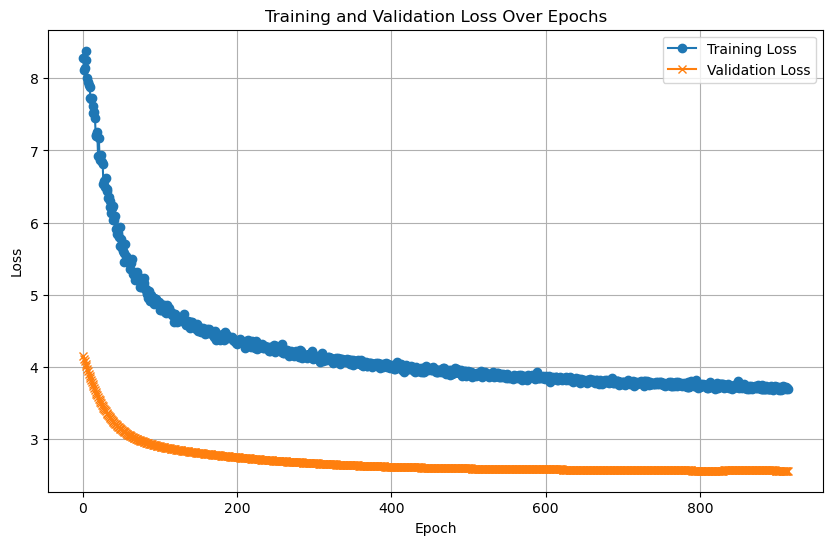

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/167], Loss: 5.3469
Test Batch [20/167], Loss: 5.1403
Test Batch [30/167], Loss: 5.1545
Test Batch [40/167], Loss: 5.3281
Test Batch [50/167], Loss: 5.2069
Test Batch [60/167], Loss: 5.1120
Test Batch [70/167], Loss: 5.1175
Test Batch [80/167], Loss: 5.4222
Test Batch [90/167], Loss: 5.4715
Test Batch [100/167], Loss: 4.9779
Test Batch [110/167], Loss: 4.9275
Test Batch [120/167], Loss: 4.7955
Test Batch [130/167], Loss: 4.8432
Test Batch [140/167], Loss: 4.9570
Test Batch [150/167], Loss: 5.3652
Test Batch [160/167], Loss: 6.4338

Test Loss: 5.1384


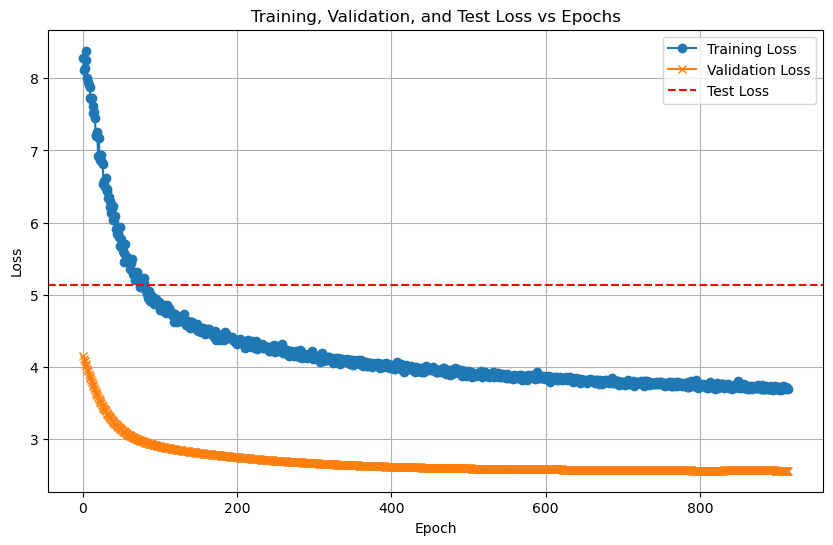

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/167 for test dataset.
  Processed batch 20/167 for test dataset.


  Processed batch 30/167 for test dataset.
  Processed batch 40/167 for test dataset.
  Processed batch 50/167 for test dataset.
  Processed batch 60/167 for test dataset.
  Processed batch 70/167 for test dataset.
  Processed batch 80/167 for test dataset.


  Processed batch 90/167 for test dataset.
  Processed batch 100/167 for test dataset.
  Processed batch 110/167 for test dataset.
  Processed batch 120/167 for test dataset.
  Processed batch 130/167 for test dataset.
  Processed batch 140/167 for test dataset.
  Processed batch 150/167 for test dataset.


  Processed batch 160/167 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.75      0.60      0.67         5
           2       0.67      0.80      0.73         5
           3       1.00      0.80      0.89         5
           4       1.00      1.00      1.00         5
           5       0.67      0.80      0.73         5
           6       1.00      0.80      0.89         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5

    accuracy                           0.84        45
   macro avg       0.86      0.84      0.85        45
weighted avg       0.86      0.84      0.85        45


LOG: Evaluating on the test set...
Test Accuracy: 71.92%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.4049  |  Val Loss: 2.3893
Validation loss improved from inf to 2.3893.


[Epoch 2/1000] Train Loss: 2.3636  |  Val Loss: 2.3470
Validation loss improved from 2.3893 to 2.3470.
[Epoch 3/1000] Train Loss: 2.3275  |  Val Loss: 2.3072
Validation loss improved from 2.3470 to 2.3072.
[Epoch 4/1000] Train Loss: 2.2883  |  Val Loss: 2.2695
Validation loss improved from 2.3072 to 2.2695.
[Epoch 5/1000] Train Loss: 2.2543  |  Val Loss: 2.2334
Validation loss improved from 2.2695 to 2.2334.
[Epoch 6/1000] Train Loss: 2.2194  |  Val Loss: 2.1987
Validation loss improved from 2.2334 to 2.1987.
[Epoch 7/1000] Train Loss: 2.1863  |  Val Loss: 2.1648
Validation loss improved from 2.1987 to 2.1648.
[Epoch 8/1000] Train Loss: 2.1549  |  Val Loss: 2.1319
Validation loss improved from 2.1648 to 2.1319.


[Epoch 9/1000] Train Loss: 2.1226  |  Val Loss: 2.0993
Validation loss improved from 2.1319 to 2.0993.
[Epoch 10/1000] Train Loss: 2.0929  |  Val Loss: 2.0675
Validation loss improved from 2.0993 to 2.0675.
[Epoch 11/1000] Train Loss: 2.0633  |  Val Loss: 2.0359
Validation loss improved from 2.0675 to 2.0359.
[Epoch 12/1000] Train Loss: 2.0312  |  Val Loss: 2.0051
Validation loss improved from 2.0359 to 2.0051.
[Epoch 13/1000] Train Loss: 2.0033  |  Val Loss: 1.9750
Validation loss improved from 2.0051 to 1.9750.
[Epoch 14/1000] Train Loss: 1.9745  |  Val Loss: 1.9467
Validation loss improved from 1.9750 to 1.9467.
[Epoch 15/1000] Train Loss: 1.9475  |  Val Loss: 1.9190
Validation loss improved from 1.9467 to 1.9190.
[Epoch 16/1000] Train Loss: 1.9208  |  Val Loss: 1.8919
Validation loss improved from 1.9190 to 1.8919.
[Epoch 17/1000] Train Loss: 1.8956  |  Val Loss: 1.8661
Validation loss improved from 1.8919 to 1.8661.
[Epoch 18/1000] Train Loss: 1.8712  |  Val Loss: 1.8413
Validatio

[Epoch 29/1000] Train Loss: 1.6607  |  Val Loss: 1.6339
Validation loss improved from 1.6493 to 1.6339.
[Epoch 30/1000] Train Loss: 1.6443  |  Val Loss: 1.6185
Validation loss improved from 1.6339 to 1.6185.
[Epoch 31/1000] Train Loss: 1.6285  |  Val Loss: 1.6034
Validation loss improved from 1.6185 to 1.6034.
[Epoch 32/1000] Train Loss: 1.6124  |  Val Loss: 1.5885
Validation loss improved from 1.6034 to 1.5885.
[Epoch 33/1000] Train Loss: 1.5971  |  Val Loss: 1.5737
Validation loss improved from 1.5885 to 1.5737.
[Epoch 34/1000] Train Loss: 1.5814  |  Val Loss: 1.5593
Validation loss improved from 1.5737 to 1.5593.
[Epoch 35/1000] Train Loss: 1.5665  |  Val Loss: 1.5453
Validation loss improved from 1.5593 to 1.5453.
[Epoch 36/1000] Train Loss: 1.5512  |  Val Loss: 1.5317
Validation loss improved from 1.5453 to 1.5317.
[Epoch 37/1000] Train Loss: 1.5369  |  Val Loss: 1.5184
Validation loss improved from 1.5317 to 1.5184.
[Epoch 38/1000] Train Loss: 1.5228  |  Val Loss: 1.5054
Validati

[Epoch 42/1000] Train Loss: 1.4686  |  Val Loss: 1.4554
Validation loss improved from 1.4676 to 1.4554.
[Epoch 43/1000] Train Loss: 1.4562  |  Val Loss: 1.4435
Validation loss improved from 1.4554 to 1.4435.
[Epoch 44/1000] Train Loss: 1.4428  |  Val Loss: 1.4318
Validation loss improved from 1.4435 to 1.4318.
[Epoch 45/1000] Train Loss: 1.4305  |  Val Loss: 1.4201
Validation loss improved from 1.4318 to 1.4201.
[Epoch 46/1000] Train Loss: 1.4177  |  Val Loss: 1.4088
Validation loss improved from 1.4201 to 1.4088.
[Epoch 47/1000] Train Loss: 1.4057  |  Val Loss: 1.3978
Validation loss improved from 1.4088 to 1.3978.
[Epoch 48/1000] Train Loss: 1.3935  |  Val Loss: 1.3868
Validation loss improved from 1.3978 to 1.3868.
[Epoch 49/1000] Train Loss: 1.3817  |  Val Loss: 1.3760
Validation loss improved from 1.3868 to 1.3760.
[Epoch 50/1000] Train Loss: 1.3699  |  Val Loss: 1.3653
Validation loss improved from 1.3760 to 1.3653.
[Epoch 51/1000] Train Loss: 1.3584  |  Val Loss: 1.3549
Validati

[Epoch 62/1000] Train Loss: 1.2402  |  Val Loss: 1.2483
Validation loss improved from 1.2573 to 1.2483.
[Epoch 63/1000] Train Loss: 1.2302  |  Val Loss: 1.2394
Validation loss improved from 1.2483 to 1.2394.
[Epoch 64/1000] Train Loss: 1.2204  |  Val Loss: 1.2307
Validation loss improved from 1.2394 to 1.2307.
[Epoch 65/1000] Train Loss: 1.2108  |  Val Loss: 1.2221
Validation loss improved from 1.2307 to 1.2221.
[Epoch 66/1000] Train Loss: 1.2010  |  Val Loss: 1.2137
Validation loss improved from 1.2221 to 1.2137.
[Epoch 67/1000] Train Loss: 1.1916  |  Val Loss: 1.2054
Validation loss improved from 1.2137 to 1.2054.
[Epoch 68/1000] Train Loss: 1.1819  |  Val Loss: 1.1971
Validation loss improved from 1.2054 to 1.1971.
[Epoch 69/1000] Train Loss: 1.1730  |  Val Loss: 1.1889
Validation loss improved from 1.1971 to 1.1889.
[Epoch 70/1000] Train Loss: 1.1634  |  Val Loss: 1.1807
Validation loss improved from 1.1889 to 1.1807.
[Epoch 71/1000] Train Loss: 1.1542  |  Val Loss: 1.1726
Validati

[Epoch 75/1000] Train Loss: 1.1185  |  Val Loss: 1.1414
Validation loss improved from 1.1488 to 1.1414.
[Epoch 76/1000] Train Loss: 1.1095  |  Val Loss: 1.1338
Validation loss improved from 1.1414 to 1.1338.
[Epoch 77/1000] Train Loss: 1.1009  |  Val Loss: 1.1261
Validation loss improved from 1.1338 to 1.1261.
[Epoch 78/1000] Train Loss: 1.0924  |  Val Loss: 1.1186
Validation loss improved from 1.1261 to 1.1186.
[Epoch 79/1000] Train Loss: 1.0841  |  Val Loss: 1.1112
Validation loss improved from 1.1186 to 1.1112.
[Epoch 80/1000] Train Loss: 1.0753  |  Val Loss: 1.1035
Validation loss improved from 1.1112 to 1.1035.
[Epoch 81/1000] Train Loss: 1.0669  |  Val Loss: 1.0960
Validation loss improved from 1.1035 to 1.0960.
[Epoch 82/1000] Train Loss: 1.0590  |  Val Loss: 1.0886
Validation loss improved from 1.0960 to 1.0886.
[Epoch 83/1000] Train Loss: 1.0505  |  Val Loss: 1.0814
Validation loss improved from 1.0886 to 1.0814.
[Epoch 84/1000] Train Loss: 1.0424  |  Val Loss: 1.0745
Validati

[Epoch 91/1000] Train Loss: 0.9892  |  Val Loss: 1.0270
Validation loss improved from 1.0335 to 1.0270.
[Epoch 92/1000] Train Loss: 0.9815  |  Val Loss: 1.0207
Validation loss improved from 1.0270 to 1.0207.
[Epoch 93/1000] Train Loss: 0.9744  |  Val Loss: 1.0145
Validation loss improved from 1.0207 to 1.0145.
[Epoch 94/1000] Train Loss: 0.9671  |  Val Loss: 1.0081
Validation loss improved from 1.0145 to 1.0081.
[Epoch 95/1000] Train Loss: 0.9603  |  Val Loss: 1.0020
Validation loss improved from 1.0081 to 1.0020.
[Epoch 96/1000] Train Loss: 0.9530  |  Val Loss: 0.9959
Validation loss improved from 1.0020 to 0.9959.
[Epoch 97/1000] Train Loss: 0.9462  |  Val Loss: 0.9897
Validation loss improved from 0.9959 to 0.9897.
[Epoch 98/1000] Train Loss: 0.9393  |  Val Loss: 0.9837
Validation loss improved from 0.9897 to 0.9837.
[Epoch 99/1000] Train Loss: 0.9327  |  Val Loss: 0.9778
Validation loss improved from 0.9837 to 0.9778.
[Epoch 100/1000] Train Loss: 0.9257  |  Val Loss: 0.9717
Validat

[Epoch 110/1000] Train Loss: 0.8616  |  Val Loss: 0.9144
Validation loss improved from 0.9200 to 0.9144.
[Epoch 111/1000] Train Loss: 0.8554  |  Val Loss: 0.9089
Validation loss improved from 0.9144 to 0.9089.
[Epoch 112/1000] Train Loss: 0.8495  |  Val Loss: 0.9035
Validation loss improved from 0.9089 to 0.9035.
[Epoch 113/1000] Train Loss: 0.8434  |  Val Loss: 0.8981
Validation loss improved from 0.9035 to 0.8981.
[Epoch 114/1000] Train Loss: 0.8374  |  Val Loss: 0.8928
Validation loss improved from 0.8981 to 0.8928.
[Epoch 115/1000] Train Loss: 0.8314  |  Val Loss: 0.8875
Validation loss improved from 0.8928 to 0.8875.
[Epoch 116/1000] Train Loss: 0.8258  |  Val Loss: 0.8822
Validation loss improved from 0.8875 to 0.8822.
[Epoch 117/1000] Train Loss: 0.8199  |  Val Loss: 0.8773
Validation loss improved from 0.8822 to 0.8773.
[Epoch 118/1000] Train Loss: 0.8144  |  Val Loss: 0.8723
Validation loss improved from 0.8773 to 0.8723.
[Epoch 119/1000] Train Loss: 0.8087  |  Val Loss: 0.867

[Epoch 126/1000] Train Loss: 0.7711  |  Val Loss: 0.8327
Validation loss improved from 0.8376 to 0.8327.
[Epoch 127/1000] Train Loss: 0.7658  |  Val Loss: 0.8280
Validation loss improved from 0.8327 to 0.8280.
[Epoch 128/1000] Train Loss: 0.7608  |  Val Loss: 0.8236
Validation loss improved from 0.8280 to 0.8236.
[Epoch 129/1000] Train Loss: 0.7555  |  Val Loss: 0.8189
Validation loss improved from 0.8236 to 0.8189.
[Epoch 130/1000] Train Loss: 0.7506  |  Val Loss: 0.8141
Validation loss improved from 0.8189 to 0.8141.
[Epoch 131/1000] Train Loss: 0.7456  |  Val Loss: 0.8095
Validation loss improved from 0.8141 to 0.8095.
[Epoch 132/1000] Train Loss: 0.7404  |  Val Loss: 0.8050
Validation loss improved from 0.8095 to 0.8050.
[Epoch 133/1000] Train Loss: 0.7356  |  Val Loss: 0.8006
Validation loss improved from 0.8050 to 0.8006.
[Epoch 134/1000] Train Loss: 0.7307  |  Val Loss: 0.7963
Validation loss improved from 0.8006 to 0.7963.
[Epoch 135/1000] Train Loss: 0.7258  |  Val Loss: 0.792

[Epoch 142/1000] Train Loss: 0.6928  |  Val Loss: 0.7618
Validation loss improved from 0.7661 to 0.7618.
[Epoch 143/1000] Train Loss: 0.6877  |  Val Loss: 0.7575
Validation loss improved from 0.7618 to 0.7575.
[Epoch 144/1000] Train Loss: 0.6832  |  Val Loss: 0.7533
Validation loss improved from 0.7575 to 0.7533.
[Epoch 145/1000] Train Loss: 0.6787  |  Val Loss: 0.7488
Validation loss improved from 0.7533 to 0.7488.
[Epoch 146/1000] Train Loss: 0.6739  |  Val Loss: 0.7447
Validation loss improved from 0.7488 to 0.7447.
[Epoch 147/1000] Train Loss: 0.6692  |  Val Loss: 0.7405
Validation loss improved from 0.7447 to 0.7405.
[Epoch 148/1000] Train Loss: 0.6649  |  Val Loss: 0.7364
Validation loss improved from 0.7405 to 0.7364.
[Epoch 149/1000] Train Loss: 0.6606  |  Val Loss: 0.7323
Validation loss improved from 0.7364 to 0.7323.
[Epoch 150/1000] Train Loss: 0.6562  |  Val Loss: 0.7282
Validation loss improved from 0.7323 to 0.7282.
[Epoch 151/1000] Train Loss: 0.6516  |  Val Loss: 0.724

[Epoch 157/1000] Train Loss: 0.6249  |  Val Loss: 0.7005
Validation loss improved from 0.7041 to 0.7005.
[Epoch 158/1000] Train Loss: 0.6208  |  Val Loss: 0.6968
Validation loss improved from 0.7005 to 0.6968.
[Epoch 159/1000] Train Loss: 0.6167  |  Val Loss: 0.6933
Validation loss improved from 0.6968 to 0.6933.
[Epoch 160/1000] Train Loss: 0.6123  |  Val Loss: 0.6898
Validation loss improved from 0.6933 to 0.6898.
[Epoch 161/1000] Train Loss: 0.6088  |  Val Loss: 0.6862
Validation loss improved from 0.6898 to 0.6862.
[Epoch 162/1000] Train Loss: 0.6045  |  Val Loss: 0.6831
Validation loss improved from 0.6862 to 0.6831.
[Epoch 163/1000] Train Loss: 0.6006  |  Val Loss: 0.6798
Validation loss improved from 0.6831 to 0.6798.
[Epoch 164/1000] Train Loss: 0.5966  |  Val Loss: 0.6764
Validation loss improved from 0.6798 to 0.6764.
[Epoch 165/1000] Train Loss: 0.5932  |  Val Loss: 0.6729
Validation loss improved from 0.6764 to 0.6729.
[Epoch 166/1000] Train Loss: 0.5893  |  Val Loss: 0.669

[Epoch 175/1000] Train Loss: 0.5574  |  Val Loss: 0.6429
Validation loss improved from 0.6456 to 0.6429.
[Epoch 176/1000] Train Loss: 0.5540  |  Val Loss: 0.6401
Validation loss improved from 0.6429 to 0.6401.
[Epoch 177/1000] Train Loss: 0.5509  |  Val Loss: 0.6372
Validation loss improved from 0.6401 to 0.6372.
[Epoch 178/1000] Train Loss: 0.5475  |  Val Loss: 0.6346
Validation loss improved from 0.6372 to 0.6346.
[Epoch 179/1000] Train Loss: 0.5445  |  Val Loss: 0.6322
Validation loss improved from 0.6346 to 0.6322.
[Epoch 180/1000] Train Loss: 0.5413  |  Val Loss: 0.6299
Validation loss improved from 0.6322 to 0.6299.
[Epoch 181/1000] Train Loss: 0.5380  |  Val Loss: 0.6276
Validation loss improved from 0.6299 to 0.6276.
[Epoch 182/1000] Train Loss: 0.5352  |  Val Loss: 0.6253
Validation loss improved from 0.6276 to 0.6253.
[Epoch 183/1000] Train Loss: 0.5320  |  Val Loss: 0.6229
Validation loss improved from 0.6253 to 0.6229.
[Epoch 184/1000] Train Loss: 0.5293  |  Val Loss: 0.620

[Epoch 189/1000] Train Loss: 0.5145  |  Val Loss: 0.6090
Validation loss improved from 0.6112 to 0.6090.
[Epoch 190/1000] Train Loss: 0.5115  |  Val Loss: 0.6068
Validation loss improved from 0.6090 to 0.6068.
[Epoch 191/1000] Train Loss: 0.5088  |  Val Loss: 0.6048
Validation loss improved from 0.6068 to 0.6048.
[Epoch 192/1000] Train Loss: 0.5060  |  Val Loss: 0.6028
Validation loss improved from 0.6048 to 0.6028.
[Epoch 193/1000] Train Loss: 0.5033  |  Val Loss: 0.6010
Validation loss improved from 0.6028 to 0.6010.
[Epoch 194/1000] Train Loss: 0.5005  |  Val Loss: 0.5989
Validation loss improved from 0.6010 to 0.5989.
[Epoch 195/1000] Train Loss: 0.4979  |  Val Loss: 0.5969
Validation loss improved from 0.5989 to 0.5969.
[Epoch 196/1000] Train Loss: 0.4953  |  Val Loss: 0.5948
Validation loss improved from 0.5969 to 0.5948.
[Epoch 197/1000] Train Loss: 0.4932  |  Val Loss: 0.5924
Validation loss improved from 0.5948 to 0.5924.
[Epoch 198/1000] Train Loss: 0.4900  |  Val Loss: 0.590

[Epoch 208/1000] Train Loss: 0.4652  |  Val Loss: 0.5737
Validation loss improved from 0.5754 to 0.5737.
[Epoch 209/1000] Train Loss: 0.4633  |  Val Loss: 0.5722
Validation loss improved from 0.5737 to 0.5722.
[Epoch 210/1000] Train Loss: 0.4607  |  Val Loss: 0.5706
Validation loss improved from 0.5722 to 0.5706.
[Epoch 211/1000] Train Loss: 0.4587  |  Val Loss: 0.5693
Validation loss improved from 0.5706 to 0.5693.
[Epoch 212/1000] Train Loss: 0.4567  |  Val Loss: 0.5679
Validation loss improved from 0.5693 to 0.5679.
[Epoch 213/1000] Train Loss: 0.4547  |  Val Loss: 0.5663
Validation loss improved from 0.5679 to 0.5663.
[Epoch 214/1000] Train Loss: 0.4525  |  Val Loss: 0.5648
Validation loss improved from 0.5663 to 0.5648.
[Epoch 215/1000] Train Loss: 0.4507  |  Val Loss: 0.5633
Validation loss improved from 0.5648 to 0.5633.
[Epoch 216/1000] Train Loss: 0.4488  |  Val Loss: 0.5617
Validation loss improved from 0.5633 to 0.5617.
[Epoch 217/1000] Train Loss: 0.4470  |  Val Loss: 0.560

[Epoch 224/1000] Train Loss: 0.4344  |  Val Loss: 0.5524
Validation loss improved from 0.5534 to 0.5524.
[Epoch 225/1000] Train Loss: 0.4328  |  Val Loss: 0.5507
Validation loss improved from 0.5524 to 0.5507.
[Epoch 226/1000] Train Loss: 0.4310  |  Val Loss: 0.5492
Validation loss improved from 0.5507 to 0.5492.
[Epoch 227/1000] Train Loss: 0.4294  |  Val Loss: 0.5478
Validation loss improved from 0.5492 to 0.5478.
[Epoch 228/1000] Train Loss: 0.4280  |  Val Loss: 0.5466
Validation loss improved from 0.5478 to 0.5466.
[Epoch 229/1000] Train Loss: 0.4262  |  Val Loss: 0.5448
Validation loss improved from 0.5466 to 0.5448.
[Epoch 230/1000] Train Loss: 0.4246  |  Val Loss: 0.5430
Validation loss improved from 0.5448 to 0.5430.
[Epoch 231/1000] Train Loss: 0.4232  |  Val Loss: 0.5413
Validation loss improved from 0.5430 to 0.5413.
[Epoch 232/1000] Train Loss: 0.4218  |  Val Loss: 0.5396
Validation loss improved from 0.5413 to 0.5396.
[Epoch 233/1000] Train Loss: 0.4202  |  Val Loss: 0.538

[Epoch 238/1000] Train Loss: 0.4129  |  Val Loss: 0.5345
Validation loss improved from 0.5357 to 0.5345.
[Epoch 239/1000] Train Loss: 0.4116  |  Val Loss: 0.5336
Validation loss improved from 0.5345 to 0.5336.
[Epoch 240/1000] Train Loss: 0.4103  |  Val Loss: 0.5322
Validation loss improved from 0.5336 to 0.5322.
[Epoch 241/1000] Train Loss: 0.4089  |  Val Loss: 0.5313
Validation loss improved from 0.5322 to 0.5313.
[Epoch 242/1000] Train Loss: 0.4078  |  Val Loss: 0.5304
Validation loss improved from 0.5313 to 0.5304.
[Epoch 243/1000] Train Loss: 0.4064  |  Val Loss: 0.5291
Validation loss improved from 0.5304 to 0.5291.
[Epoch 244/1000] Train Loss: 0.4048  |  Val Loss: 0.5278
Validation loss improved from 0.5291 to 0.5278.
[Epoch 245/1000] Train Loss: 0.4036  |  Val Loss: 0.5269
Validation loss improved from 0.5278 to 0.5269.
[Epoch 246/1000] Train Loss: 0.4023  |  Val Loss: 0.5259
Validation loss improved from 0.5269 to 0.5259.
[Epoch 247/1000] Train Loss: 0.4012  |  Val Loss: 0.525

[Epoch 257/1000] Train Loss: 0.3899  |  Val Loss: 0.5180
Validation loss improved from 0.5186 to 0.5180.
[Epoch 258/1000] Train Loss: 0.3886  |  Val Loss: 0.5171
Validation loss improved from 0.5180 to 0.5171.
[Epoch 259/1000] Train Loss: 0.3874  |  Val Loss: 0.5163
Validation loss improved from 0.5171 to 0.5163.
[Epoch 260/1000] Train Loss: 0.3864  |  Val Loss: 0.5160
Validation loss improved from 0.5163 to 0.5160.
[Epoch 261/1000] Train Loss: 0.3853  |  Val Loss: 0.5156
Validation loss improved from 0.5160 to 0.5156.
[Epoch 262/1000] Train Loss: 0.3843  |  Val Loss: 0.5152
Validation loss improved from 0.5156 to 0.5152.
[Epoch 263/1000] Train Loss: 0.3833  |  Val Loss: 0.5144
Validation loss improved from 0.5152 to 0.5144.
[Epoch 264/1000] Train Loss: 0.3823  |  Val Loss: 0.5132
Validation loss improved from 0.5144 to 0.5132.
[Epoch 265/1000] Train Loss: 0.3813  |  Val Loss: 0.5126
Validation loss improved from 0.5132 to 0.5126.
[Epoch 266/1000] Train Loss: 0.3802  |  Val Loss: 0.512

[Epoch 268/1000] Train Loss: 0.3783  |  Val Loss: 0.5111
Validation loss improved from 0.5115 to 0.5111.
[Epoch 269/1000] Train Loss: 0.3774  |  Val Loss: 0.5105
Validation loss improved from 0.5111 to 0.5105.
[Epoch 270/1000] Train Loss: 0.3764  |  Val Loss: 0.5102
Validation loss improved from 0.5105 to 0.5102.
[Epoch 271/1000] Train Loss: 0.3754  |  Val Loss: 0.5100
Validation loss improved from 0.5102 to 0.5100.
[Epoch 272/1000] Train Loss: 0.3744  |  Val Loss: 0.5087
Validation loss improved from 0.5100 to 0.5087.
[Epoch 273/1000] Train Loss: 0.3734  |  Val Loss: 0.5079
Validation loss improved from 0.5087 to 0.5079.
[Epoch 274/1000] Train Loss: 0.3727  |  Val Loss: 0.5072
Validation loss improved from 0.5079 to 0.5072.
[Epoch 275/1000] Train Loss: 0.3720  |  Val Loss: 0.5061
Validation loss improved from 0.5072 to 0.5061.
[Epoch 276/1000] Train Loss: 0.3706  |  Val Loss: 0.5060
Validation loss improved from 0.5061 to 0.5060.
[Epoch 277/1000] Train Loss: 0.3698  |  Val Loss: 0.505

[Epoch 292/1000] Train Loss: 0.3573  |  Val Loss: 0.4982
Validation loss improved from 0.4988 to 0.4982.
[Epoch 293/1000] Train Loss: 0.3563  |  Val Loss: 0.4982
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 294/1000] Train Loss: 0.3556  |  Val Loss: 0.4981
Validation loss improved from 0.4982 to 0.4981.
[Epoch 295/1000] Train Loss: 0.3550  |  Val Loss: 0.4975
Validation loss improved from 0.4981 to 0.4975.
[Epoch 296/1000] Train Loss: 0.3543  |  Val Loss: 0.4971
Validation loss improved from 0.4975 to 0.4971.
[Epoch 297/1000] Train Loss: 0.3535  |  Val Loss: 0.4962
Validation loss improved from 0.4971 to 0.4962.
[Epoch 298/1000] Train Loss: 0.3530  |  Val Loss: 0.4953
Validation loss improved from 0.4962 to 0.4953.
[Epoch 299/1000] Train Loss: 0.3520  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 300/1000] Train Loss: 0.3511  |  Val Loss: 0.4959
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 301/1000] Train Loss: 0.3510  |  Val Loss: 0.4953
Validation loss improved from 0.4953 to 0.4953.
[Epoch 302/1000] Train Loss: 0.3503  |  Val Loss: 0.4946
Validation loss improved from 0.4953 to 0.4946.
[Epoch 303/1000] Train Loss: 0.3490  |  Val Loss: 0.4942
Validation loss improved from 0.4946 to 0.4942.
[Epoch 304/1000] Train Loss: 0.3484  |  Val Loss: 0.4936
Validation loss improved from 0.4942 to 0.4936.
[Epoch 305/1000] Train Loss: 0.3477  |  Val Loss: 0.4933
Validation loss improved from 0.4936 to 0.4933.
[Epoch 306/1000] Train Loss: 0.3471  |  Val Loss: 0.4929
Validation loss improved from 0.4933 to 0.4929.
[Epoch 307/1000] Train Loss: 0.3462  |  Val Loss: 0.4920
Validation loss improved from 0.4929 to 0.4920.
[Epoch 308/1000] Train Loss: 0.3458  |  Val Loss: 0.4916
Validation loss improved from 0.4920 to 0.4916.
[Epoch 309/1000] Train Loss: 0.3447  |  Val Loss: 0.4913
Validation loss improved from 0.4916 to 0.4913.
[Epoch 310/1000] Train Loss: 0.3441  |  Val Loss: 0.491

[Epoch 321/1000] Train Loss: 0.3368  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 322/1000] Train Loss: 0.3361  |  Val Loss: 0.4891
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 323/1000] Train Loss: 0.3357  |  Val Loss: 0.4884
Validation loss improved from 0.4890 to 0.4884.
[Epoch 324/1000] Train Loss: 0.3349  |  Val Loss: 0.4880
Validation loss improved from 0.4884 to 0.4880.
[Epoch 325/1000] Train Loss: 0.3348  |  Val Loss: 0.4886
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 326/1000] Train Loss: 0.3339  |  Val Loss: 0.4881
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 327/1000] Train Loss: 0.3329  |  Val Loss: 0.4873
Validation loss improved from 0.4880 to 0.4873.
[Epoch 328/1000] Train Loss: 0.3324  |  Val Loss: 0.4870
Validation loss improved from 0.4873 to 0.4870.
[Epoch 329/1000] Train Loss: 0.3319  |  Val Loss: 0.4864
Validation loss improved from 0.4870 to 0.4864.
[Epoch 330/1000] Train Loss: 0.

[Epoch 331/1000] Train Loss: 0.3307  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 332/1000] Train Loss: 0.3303  |  Val Loss: 0.4868
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 333/1000] Train Loss: 0.3295  |  Val Loss: 0.4865
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 334/1000] Train Loss: 0.3287  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 335/1000] Train Loss: 0.3280  |  Val Loss: 0.4864
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 336/1000] Train Loss: 0.3274  |  Val Loss: 0.4864
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 337/1000] Train Loss: 0.3271  |  Val Loss: 0.4859
Validation loss improved from 0.4860 to 0.4859.
[Epoch 338/1000] Train Loss: 0.3263  |  Val Loss: 0.4854
Validation loss improved from 0.4859 to 0.4854.
[Epoch 339/1000] Train Loss: 0.3258  |  Val Loss: 0.4860
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 340/10

[Epoch 352/1000] Train Loss: 0.3186  |  Val Loss: 0.4815
Validation loss improved from 0.4819 to 0.4815.
[Epoch 353/1000] Train Loss: 0.3178  |  Val Loss: 0.4815
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 354/1000] Train Loss: 0.3180  |  Val Loss: 0.4809
Validation loss improved from 0.4815 to 0.4809.
[Epoch 355/1000] Train Loss: 0.3170  |  Val Loss: 0.4805
Validation loss improved from 0.4809 to 0.4805.
[Epoch 356/1000] Train Loss: 0.3163  |  Val Loss: 0.4814
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 357/1000] Train Loss: 0.3156  |  Val Loss: 0.4815
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 358/1000] Train Loss: 0.3154  |  Val Loss: 0.4815
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 359/1000] Train Loss: 0.3149  |  Val Loss: 0.4812
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 360/1000] Train Loss: 0.3143  |  Val Loss: 0.4820
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 361/1000] Tr

[Epoch 362/1000] Train Loss: 0.3131  |  Val Loss: 0.4813
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 363/1000] Train Loss: 0.3127  |  Val Loss: 0.4810
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 364/1000] Train Loss: 0.3123  |  Val Loss: 0.4804
Validation loss improved from 0.4805 to 0.4804.
[Epoch 365/1000] Train Loss: 0.3116  |  Val Loss: 0.4797
Validation loss improved from 0.4804 to 0.4797.
[Epoch 366/1000] Train Loss: 0.3112  |  Val Loss: 0.4786
Validation loss improved from 0.4797 to 0.4786.
[Epoch 367/1000] Train Loss: 0.3110  |  Val Loss: 0.4781
Validation loss improved from 0.4786 to 0.4781.
[Epoch 368/1000] Train Loss: 0.3103  |  Val Loss: 0.4783
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 369/1000] Train Loss: 0.3098  |  Val Loss: 0.4784
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 370/1000] Train Loss: 0.3091  |  Val Loss: 0.4786
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 371/1000] Train Lo

[Epoch 385/1000] Train Loss: 0.3021  |  Val Loss: 0.4747
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 386/1000] Train Loss: 0.3020  |  Val Loss: 0.4747
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 387/1000] Train Loss: 0.3013  |  Val Loss: 0.4753
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 388/1000] Train Loss: 0.3009  |  Val Loss: 0.4752
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 389/1000] Train Loss: 0.3003  |  Val Loss: 0.4753
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 390/1000] Train Loss: 0.3005  |  Val Loss: 0.4760
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 391/1000] Train Loss: 0.2995  |  Val Loss: 0.4749
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 392/1000] Train Loss: 0.2994  |  Val Loss: 0.4744
Validation loss improved from 0.4747 to 0.4744.
[Epoch 393/1000] Train Loss: 0.2988  |  Val Loss: 0.4734
Validation loss improved from 0.4744 to 0.4734.
[Epoch 394/10

[Epoch 395/1000] Train Loss: 0.2981  |  Val Loss: 0.4727
Validation loss improved from 0.4733 to 0.4727.
[Epoch 396/1000] Train Loss: 0.2972  |  Val Loss: 0.4722
Validation loss improved from 0.4727 to 0.4722.
[Epoch 397/1000] Train Loss: 0.2969  |  Val Loss: 0.4721
Validation loss improved from 0.4722 to 0.4721.
[Epoch 398/1000] Train Loss: 0.2963  |  Val Loss: 0.4718
Validation loss improved from 0.4721 to 0.4718.
[Epoch 399/1000] Train Loss: 0.2961  |  Val Loss: 0.4717
Validation loss improved from 0.4718 to 0.4717.
[Epoch 400/1000] Train Loss: 0.2957  |  Val Loss: 0.4721
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 401/1000] Train Loss: 0.2954  |  Val Loss: 0.4730
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 402/1000] Train Loss: 0.2950  |  Val Loss: 0.4735
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 403/1000] Train Loss: 0.2944  |  Val Loss: 0.4737
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 404/1000] Train Loss: 0.

[Epoch 418/1000] Train Loss: 0.2879  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 419/1000] Train Loss: 0.2874  |  Val Loss: 0.4712
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 420/1000] Train Loss: 0.2876  |  Val Loss: 0.4712
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 421/1000] Train Loss: 0.2867  |  Val Loss: 0.4707
Validation loss improved from 0.4711 to 0.4707.
[Epoch 422/1000] Train Loss: 0.2870  |  Val Loss: 0.4698
Validation loss improved from 0.4707 to 0.4698.
[Epoch 423/1000] Train Loss: 0.2862  |  Val Loss: 0.4699
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 424/1000] Train Loss: 0.2864  |  Val Loss: 0.4696
Validation loss improved from 0.4698 to 0.4696.
[Epoch 425/1000] Train Loss: 0.2851  |  Val Loss: 0.4703
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 426/1000] Train Loss: 0.2853  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 427/1000] Train Loss: 0.2849  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 428/1000] Train Loss: 0.2841  |  Val Loss: 0.4724
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 429/1000] Train Loss: 0.2836  |  Val Loss: 0.4721
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 430/1000] Train Loss: 0.2836  |  Val Loss: 0.4721
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 431/1000] Train Loss: 0.2827  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 432/1000] Train Loss: 0.2824  |  Val Loss: 0.4712
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 433/1000] Train Loss: 0.2824  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 434/1000] Train Loss: 0.2818  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 451/1000] Train Loss: 0.2757  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 452/1000] Train Loss: 0.2752  |  Val Loss: 0.4694
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 453/1000] Train Loss: 0.2747  |  Val Loss: 0.4693
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 454/1000] Train Loss: 0.2742  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 455/1000] Train Loss: 0.2740  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 456/1000] Train Loss: 0.2734  |  Val Loss: 0.4693
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 457/1000] Train Loss: 0.2733  |  Val Loss: 0.4691
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 458/1000] Train Loss: 0.2731  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 21/100


[Epoch 459/1000] Train Loss: 0.2726  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 460/1000] Train Loss: 0.2720  |  Val Loss: 0.4683
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 461/1000] Train Loss: 0.2719  |  Val Loss: 0.4678
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 462/1000] Train Loss: 0.2715  |  Val Loss: 0.4663
Validation loss improved from 0.4677 to 0.4663.
[Epoch 463/1000] Train Loss: 0.2711  |  Val Loss: 0.4657
Validation loss improved from 0.4663 to 0.4657.
[Epoch 464/1000] Train Loss: 0.2711  |  Val Loss: 0.4646
Validation loss improved from 0.4657 to 0.4646.
[Epoch 465/1000] Train Loss: 0.2709  |  Val Loss: 0.4648
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 466/1000] Train Loss: 0.2701  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 467/1000] Train Loss: 0.2699  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 468/1000]

[Epoch 481/1000] Train Loss: 0.2653  |  Val Loss: 0.4687
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 482/1000] Train Loss: 0.2648  |  Val Loss: 0.4688
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 483/1000] Train Loss: 0.2644  |  Val Loss: 0.4691
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 484/1000] Train Loss: 0.2640  |  Val Loss: 0.4685
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 485/1000] Train Loss: 0.2638  |  Val Loss: 0.4674
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 486/1000] Train Loss: 0.2636  |  Val Loss: 0.4661
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 487/1000] Train Loss: 0.2631  |  Val Loss: 0.4659
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 488/1000] Train Loss: 0.2627  |  Val Loss: 0.4662
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 489/1000] Train Loss: 0.2626  |  Val Loss: 0.4676
!! Validation loss did NOT improve !! Patience:

[Epoch 493/1000] Train Loss: 0.2613  |  Val Loss: 0.4684
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 494/1000] Train Loss: 0.2610  |  Val Loss: 0.4685
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 495/1000] Train Loss: 0.2605  |  Val Loss: 0.4685
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 496/1000] Train Loss: 0.2602  |  Val Loss: 0.4674
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 497/1000] Train Loss: 0.2601  |  Val Loss: 0.4667
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 498/1000] Train Loss: 0.2595  |  Val Loss: 0.4663
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 499/1000] Train Loss: 0.2595  |  Val Loss: 0.4661
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 500/1000] Train Loss: 0.2590  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 501/1000] Train Loss: 0.2587  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience:

[Epoch 512/1000] Train Loss: 0.2558  |  Val Loss: 0.4693
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 513/1000] Train Loss: 0.2551  |  Val Loss: 0.4698
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 514/1000] Train Loss: 0.2549  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 515/1000] Train Loss: 0.2546  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 516/1000] Train Loss: 0.2542  |  Val Loss: 0.4691
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 517/1000] Train Loss: 0.2538  |  Val Loss: 0.4688
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 518/1000] Train Loss: 0.2537  |  Val Loss: 0.4675
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 519/1000] Train Loss: 0.2533  |  Val Loss: 0.4675
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 520/1000] Train Loss: 0.2531  |  Val Loss: 0.4669
!! Validation loss did NOT improve !! Patience:

[Epoch 528/1000] Train Loss: 0.2510  |  Val Loss: 0.4699
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 529/1000] Train Loss: 0.2508  |  Val Loss: 0.4706
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 530/1000] Train Loss: 0.2504  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 531/1000] Train Loss: 0.2501  |  Val Loss: 0.4709
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 532/1000] Train Loss: 0.2497  |  Val Loss: 0.4711
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 533/1000] Train Loss: 0.2494  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 534/1000] Train Loss: 0.2488  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 535/1000] Train Loss: 0.2487  |  Val Loss: 0.4686
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 536/1000] Train Loss: 0.2483  |  Val Loss: 0.4676
!! Validation loss did NOT improve !! Patience:

[Epoch 545/1000] Train Loss: 0.2458  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 546/1000] Train Loss: 0.2460  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 547/1000] Train Loss: 0.2458  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 548/1000] Train Loss: 0.2453  |  Val Loss: 0.4722
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 549/1000] Train Loss: 0.2451  |  Val Loss: 0.4729
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 550/1000] Train Loss: 0.2449  |  Val Loss: 0.4725
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 551/1000] Train Loss: 0.2447  |  Val Loss: 0.4711
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 552/1000] Train Loss: 0.2449  |  Val Loss: 0.4710
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 553/1000] Train Loss: 0.2439  |  Val Loss: 0.4698
!! Validation loss did NOT improve !! Patience:

[Epoch 558/1000] Train Loss: 0.2424  |  Val Loss: 0.4713
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 559/1000] Train Loss: 0.2423  |  Val Loss: 0.4715
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 560/1000] Train Loss: 0.2421  |  Val Loss: 0.4713
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 561/1000] Train Loss: 0.2420  |  Val Loss: 0.4719
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 562/1000] Train Loss: 0.2416  |  Val Loss: 0.4727
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 563/1000] Train Loss: 0.2414  |  Val Loss: 0.4718
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 564/1000] Train Loss: 0.2414  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 564 !!
No improvement for 100 epochs.


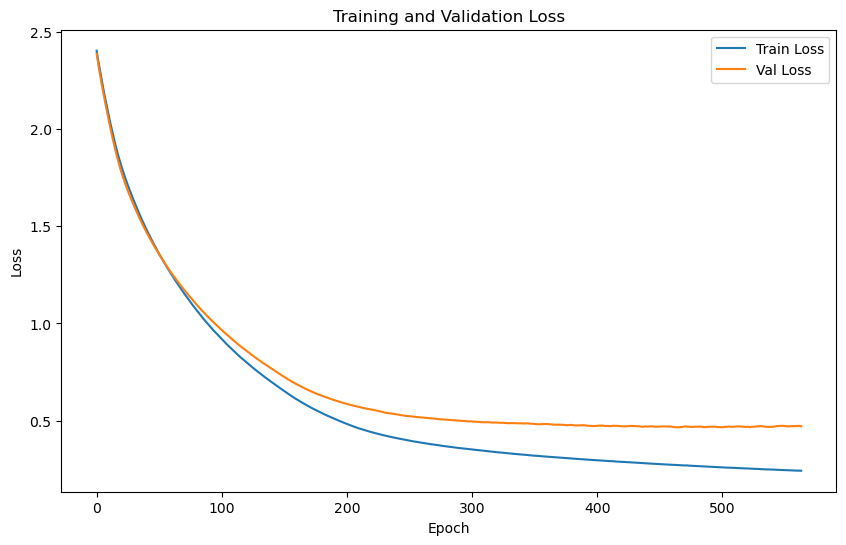

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.8269 | Test Accuracy: 69.97%


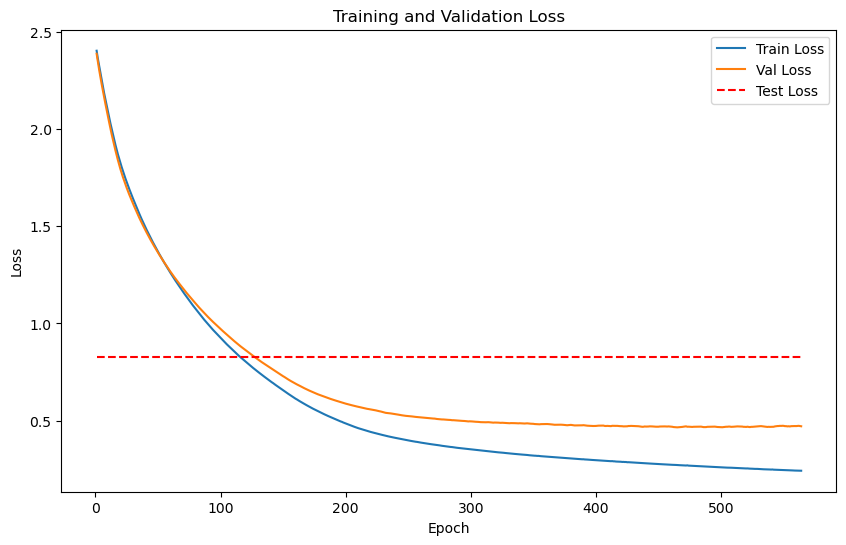

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 180 samples with 64 features each
LOG: Labels shape: (180,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42551 samples with 64 features each
LOG: Labels shape: (42551,)


Train embeddings shape: (180, 64), 
Train labels shape: (180,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42551, 64), 
Test labels shape: (42551,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4330
Epoch [1/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4330

Validation loss improved from inf to 0.4330. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4304
Epoch [2/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4304

Validation loss improved from 0.4330 to 0.4304. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [3/2000] - Validation


    Batch [1/1], Val Loss: 0.4281
Epoch [3/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4281

Validation loss improved from 0.4304 to 0.4281. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4651
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4262
Epoch [4/2000], Avg Train Loss: 0.4651, Avg Val Loss: 0.4262

Validation loss improved from 0.4281 to 0.4262. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4247
Epoch [5/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4247

Validation loss improved from 0.4262 to 0.4247. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.4238
Epoch [6/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4238

Validation loss improved from 0.4247 to 0.4238. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4582
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.4221
Epoch [7/2000], Avg Train Loss: 0.4582, Avg Val Loss: 0.4221

Validation loss improved from 0.4238 to 0.4221. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [8/2000] - Validation
    Batch [1/1], Val Loss: 0.4201
Epoch [8/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4201

Validation loss improved from 0.4221 to 0.4201. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4567
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4185
Epoch [9/2000], Avg Train Loss: 0.4567, Avg Val Loss: 0.4185

Validation loss improved from 0.4201 to 0.4185. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [10/2000] - Validation


    Batch [1/1], Val Loss: 0.4173
Epoch [10/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4173

Validation loss improved from 0.4185 to 0.4173. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [11/2000] - Validation


    Batch [1/1], Val Loss: 0.4159
Epoch [11/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4159

Validation loss improved from 0.4173 to 0.4159. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4148
Epoch [12/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4148

Validation loss improved from 0.4159 to 0.4148. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [13/2000] - Validation


    Batch [1/1], Val Loss: 0.4139
Epoch [13/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4139

Validation loss improved from 0.4148 to 0.4139. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.4556
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4130
Epoch [14/2000], Avg Train Loss: 0.4556, Avg Val Loss: 0.4130

Validation loss improved from 0.4139 to 0.4130. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [15/2000] - Validation


    Batch [1/1], Val Loss: 0.4119
Epoch [15/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4119

Validation loss improved from 0.4130 to 0.4119. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.4486
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.4113
Epoch [16/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4113

Validation loss improved from 0.4119 to 0.4113. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.4481
LOG: Epoch [17/2000] - Validation


    Batch [1/1], Val Loss: 0.4107
Epoch [17/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4107

Validation loss improved from 0.4113 to 0.4107. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4102
Epoch [18/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4102

Validation loss improved from 0.4107 to 0.4102. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [19/2000] - Validation


    Batch [1/1], Val Loss: 0.4096
Epoch [19/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4096

Validation loss improved from 0.4102 to 0.4096. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [20/2000] - Validation


    Batch [1/1], Val Loss: 0.4092
Epoch [20/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4092

Validation loss improved from 0.4096 to 0.4092. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4090
Epoch [21/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4090

Validation loss improved from 0.4092 to 0.4090. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4087
Epoch [22/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4087

Validation loss improved from 0.4090 to 0.4087. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4471
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.4084
Epoch [23/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4084

Validation loss improved from 0.4087 to 0.4084. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4081
Epoch [24/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.4081

Validation loss improved from 0.4084 to 0.4081. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [25/2000] - Validation


    Batch [1/1], Val Loss: 0.4078
Epoch [25/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4078

Validation loss improved from 0.4081 to 0.4078. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4075
Epoch [26/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4075

Validation loss improved from 0.4078 to 0.4075. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [27/2000] - Validation


    Batch [1/1], Val Loss: 0.4071
Epoch [27/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4071

Validation loss improved from 0.4075 to 0.4071. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4068
Epoch [28/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4068

Validation loss improved from 0.4071 to 0.4068. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4064
Epoch [29/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4064

Validation loss improved from 0.4068 to 0.4064. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.4060
Epoch [30/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.4060

Validation loss improved from 0.4064 to 0.4060. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4055
Epoch [31/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4055

Validation loss improved from 0.4060 to 0.4055. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [32/2000] - Validation


    Batch [1/1], Val Loss: 0.4050
Epoch [32/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4050

Validation loss improved from 0.4055 to 0.4050. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4045
Epoch [33/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.4045

Validation loss improved from 0.4050 to 0.4045. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4041
Epoch [34/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.4041

Validation loss improved from 0.4045 to 0.4041. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4036
Epoch [35/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4036

Validation loss improved from 0.4041 to 0.4036. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4031
Epoch [36/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.4031

Validation loss improved from 0.4036 to 0.4031. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.4026
Epoch [37/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.4026

Validation loss improved from 0.4031 to 0.4026. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4021
Epoch [38/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.4021

Validation loss improved from 0.4026 to 0.4021. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [39/2000] - Validation


    Batch [1/1], Val Loss: 0.4016
Epoch [39/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.4016

Validation loss improved from 0.4021 to 0.4016. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [40/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.4011

Validation loss improved from 0.4016 to 0.4011. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [41/2000] - Validation


    Batch [1/1], Val Loss: 0.4005
Epoch [41/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.4005

Validation loss improved from 0.4011 to 0.4005. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.4000
Epoch [42/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.4000

Validation loss improved from 0.4005 to 0.4000. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [43/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.3995

Validation loss improved from 0.4000 to 0.3995. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4298
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3990
Epoch [44/2000], Avg Train Loss: 0.4298, Avg Val Loss: 0.3990

Validation loss improved from 0.3995 to 0.3990. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3984
Epoch [45/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3984

Validation loss improved from 0.3990 to 0.3984. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4235
LOG: Epoch [46/2000] - Validation


    Batch [1/1], Val Loss: 0.3979
Epoch [46/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3979

Validation loss improved from 0.3984 to 0.3979. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4280
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3973
Epoch [47/2000], Avg Train Loss: 0.4280, Avg Val Loss: 0.3973

Validation loss improved from 0.3979 to 0.3973. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [48/2000] - Validation
    Batch [1/1], Val Loss: 0.3967
Epoch [48/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3967

Validation loss improved from 0.3973 to 0.3967. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3962
Epoch [49/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.3962

Validation loss improved from 0.3967 to 0.3962. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3956
Epoch [50/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3956

Validation loss improved from 0.3962 to 0.3956. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [51/2000] - Validation


    Batch [1/1], Val Loss: 0.3950
Epoch [51/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.3950

Validation loss improved from 0.3956 to 0.3950. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [52/2000] - Validation
    Batch [1/1], Val Loss: 0.3945
Epoch [52/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.3945

Validation loss improved from 0.3950 to 0.3945. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3939
Epoch [53/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3939

Validation loss improved from 0.3945 to 0.3939. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3934
Epoch [54/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.3934

Validation loss improved from 0.3939 to 0.3934. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3928
Epoch [55/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.3928

Validation loss improved from 0.3934 to 0.3928. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3923
Epoch [56/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.3923

Validation loss improved from 0.3928 to 0.3923. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3918
Epoch [57/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.3918

Validation loss improved from 0.3923 to 0.3918. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [58/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.3913

Validation loss improved from 0.3918 to 0.3913. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3908
Epoch [59/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3908

Validation loss improved from 0.3913 to 0.3908. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.3903
Epoch [60/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3903

Validation loss improved from 0.3908 to 0.3903. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3898
Epoch [61/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.3898

Validation loss improved from 0.3903 to 0.3898. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3893
Epoch [62/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.3893

Validation loss improved from 0.3898 to 0.3893. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [63/2000] - Validation


    Batch [1/1], Val Loss: 0.3888
Epoch [63/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3888

Validation loss improved from 0.3893 to 0.3888. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.3883
Epoch [64/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3883

Validation loss improved from 0.3888 to 0.3883. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3878
Epoch [65/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3878

Validation loss improved from 0.3883 to 0.3878. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [66/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.3873

Validation loss improved from 0.3878 to 0.3873. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3868
Epoch [67/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3868

Validation loss improved from 0.3873 to 0.3868. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3863
Epoch [68/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3863

Validation loss improved from 0.3868 to 0.3863. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3858
Epoch [69/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.3858

Validation loss improved from 0.3863 to 0.3858. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.3853
Epoch [70/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.3853

Validation loss improved from 0.3858 to 0.3853. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3848
Epoch [71/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3848

Validation loss improved from 0.3853 to 0.3848. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3843
Epoch [72/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3843

Validation loss improved from 0.3848 to 0.3843. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4071
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3839
Epoch [73/2000], Avg Train Loss: 0.4071, Avg Val Loss: 0.3839

Validation loss improved from 0.3843 to 0.3839. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3834
Epoch [74/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3834

Validation loss improved from 0.3839 to 0.3834. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [75/2000] - Validation


    Batch [1/1], Val Loss: 0.3830
Epoch [75/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.3830

Validation loss improved from 0.3834 to 0.3830. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3825
Epoch [76/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.3825

Validation loss improved from 0.3830 to 0.3825. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3821
Epoch [77/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3821

Validation loss improved from 0.3825 to 0.3821. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [78/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3817

Validation loss improved from 0.3821 to 0.3817. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3813
Epoch [79/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3813

Validation loss improved from 0.3817 to 0.3813. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [80/2000] - Validation


    Batch [1/1], Val Loss: 0.3809
Epoch [80/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3809

Validation loss improved from 0.3813 to 0.3809. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3805
Epoch [81/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3805

Validation loss improved from 0.3809 to 0.3805. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3800
Epoch [82/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3800

Validation loss improved from 0.3805 to 0.3800. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [83/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.3797

Validation loss improved from 0.3800 to 0.3797. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.3793
Epoch [84/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.3793

Validation loss improved from 0.3797 to 0.3793. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3789
Epoch [85/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.3789

Validation loss improved from 0.3793 to 0.3789. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3786
Epoch [86/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.3786

Validation loss improved from 0.3789 to 0.3786. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3782
Epoch [87/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3782

Validation loss improved from 0.3786 to 0.3782. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3779
Epoch [88/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3779

Validation loss improved from 0.3782 to 0.3779. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 0.3971
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [89/2000], Avg Train Loss: 0.3971, Avg Val Loss: 0.3775

Validation loss improved from 0.3779 to 0.3775. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3771
Epoch [90/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3771

Validation loss improved from 0.3775 to 0.3771. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.3768
Epoch [91/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.3768

Validation loss improved from 0.3771 to 0.3768. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/1], Train Loss: 0.4000
LOG: Epoch [92/2000] - Validation


    Batch [1/1], Val Loss: 0.3764
Epoch [92/2000], Avg Train Loss: 0.4000, Avg Val Loss: 0.3764

Validation loss improved from 0.3768 to 0.3764. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3760
Epoch [93/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.3760

Validation loss improved from 0.3764 to 0.3760. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3756
Epoch [94/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3756

Validation loss improved from 0.3760 to 0.3756. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.3999
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3752
Epoch [95/2000], Avg Train Loss: 0.3999, Avg Val Loss: 0.3752

Validation loss improved from 0.3756 to 0.3752. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [96/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.3749

Validation loss improved from 0.3752 to 0.3749. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [97/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.3745

Validation loss improved from 0.3749 to 0.3745. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3742
Epoch [98/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.3742

Validation loss improved from 0.3745 to 0.3742. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3738
Epoch [99/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3738

Validation loss improved from 0.3742 to 0.3738. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3735
Epoch [100/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3735

Validation loss improved from 0.3738 to 0.3735. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [101/2000] - Validation


    Batch [1/1], Val Loss: 0.3731
Epoch [101/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.3731

Validation loss improved from 0.3735 to 0.3731. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3728
Epoch [102/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3728

Validation loss improved from 0.3731 to 0.3728. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [103/2000] - Validation


    Batch [1/1], Val Loss: 0.3725
Epoch [103/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3725

Validation loss improved from 0.3728 to 0.3725. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3721
Epoch [104/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.3721

Validation loss improved from 0.3725 to 0.3721. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [105/2000] - Validation


    Batch [1/1], Val Loss: 0.3718
Epoch [105/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.3718

Validation loss improved from 0.3721 to 0.3718. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [106/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3715

Validation loss improved from 0.3718 to 0.3715. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.3712
Epoch [107/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.3712

Validation loss improved from 0.3715 to 0.3712. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [108/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3708

Validation loss improved from 0.3712 to 0.3708. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3705
Epoch [109/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3705

Validation loss improved from 0.3708 to 0.3705. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.3701
Epoch [110/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.3701

Validation loss improved from 0.3705 to 0.3701. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3698
Epoch [111/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3698

Validation loss improved from 0.3701 to 0.3698. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [112/2000] - Validation


    Batch [1/1], Val Loss: 0.3694
Epoch [112/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.3694

Validation loss improved from 0.3698 to 0.3694. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3691
Epoch [113/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.3691

Validation loss improved from 0.3694 to 0.3691. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3687
Epoch [114/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.3687

Validation loss improved from 0.3691 to 0.3687. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [115/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3684

Validation loss improved from 0.3687 to 0.3684. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [116/2000] - Validation


    Batch [1/1], Val Loss: 0.3680
Epoch [116/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3680

Validation loss improved from 0.3684 to 0.3680. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3677
Epoch [117/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3677

Validation loss improved from 0.3680 to 0.3677. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.3867
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3673
Epoch [118/2000], Avg Train Loss: 0.3867, Avg Val Loss: 0.3673

Validation loss improved from 0.3677 to 0.3673. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3670
Epoch [119/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3670

Validation loss improved from 0.3673 to 0.3670. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3667
Epoch [120/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3667

Validation loss improved from 0.3670 to 0.3667. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3663
Epoch [121/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.3663

Validation loss improved from 0.3667 to 0.3663. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3660
Epoch [122/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3660

Validation loss improved from 0.3663 to 0.3660. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.3847
LOG: Epoch [123/2000] - Validation


    Batch [1/1], Val Loss: 0.3657
Epoch [123/2000], Avg Train Loss: 0.3847, Avg Val Loss: 0.3657

Validation loss improved from 0.3660 to 0.3657. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.3654
Epoch [124/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3654

Validation loss improved from 0.3657 to 0.3654. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [125/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3651

Validation loss improved from 0.3654 to 0.3651. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3648
Epoch [126/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3648

Validation loss improved from 0.3651 to 0.3648. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [127/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.3645

Validation loss improved from 0.3648 to 0.3645. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.3641
Epoch [128/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3641

Validation loss improved from 0.3645 to 0.3641. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [129/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.3638

Validation loss improved from 0.3641 to 0.3638. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 0.3799
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [130/2000], Avg Train Loss: 0.3799, Avg Val Loss: 0.3635

Validation loss improved from 0.3638 to 0.3635. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3632
Epoch [131/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3632

Validation loss improved from 0.3635 to 0.3632. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [132/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.3629

Validation loss improved from 0.3632 to 0.3629. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3626
Epoch [133/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3626

Validation loss improved from 0.3629 to 0.3626. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [134/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3622

Validation loss improved from 0.3626 to 0.3622. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3619
Epoch [135/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.3619

Validation loss improved from 0.3622 to 0.3619. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3616
Epoch [136/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3616

Validation loss improved from 0.3619 to 0.3616. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.3613
Epoch [137/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.3613

Validation loss improved from 0.3616 to 0.3613. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.3768
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [138/2000], Avg Train Loss: 0.3768, Avg Val Loss: 0.3610

Validation loss improved from 0.3613 to 0.3610. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [139/2000] - Validation


    Batch [1/1], Val Loss: 0.3606
Epoch [139/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.3606

Validation loss improved from 0.3610 to 0.3606. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [140/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3603

Validation loss improved from 0.3606 to 0.3603. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [141/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3600

Validation loss improved from 0.3603 to 0.3600. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3596
Epoch [142/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.3596

Validation loss improved from 0.3600 to 0.3596. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3593
Epoch [143/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.3593

Validation loss improved from 0.3596 to 0.3593. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3590
Epoch [144/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.3590

Validation loss improved from 0.3593 to 0.3590. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [145/2000] - Validation


    Batch [1/1], Val Loss: 0.3587
Epoch [145/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3587

Validation loss improved from 0.3590 to 0.3587. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [146/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.3583

Validation loss improved from 0.3587 to 0.3583. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.3725
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3580
Epoch [147/2000], Avg Train Loss: 0.3725, Avg Val Loss: 0.3580

Validation loss improved from 0.3583 to 0.3580. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [148/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3577

Validation loss improved from 0.3580 to 0.3577. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3574
Epoch [149/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.3574

Validation loss improved from 0.3577 to 0.3574. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [150/2000] - Validation


    Batch [1/1], Val Loss: 0.3571
Epoch [150/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3571

Validation loss improved from 0.3574 to 0.3571. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.3568
Epoch [151/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3568

Validation loss improved from 0.3571 to 0.3568. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3564
Epoch [152/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.3564

Validation loss improved from 0.3568 to 0.3564. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [153/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.3561

Validation loss improved from 0.3564 to 0.3561. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3558
Epoch [154/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.3558

Validation loss improved from 0.3561 to 0.3558. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [155/2000] - Validation


    Batch [1/1], Val Loss: 0.3555
Epoch [155/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.3555

Validation loss improved from 0.3558 to 0.3555. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.3552
Epoch [156/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3552

Validation loss improved from 0.3555 to 0.3552. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3548
Epoch [157/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3548

Validation loss improved from 0.3552 to 0.3548. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [158/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3545

Validation loss improved from 0.3548 to 0.3545. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3542
Epoch [159/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.3542

Validation loss improved from 0.3545 to 0.3542. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3539
Epoch [160/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3539

Validation loss improved from 0.3542 to 0.3539. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3536
Epoch [161/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3536

Validation loss improved from 0.3539 to 0.3536. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [162/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3532

Validation loss improved from 0.3536 to 0.3532. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [163/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3529

Validation loss improved from 0.3532 to 0.3529. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.3676
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [164/2000], Avg Train Loss: 0.3676, Avg Val Loss: 0.3526

Validation loss improved from 0.3529 to 0.3526. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.3524
Epoch [165/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3524

Validation loss improved from 0.3526 to 0.3524. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [166/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.3521

Validation loss improved from 0.3524 to 0.3521. Saving model...
LOG: Epoch [167/2000] - Training
    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3518
Epoch [167/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3518

Validation loss improved from 0.3521 to 0.3518. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3515
Epoch [168/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.3515

Validation loss improved from 0.3518 to 0.3515. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [169/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3513

Validation loss improved from 0.3515 to 0.3513. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3510
Epoch [170/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.3510

Validation loss improved from 0.3513 to 0.3510. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [171/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3508

Validation loss improved from 0.3510 to 0.3508. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [172/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.3505

Validation loss improved from 0.3508 to 0.3505. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3502
Epoch [173/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3502

Validation loss improved from 0.3505 to 0.3502. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3500
Epoch [174/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3500

Validation loss improved from 0.3502 to 0.3500. Saving model...
LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [175/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3498

Validation loss improved from 0.3500 to 0.3498. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3495
Epoch [176/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.3495

Validation loss improved from 0.3498 to 0.3495. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [177/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3492

Validation loss improved from 0.3495 to 0.3492. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [178/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3487
Epoch [179/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3487

Validation loss improved from 0.3490 to 0.3487. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [180/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3484

Validation loss improved from 0.3487 to 0.3484. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [181/2000] - Validation


    Batch [1/1], Val Loss: 0.3481
Epoch [181/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3481

Validation loss improved from 0.3484 to 0.3481. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3478
Epoch [182/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.3478

Validation loss improved from 0.3481 to 0.3478. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [183/2000] - Validation


    Batch [1/1], Val Loss: 0.3475
Epoch [183/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.3475

Validation loss improved from 0.3478 to 0.3475. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3472
Epoch [184/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.3472

Validation loss improved from 0.3475 to 0.3472. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [185/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3469

Validation loss improved from 0.3472 to 0.3469. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3467
Epoch [186/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.3467

Validation loss improved from 0.3469 to 0.3467. Saving model...
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3464
Epoch [187/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3464

Validation loss improved from 0.3467 to 0.3464. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [188/2000] - Validation


    Batch [1/1], Val Loss: 0.3461
Epoch [188/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3461

Validation loss improved from 0.3464 to 0.3461. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [189/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [190/2000] - Validation


    Batch [1/1], Val Loss: 0.3455
Epoch [190/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3455

Validation loss improved from 0.3458 to 0.3455. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [191/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.3452

Validation loss improved from 0.3455 to 0.3452. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3449
Epoch [192/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3449

Validation loss improved from 0.3452 to 0.3449. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3447
Epoch [193/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.3447

Validation loss improved from 0.3449 to 0.3447. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3444
Epoch [194/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3444

Validation loss improved from 0.3447 to 0.3444. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.3615
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.3441
Epoch [195/2000], Avg Train Loss: 0.3615, Avg Val Loss: 0.3441

Validation loss improved from 0.3444 to 0.3441. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3439
Epoch [196/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.3439

Validation loss improved from 0.3441 to 0.3439. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [197/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3437

Validation loss improved from 0.3439 to 0.3437. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [198/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [199/2000] - Validation


    Batch [1/1], Val Loss: 0.3433
Epoch [199/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.3433

Validation loss improved from 0.3435 to 0.3433. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [200/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3431

Validation loss improved from 0.3433 to 0.3431. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [201/2000] - Validation


    Batch [1/1], Val Loss: 0.3429
Epoch [201/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.3429

Validation loss improved from 0.3431 to 0.3429. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [202/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3427

Validation loss improved from 0.3429 to 0.3427. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [203/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [203/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3424

Validation loss improved from 0.3427 to 0.3424. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [204/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.3422

Validation loss improved from 0.3424 to 0.3422. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [205/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3420

Validation loss improved from 0.3422 to 0.3420. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [206/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3418

Validation loss improved from 0.3420 to 0.3418. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [207/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.3416

Validation loss improved from 0.3418 to 0.3416. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [208/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3414

Validation loss improved from 0.3416 to 0.3414. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [209/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.3412

Validation loss improved from 0.3414 to 0.3412. Saving model...
LOG: Epoch [210/2000] - Training
    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3410
Epoch [210/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3410

Validation loss improved from 0.3412 to 0.3410. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [211/2000] - Validation


    Batch [1/1], Val Loss: 0.3408
Epoch [211/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3408

Validation loss improved from 0.3410 to 0.3408. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [212/2000] - Validation
    Batch [1/1], Val Loss: 0.3405
Epoch [212/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.3405

Validation loss improved from 0.3408 to 0.3405. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3403
Epoch [213/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3403

Validation loss improved from 0.3405 to 0.3403. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3401
Epoch [214/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.3401

Validation loss improved from 0.3403 to 0.3401. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3399
Epoch [215/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.3399

Validation loss improved from 0.3401 to 0.3399. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.3397
Epoch [216/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3397

Validation loss improved from 0.3399 to 0.3397. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3395
Epoch [217/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3395

Validation loss improved from 0.3397 to 0.3395. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [218/2000] - Validation


    Batch [1/1], Val Loss: 0.3393
Epoch [218/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.3393

Validation loss improved from 0.3395 to 0.3393. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3391
Epoch [219/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3391

Validation loss improved from 0.3393 to 0.3391. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.3388
Epoch [220/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3388

Validation loss improved from 0.3391 to 0.3388. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.3415
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3386
Epoch [221/2000], Avg Train Loss: 0.3415, Avg Val Loss: 0.3386

Validation loss improved from 0.3388 to 0.3386. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3384
Epoch [222/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3384

Validation loss improved from 0.3386 to 0.3384. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [223/2000] - Validation


    Batch [1/1], Val Loss: 0.3382
Epoch [223/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3382

Validation loss improved from 0.3384 to 0.3382. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [224/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3379

Validation loss improved from 0.3382 to 0.3379. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [225/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3377

Validation loss improved from 0.3379 to 0.3377. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [226/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3375

Validation loss improved from 0.3377 to 0.3375. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [227/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.3373

Validation loss improved from 0.3375 to 0.3373. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [228/2000] - Validation


    Batch [1/1], Val Loss: 0.3370
Epoch [228/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3370

Validation loss improved from 0.3373 to 0.3370. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [229/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3367

Validation loss improved from 0.3370 to 0.3367. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [230/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3365

Validation loss improved from 0.3367 to 0.3365. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3362
Epoch [231/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3362

Validation loss improved from 0.3365 to 0.3362. Saving model...
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [232/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3360

Validation loss improved from 0.3362 to 0.3360. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.3388
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3358
Epoch [233/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3358

Validation loss improved from 0.3360 to 0.3358. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [234/2000] - Validation
    Batch [1/1], Val Loss: 0.3355
Epoch [234/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3355

Validation loss improved from 0.3358 to 0.3355. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.3391
LOG: Epoch [235/2000] - Validation


    Batch [1/1], Val Loss: 0.3353
Epoch [235/2000], Avg Train Loss: 0.3391, Avg Val Loss: 0.3353

Validation loss improved from 0.3355 to 0.3353. Saving model...
LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 0.3394
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [236/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3351

Validation loss improved from 0.3353 to 0.3351. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [237/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.3348

Validation loss improved from 0.3351 to 0.3348. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [238/2000] - Validation
    Batch [1/1], Val Loss: 0.3346
Epoch [238/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3346

Validation loss improved from 0.3348 to 0.3346. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [239/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3344

Validation loss improved from 0.3346 to 0.3344. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 0.3429
LOG: Epoch [240/2000] - Validation


    Batch [1/1], Val Loss: 0.3341
Epoch [240/2000], Avg Train Loss: 0.3429, Avg Val Loss: 0.3341

Validation loss improved from 0.3344 to 0.3341. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [241/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3339

Validation loss improved from 0.3341 to 0.3339. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.3396
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [242/2000], Avg Train Loss: 0.3396, Avg Val Loss: 0.3337

Validation loss improved from 0.3339 to 0.3337. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.3387
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [243/2000], Avg Train Loss: 0.3387, Avg Val Loss: 0.3335

Validation loss improved from 0.3337 to 0.3335. Saving model...
LOG: Epoch [244/2000] - Training
    Batch [1/1], Train Loss: 0.3371
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [244/2000], Avg Train Loss: 0.3371, Avg Val Loss: 0.3333

Validation loss improved from 0.3335 to 0.3333. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [245/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3332

Validation loss improved from 0.3333 to 0.3332. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.3402
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [246/2000], Avg Train Loss: 0.3402, Avg Val Loss: 0.3330

Validation loss improved from 0.3332 to 0.3330. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 0.3366
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.3329
Epoch [247/2000], Avg Train Loss: 0.3366, Avg Val Loss: 0.3329

Validation loss improved from 0.3330 to 0.3329. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [248/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3327

Validation loss improved from 0.3329 to 0.3327. Saving model...
LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 0.3317
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [249/2000], Avg Train Loss: 0.3317, Avg Val Loss: 0.3326

Validation loss improved from 0.3327 to 0.3326. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [250/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3324

Validation loss improved from 0.3326 to 0.3324. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.3361
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [251/2000], Avg Train Loss: 0.3361, Avg Val Loss: 0.3322

Validation loss improved from 0.3324 to 0.3322. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.3378
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3321
Epoch [252/2000], Avg Train Loss: 0.3378, Avg Val Loss: 0.3321

Validation loss improved from 0.3322 to 0.3321. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 0.3382
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [253/2000], Avg Train Loss: 0.3382, Avg Val Loss: 0.3319

Validation loss improved from 0.3321 to 0.3319. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [254/2000] - Validation


    Batch [1/1], Val Loss: 0.3318
Epoch [254/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3318

Validation loss improved from 0.3319 to 0.3318. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [255/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3317

Validation loss improved from 0.3318 to 0.3317. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3317
Epoch [256/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3317

Validation loss improved from 0.3317 to 0.3317. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.3335
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [257/2000], Avg Train Loss: 0.3335, Avg Val Loss: 0.3316

Validation loss improved from 0.3317 to 0.3316. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.3376
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3316
Epoch [258/2000], Avg Train Loss: 0.3376, Avg Val Loss: 0.3316

Validation loss improved from 0.3316 to 0.3316. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.3337
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.3315
Epoch [259/2000], Avg Train Loss: 0.3337, Avg Val Loss: 0.3315

Validation loss improved from 0.3316 to 0.3315. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/1], Train Loss: 0.3301
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3314
Epoch [260/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3314

Validation loss improved from 0.3315 to 0.3314. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/1], Train Loss: 0.3353
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3313
Epoch [261/2000], Avg Train Loss: 0.3353, Avg Val Loss: 0.3313

Validation loss improved from 0.3314 to 0.3313. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.3299
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.3312
Epoch [262/2000], Avg Train Loss: 0.3299, Avg Val Loss: 0.3312

Validation loss improved from 0.3313 to 0.3312. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/1], Train Loss: 0.3326
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3310
Epoch [263/2000], Avg Train Loss: 0.3326, Avg Val Loss: 0.3310

Validation loss improved from 0.3312 to 0.3310. Saving model...
LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [264/2000] - Validation


    Batch [1/1], Val Loss: 0.3309
Epoch [264/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3309

Validation loss improved from 0.3310 to 0.3309. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.3318
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3307
Epoch [265/2000], Avg Train Loss: 0.3318, Avg Val Loss: 0.3307

Validation loss improved from 0.3309 to 0.3307. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.3345
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3305
Epoch [266/2000], Avg Train Loss: 0.3345, Avg Val Loss: 0.3305

Validation loss improved from 0.3307 to 0.3305. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3303
Epoch [267/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3303

Validation loss improved from 0.3305 to 0.3303. Saving model...
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.3304
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3301
Epoch [268/2000], Avg Train Loss: 0.3304, Avg Val Loss: 0.3301

Validation loss improved from 0.3303 to 0.3301. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.3316
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3298
Epoch [269/2000], Avg Train Loss: 0.3316, Avg Val Loss: 0.3298

Validation loss improved from 0.3301 to 0.3298. Saving model...
LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 0.3314
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3296
Epoch [270/2000], Avg Train Loss: 0.3314, Avg Val Loss: 0.3296

Validation loss improved from 0.3298 to 0.3296. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.3332
LOG: Epoch [271/2000] - Validation


    Batch [1/1], Val Loss: 0.3294
Epoch [271/2000], Avg Train Loss: 0.3332, Avg Val Loss: 0.3294

Validation loss improved from 0.3296 to 0.3294. Saving model...
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.3292
Epoch [272/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3292

Validation loss improved from 0.3294 to 0.3292. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [273/2000] - Validation


    Batch [1/1], Val Loss: 0.3289
Epoch [273/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3289

Validation loss improved from 0.3292 to 0.3289. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 0.3278
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3287
Epoch [274/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.3287

Validation loss improved from 0.3289 to 0.3287. Saving model...
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.3294
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3284
Epoch [275/2000], Avg Train Loss: 0.3294, Avg Val Loss: 0.3284

Validation loss improved from 0.3287 to 0.3284. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.3320
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.3281
Epoch [276/2000], Avg Train Loss: 0.3320, Avg Val Loss: 0.3281

Validation loss improved from 0.3284 to 0.3281. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.3255
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3278
Epoch [277/2000], Avg Train Loss: 0.3255, Avg Val Loss: 0.3278

Validation loss improved from 0.3281 to 0.3278. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.3234
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3275
Epoch [278/2000], Avg Train Loss: 0.3234, Avg Val Loss: 0.3275

Validation loss improved from 0.3278 to 0.3275. Saving model...
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3272
Epoch [279/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3272

Validation loss improved from 0.3275 to 0.3272. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.3270
Epoch [280/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3270

Validation loss improved from 0.3272 to 0.3270. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 0.3248
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3267
Epoch [281/2000], Avg Train Loss: 0.3248, Avg Val Loss: 0.3267

Validation loss improved from 0.3270 to 0.3267. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.3281
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3265
Epoch [282/2000], Avg Train Loss: 0.3281, Avg Val Loss: 0.3265

Validation loss improved from 0.3267 to 0.3265. Saving model...
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.3244
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3262
Epoch [283/2000], Avg Train Loss: 0.3244, Avg Val Loss: 0.3262

Validation loss improved from 0.3265 to 0.3262. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.3279
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.3261
Epoch [284/2000], Avg Train Loss: 0.3279, Avg Val Loss: 0.3261

Validation loss improved from 0.3262 to 0.3261. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/1], Train Loss: 0.3280
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3259
Epoch [285/2000], Avg Train Loss: 0.3280, Avg Val Loss: 0.3259

Validation loss improved from 0.3261 to 0.3259. Saving model...
LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 0.3204
LOG: Epoch [286/2000] - Validation


    Batch [1/1], Val Loss: 0.3257
Epoch [286/2000], Avg Train Loss: 0.3204, Avg Val Loss: 0.3257

Validation loss improved from 0.3259 to 0.3257. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 0.3201
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3256
Epoch [287/2000], Avg Train Loss: 0.3201, Avg Val Loss: 0.3256

Validation loss improved from 0.3257 to 0.3256. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [288/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.3255

Validation loss improved from 0.3256 to 0.3255. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3253
Epoch [289/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3253

Validation loss improved from 0.3255 to 0.3253. Saving model...
LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 0.3236
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3252
Epoch [290/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.3252

Validation loss improved from 0.3253 to 0.3252. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.3229
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.3251
Epoch [291/2000], Avg Train Loss: 0.3229, Avg Val Loss: 0.3251

Validation loss improved from 0.3252 to 0.3251. Saving model...
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.3254
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3250
Epoch [292/2000], Avg Train Loss: 0.3254, Avg Val Loss: 0.3250

Validation loss improved from 0.3251 to 0.3250. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [293/2000] - Validation


    Batch [1/1], Val Loss: 0.3249
Epoch [293/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3249

Validation loss improved from 0.3250 to 0.3249. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 0.3232
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3247
Epoch [294/2000], Avg Train Loss: 0.3232, Avg Val Loss: 0.3247

Validation loss improved from 0.3249 to 0.3247. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.3216
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3246
Epoch [295/2000], Avg Train Loss: 0.3216, Avg Val Loss: 0.3246

Validation loss improved from 0.3247 to 0.3246. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.3140
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3244
Epoch [296/2000], Avg Train Loss: 0.3140, Avg Val Loss: 0.3244

Validation loss improved from 0.3246 to 0.3244. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 0.3241
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3243
Epoch [297/2000], Avg Train Loss: 0.3241, Avg Val Loss: 0.3243

Validation loss improved from 0.3244 to 0.3243. Saving model...
LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 0.3224
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3241
Epoch [298/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3241

Validation loss improved from 0.3243 to 0.3241. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3240
Epoch [299/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3240

Validation loss improved from 0.3241 to 0.3240. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.3249
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [300/2000], Avg Train Loss: 0.3249, Avg Val Loss: 0.3238

Validation loss improved from 0.3240 to 0.3238. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.3188
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3237
Epoch [301/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.3237

Validation loss improved from 0.3238 to 0.3237. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 0.3202
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3235
Epoch [302/2000], Avg Train Loss: 0.3202, Avg Val Loss: 0.3235

Validation loss improved from 0.3237 to 0.3235. Saving model...
LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [303/2000] - Validation


    Batch [1/1], Val Loss: 0.3234
Epoch [303/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3234

Validation loss improved from 0.3235 to 0.3234. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.3167
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3233
Epoch [304/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3233

Validation loss improved from 0.3234 to 0.3233. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.3147
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3232
Epoch [305/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3232

Validation loss improved from 0.3233 to 0.3232. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3232
Epoch [306/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3232

Validation loss improved from 0.3232 to 0.3232. Saving model...
LOG: Epoch [307/2000] - Training
    Batch [1/1], Train Loss: 0.3165
LOG: Epoch [307/2000] - Validation


    Batch [1/1], Val Loss: 0.3231
Epoch [307/2000], Avg Train Loss: 0.3165, Avg Val Loss: 0.3231

Validation loss improved from 0.3232 to 0.3231. Saving model...
LOG: Epoch [308/2000] - Training
    Batch [1/1], Train Loss: 0.3182
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3229
Epoch [308/2000], Avg Train Loss: 0.3182, Avg Val Loss: 0.3229

Validation loss improved from 0.3231 to 0.3229. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 0.3173
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3228
Epoch [309/2000], Avg Train Loss: 0.3173, Avg Val Loss: 0.3228

Validation loss improved from 0.3229 to 0.3228. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.3158
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3227
Epoch [310/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3227

Validation loss improved from 0.3228 to 0.3227. Saving model...
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.3225
Epoch [311/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3225

Validation loss improved from 0.3227 to 0.3225. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.3203
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3223
Epoch [312/2000], Avg Train Loss: 0.3203, Avg Val Loss: 0.3223

Validation loss improved from 0.3225 to 0.3223. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3221
Epoch [313/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3221

Validation loss improved from 0.3223 to 0.3221. Saving model...
LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.3219
Epoch [314/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3219

Validation loss improved from 0.3221 to 0.3219. Saving model...
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.3197
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3217
Epoch [315/2000], Avg Train Loss: 0.3197, Avg Val Loss: 0.3217

Validation loss improved from 0.3219 to 0.3217. Saving model...
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.3208
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3215
Epoch [316/2000], Avg Train Loss: 0.3208, Avg Val Loss: 0.3215

Validation loss improved from 0.3217 to 0.3215. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.3174
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3213
Epoch [317/2000], Avg Train Loss: 0.3174, Avg Val Loss: 0.3213

Validation loss improved from 0.3215 to 0.3213. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/1], Train Loss: 0.3171
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3212
Epoch [318/2000], Avg Train Loss: 0.3171, Avg Val Loss: 0.3212

Validation loss improved from 0.3213 to 0.3212. Saving model...
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.3156
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3211
Epoch [319/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3211

Validation loss improved from 0.3212 to 0.3211. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.3160
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3209
Epoch [320/2000], Avg Train Loss: 0.3160, Avg Val Loss: 0.3209

Validation loss improved from 0.3211 to 0.3209. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.3154
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3207
Epoch [321/2000], Avg Train Loss: 0.3154, Avg Val Loss: 0.3207

Validation loss improved from 0.3209 to 0.3207. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 0.3164
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3206
Epoch [322/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3206

Validation loss improved from 0.3207 to 0.3206. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.3176
LOG: Epoch [323/2000] - Validation


    Batch [1/1], Val Loss: 0.3204
Epoch [323/2000], Avg Train Loss: 0.3176, Avg Val Loss: 0.3204

Validation loss improved from 0.3206 to 0.3204. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.3105
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3203
Epoch [324/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.3203

Validation loss improved from 0.3204 to 0.3203. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3202
Epoch [325/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3202

Validation loss improved from 0.3203 to 0.3202. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.3110
LOG: Epoch [326/2000] - Validation
    Batch [1/1], Val Loss: 0.3201
Epoch [326/2000], Avg Train Loss: 0.3110, Avg Val Loss: 0.3201

Validation loss improved from 0.3202 to 0.3201. Saving model...
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.3141
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [327/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.3200

Validation loss improved from 0.3201 to 0.3200. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.3157
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3200
Epoch [328/2000], Avg Train Loss: 0.3157, Avg Val Loss: 0.3200

Validation loss improved from 0.3200 to 0.3200. Saving model...
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.3075
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3199
Epoch [329/2000], Avg Train Loss: 0.3075, Avg Val Loss: 0.3199

Validation loss improved from 0.3200 to 0.3199. Saving model...
LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 0.3136
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.3198
Epoch [330/2000], Avg Train Loss: 0.3136, Avg Val Loss: 0.3198

Validation loss improved from 0.3199 to 0.3198. Saving model...
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.3116
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3198
Epoch [331/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3198

Validation loss improved from 0.3198 to 0.3198. Saving model...
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.3078
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3197
Epoch [332/2000], Avg Train Loss: 0.3078, Avg Val Loss: 0.3197

Validation loss improved from 0.3198 to 0.3197. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.3097
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3195
Epoch [333/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.3195

Validation loss improved from 0.3197 to 0.3195. Saving model...
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.3145
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3194
Epoch [334/2000], Avg Train Loss: 0.3145, Avg Val Loss: 0.3194

Validation loss improved from 0.3195 to 0.3194. Saving model...
LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 0.3112
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.3193
Epoch [335/2000], Avg Train Loss: 0.3112, Avg Val Loss: 0.3193

Validation loss improved from 0.3194 to 0.3193. Saving model...
LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 0.3098
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3191
Epoch [336/2000], Avg Train Loss: 0.3098, Avg Val Loss: 0.3191

Validation loss improved from 0.3193 to 0.3191. Saving model...
LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 0.3057
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3189
Epoch [337/2000], Avg Train Loss: 0.3057, Avg Val Loss: 0.3189

Validation loss improved from 0.3191 to 0.3189. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.3125
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3187
Epoch [338/2000], Avg Train Loss: 0.3125, Avg Val Loss: 0.3187

Validation loss improved from 0.3189 to 0.3187. Saving model...
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.3138
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3185
Epoch [339/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3185

Validation loss improved from 0.3187 to 0.3185. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3184
Epoch [340/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3184

Validation loss improved from 0.3185 to 0.3184. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 0.3034
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3182
Epoch [341/2000], Avg Train Loss: 0.3034, Avg Val Loss: 0.3182

Validation loss improved from 0.3184 to 0.3182. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.3073
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3180
Epoch [342/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3180

Validation loss improved from 0.3182 to 0.3180. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.3068
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3179
Epoch [343/2000], Avg Train Loss: 0.3068, Avg Val Loss: 0.3179

Validation loss improved from 0.3180 to 0.3179. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 0.3102
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3178
Epoch [344/2000], Avg Train Loss: 0.3102, Avg Val Loss: 0.3178

Validation loss improved from 0.3179 to 0.3178. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.3043
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.3177
Epoch [345/2000], Avg Train Loss: 0.3043, Avg Val Loss: 0.3177

Validation loss improved from 0.3178 to 0.3177. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.3126
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [346/2000], Avg Train Loss: 0.3126, Avg Val Loss: 0.3176

Validation loss improved from 0.3177 to 0.3176. Saving model...
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.3099
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [347/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3176

Validation loss improved from 0.3176 to 0.3176. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3111
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [348/2000], Avg Train Loss: 0.3111, Avg Val Loss: 0.3176

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 0.3117
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [349/2000], Avg Train Loss: 0.3117, Avg Val Loss: 0.3176

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.3038
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3176
Epoch [350/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3176

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.3100
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [351/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.3176

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.3066
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3176
Epoch [352/2000], Avg Train Loss: 0.3066, Avg Val Loss: 0.3176

Validation loss improved from 0.3176 to 0.3176. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.3155
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [353/2000], Avg Train Loss: 0.3155, Avg Val Loss: 0.3175

Validation loss improved from 0.3176 to 0.3175. Saving model...
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.3063
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [354/2000], Avg Train Loss: 0.3063, Avg Val Loss: 0.3175

Validation loss improved from 0.3175 to 0.3175. Saving model...
LOG: Epoch [355/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [355/2000] - Validation


    Batch [1/1], Val Loss: 0.3174
Epoch [355/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3174

Validation loss improved from 0.3175 to 0.3174. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/1], Train Loss: 0.3070
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3173
Epoch [356/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3173

Validation loss improved from 0.3174 to 0.3173. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.3047
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.3172
Epoch [357/2000], Avg Train Loss: 0.3047, Avg Val Loss: 0.3172

Validation loss improved from 0.3173 to 0.3172. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.3023
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3170
Epoch [358/2000], Avg Train Loss: 0.3023, Avg Val Loss: 0.3170

Validation loss improved from 0.3172 to 0.3170. Saving model...
LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 0.2993
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3169
Epoch [359/2000], Avg Train Loss: 0.2993, Avg Val Loss: 0.3169

Validation loss improved from 0.3170 to 0.3169. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3000
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3167
Epoch [360/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.3167

Validation loss improved from 0.3169 to 0.3167. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.3165
Epoch [361/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3165

Validation loss improved from 0.3167 to 0.3165. Saving model...
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.3065
LOG: Epoch [362/2000] - Validation


    Batch [1/1], Val Loss: 0.3162
Epoch [362/2000], Avg Train Loss: 0.3065, Avg Val Loss: 0.3162

Validation loss improved from 0.3165 to 0.3162. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.3079
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [363/2000], Avg Train Loss: 0.3079, Avg Val Loss: 0.3160

Validation loss improved from 0.3162 to 0.3160. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3157
Epoch [364/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3157

Validation loss improved from 0.3160 to 0.3157. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3002
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.3155
Epoch [365/2000], Avg Train Loss: 0.3002, Avg Val Loss: 0.3155

Validation loss improved from 0.3157 to 0.3155. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 0.3009
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3152
Epoch [366/2000], Avg Train Loss: 0.3009, Avg Val Loss: 0.3152

Validation loss improved from 0.3155 to 0.3152. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3150
Epoch [367/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.3150

Validation loss improved from 0.3152 to 0.3150. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.3012
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3148
Epoch [368/2000], Avg Train Loss: 0.3012, Avg Val Loss: 0.3148

Validation loss improved from 0.3150 to 0.3148. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.2977
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.3146
Epoch [369/2000], Avg Train Loss: 0.2977, Avg Val Loss: 0.3146

Validation loss improved from 0.3148 to 0.3146. Saving model...
LOG: Epoch [370/2000] - Training
    Batch [1/1], Train Loss: 0.2982
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3143
Epoch [370/2000], Avg Train Loss: 0.2982, Avg Val Loss: 0.3143

Validation loss improved from 0.3146 to 0.3143. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [371/2000] - Validation


    Batch [1/1], Val Loss: 0.3141
Epoch [371/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3141

Validation loss improved from 0.3143 to 0.3141. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3140
Epoch [372/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3140

Validation loss improved from 0.3141 to 0.3140. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.2974
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.3138
Epoch [373/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.3138

Validation loss improved from 0.3140 to 0.3138. Saving model...
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.3030
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3136
Epoch [374/2000], Avg Train Loss: 0.3030, Avg Val Loss: 0.3136

Validation loss improved from 0.3138 to 0.3136. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.3018
LOG: Epoch [375/2000] - Validation


    Batch [1/1], Val Loss: 0.3135
Epoch [375/2000], Avg Train Loss: 0.3018, Avg Val Loss: 0.3135

Validation loss improved from 0.3136 to 0.3135. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 0.2965
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3133
Epoch [376/2000], Avg Train Loss: 0.2965, Avg Val Loss: 0.3133

Validation loss improved from 0.3135 to 0.3133. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.3016
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.3131
Epoch [377/2000], Avg Train Loss: 0.3016, Avg Val Loss: 0.3131

Validation loss improved from 0.3133 to 0.3131. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.2994
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3130
Epoch [378/2000], Avg Train Loss: 0.2994, Avg Val Loss: 0.3130

Validation loss improved from 0.3131 to 0.3130. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.2945
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [379/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3129

Validation loss improved from 0.3130 to 0.3129. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.2983
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [380/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 0.3004
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3129
Epoch [381/2000], Avg Train Loss: 0.3004, Avg Val Loss: 0.3129

Validation loss improved from 0.3129 to 0.3129. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [382/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3128

Validation loss improved from 0.3129 to 0.3128. Saving model...
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.2930
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3127
Epoch [383/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3127

Validation loss improved from 0.3128 to 0.3127. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.3015
LOG: Epoch [384/2000] - Validation


    Batch [1/1], Val Loss: 0.3127
Epoch [384/2000], Avg Train Loss: 0.3015, Avg Val Loss: 0.3127

Validation loss improved from 0.3127 to 0.3127. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 0.3006
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3126
Epoch [385/2000], Avg Train Loss: 0.3006, Avg Val Loss: 0.3126

Validation loss improved from 0.3127 to 0.3126. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.2999
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3125
Epoch [386/2000], Avg Train Loss: 0.2999, Avg Val Loss: 0.3125

Validation loss improved from 0.3126 to 0.3125. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 0.2986
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.3124
Epoch [387/2000], Avg Train Loss: 0.2986, Avg Val Loss: 0.3124

Validation loss improved from 0.3125 to 0.3124. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.2976
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3123
Epoch [388/2000], Avg Train Loss: 0.2976, Avg Val Loss: 0.3123

Validation loss improved from 0.3124 to 0.3123. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3122
Epoch [389/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3122

Validation loss improved from 0.3123 to 0.3122. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.2956
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3121
Epoch [390/2000], Avg Train Loss: 0.2956, Avg Val Loss: 0.3121

Validation loss improved from 0.3122 to 0.3121. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.2938
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3119
Epoch [391/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3119

Validation loss improved from 0.3121 to 0.3119. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.3118
Epoch [392/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3118

Validation loss improved from 0.3119 to 0.3118. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.2939
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3116
Epoch [393/2000], Avg Train Loss: 0.2939, Avg Val Loss: 0.3116

Validation loss improved from 0.3118 to 0.3116. Saving model...
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [394/2000] - Validation


    Batch [1/1], Val Loss: 0.3115
Epoch [394/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3115

Validation loss improved from 0.3116 to 0.3115. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 0.2887
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [395/2000], Avg Train Loss: 0.2887, Avg Val Loss: 0.3114

Validation loss improved from 0.3115 to 0.3114. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [396/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3114

Validation loss improved from 0.3114 to 0.3114. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 0.2958
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [397/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.2946
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [398/2000], Avg Train Loss: 0.2946, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.2931
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.3114
Epoch [399/2000], Avg Train Loss: 0.2931, Avg Val Loss: 0.3114

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.2894
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [400/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3113

Validation loss improved from 0.3114 to 0.3113. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/1], Train Loss: 0.2929
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3113
Epoch [401/2000], Avg Train Loss: 0.2929, Avg Val Loss: 0.3113

Validation loss improved from 0.3113 to 0.3113. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/1], Train Loss: 0.2975
LOG: Epoch [402/2000] - Validation


    Batch [1/1], Val Loss: 0.3112
Epoch [402/2000], Avg Train Loss: 0.2975, Avg Val Loss: 0.3112

Validation loss improved from 0.3113 to 0.3112. Saving model...
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.2904
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [403/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.3112

Validation loss improved from 0.3112 to 0.3112. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.2921
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.3111
Epoch [404/2000], Avg Train Loss: 0.2921, Avg Val Loss: 0.3111

Validation loss improved from 0.3112 to 0.3111. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/1], Train Loss: 0.2853
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3110
Epoch [405/2000], Avg Train Loss: 0.2853, Avg Val Loss: 0.3110

Validation loss improved from 0.3111 to 0.3110. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.2953
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.3109
Epoch [406/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3109

Validation loss improved from 0.3110 to 0.3109. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 0.2897
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3108
Epoch [407/2000], Avg Train Loss: 0.2897, Avg Val Loss: 0.3108

Validation loss improved from 0.3109 to 0.3108. Saving model...
LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 0.2870
LOG: Epoch [408/2000] - Validation


    Batch [1/1], Val Loss: 0.3106
Epoch [408/2000], Avg Train Loss: 0.2870, Avg Val Loss: 0.3106

Validation loss improved from 0.3108 to 0.3106. Saving model...
LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3105
Epoch [409/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3105

Validation loss improved from 0.3106 to 0.3105. Saving model...
LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 0.2944
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3104
Epoch [410/2000], Avg Train Loss: 0.2944, Avg Val Loss: 0.3104

Validation loss improved from 0.3105 to 0.3104. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.2910
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3102
Epoch [411/2000], Avg Train Loss: 0.2910, Avg Val Loss: 0.3102

Validation loss improved from 0.3104 to 0.3102. Saving model...
LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 0.2906
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3101
Epoch [412/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.3101

Validation loss improved from 0.3102 to 0.3101. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.2932
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3099
Epoch [413/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3099

Validation loss improved from 0.3101 to 0.3099. Saving model...
LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3098
Epoch [414/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3098

Validation loss improved from 0.3099 to 0.3098. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/1], Train Loss: 0.2924
LOG: Epoch [415/2000] - Validation


    Batch [1/1], Val Loss: 0.3096
Epoch [415/2000], Avg Train Loss: 0.2924, Avg Val Loss: 0.3096

Validation loss improved from 0.3098 to 0.3096. Saving model...
LOG: Epoch [416/2000] - Training
    Batch [1/1], Train Loss: 0.2916
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3095
Epoch [416/2000], Avg Train Loss: 0.2916, Avg Val Loss: 0.3095

Validation loss improved from 0.3096 to 0.3095. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/1], Train Loss: 0.2841
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3094
Epoch [417/2000], Avg Train Loss: 0.2841, Avg Val Loss: 0.3094

Validation loss improved from 0.3095 to 0.3094. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3093
Epoch [418/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3093

Validation loss improved from 0.3094 to 0.3093. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/1], Train Loss: 0.2937
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3092
Epoch [419/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3092

Validation loss improved from 0.3093 to 0.3092. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.2874
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3091
Epoch [420/2000], Avg Train Loss: 0.2874, Avg Val Loss: 0.3091

Validation loss improved from 0.3092 to 0.3091. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 0.2855
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3089
Epoch [421/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3089

Validation loss improved from 0.3091 to 0.3089. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.2882
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3087
Epoch [422/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3087

Validation loss improved from 0.3089 to 0.3087. Saving model...
LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 0.2848
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3086
Epoch [423/2000], Avg Train Loss: 0.2848, Avg Val Loss: 0.3086

Validation loss improved from 0.3087 to 0.3086. Saving model...
LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 0.2863
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3084
Epoch [424/2000], Avg Train Loss: 0.2863, Avg Val Loss: 0.3084

Validation loss improved from 0.3086 to 0.3084. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.2888
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.3083
Epoch [425/2000], Avg Train Loss: 0.2888, Avg Val Loss: 0.3083

Validation loss improved from 0.3084 to 0.3083. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 0.2884
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3082
Epoch [426/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.3082

Validation loss improved from 0.3083 to 0.3082. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.2885
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [427/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3081

Validation loss improved from 0.3082 to 0.3081. Saving model...
LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 0.2880
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3081
Epoch [428/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3081

Validation loss improved from 0.3081 to 0.3081. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.2838
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [429/2000], Avg Train Loss: 0.2838, Avg Val Loss: 0.3080

Validation loss improved from 0.3081 to 0.3080. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 0.2829
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3078
Epoch [430/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3078

Validation loss improved from 0.3080 to 0.3078. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [431/2000] - Validation


    Batch [1/1], Val Loss: 0.3077
Epoch [431/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3077

Validation loss improved from 0.3078 to 0.3077. Saving model...
LOG: Epoch [432/2000] - Training
    Batch [1/1], Train Loss: 0.2824
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3076
Epoch [432/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.3076

Validation loss improved from 0.3077 to 0.3076. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.2898
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3074
Epoch [433/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3074

Validation loss improved from 0.3076 to 0.3074. Saving model...
LOG: Epoch [434/2000] - Training
    Batch [1/1], Train Loss: 0.2741
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3071
Epoch [434/2000], Avg Train Loss: 0.2741, Avg Val Loss: 0.3071

Validation loss improved from 0.3074 to 0.3071. Saving model...
LOG: Epoch [435/2000] - Training
    Batch [1/1], Train Loss: 0.2823
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.3069
Epoch [435/2000], Avg Train Loss: 0.2823, Avg Val Loss: 0.3069

Validation loss improved from 0.3071 to 0.3069. Saving model...
LOG: Epoch [436/2000] - Training
    Batch [1/1], Train Loss: 0.2796
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3067
Epoch [436/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3067

Validation loss improved from 0.3069 to 0.3067. Saving model...
LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [437/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3065

Validation loss improved from 0.3067 to 0.3065. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3064
Epoch [438/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3064

Validation loss improved from 0.3065 to 0.3064. Saving model...
LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.3062
Epoch [439/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3062

Validation loss improved from 0.3064 to 0.3062. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3060
Epoch [440/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3060

Validation loss improved from 0.3062 to 0.3060. Saving model...
LOG: Epoch [441/2000] - Training
    Batch [1/1], Train Loss: 0.2765
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3059
Epoch [441/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3059

Validation loss improved from 0.3060 to 0.3059. Saving model...
LOG: Epoch [442/2000] - Training
    Batch [1/1], Train Loss: 0.2831
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.3058
Epoch [442/2000], Avg Train Loss: 0.2831, Avg Val Loss: 0.3058

Validation loss improved from 0.3059 to 0.3058. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/1], Train Loss: 0.2821
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.3056
Epoch [443/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.3056

Validation loss improved from 0.3058 to 0.3056. Saving model...
LOG: Epoch [444/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [444/2000] - Validation


    Batch [1/1], Val Loss: 0.3056
Epoch [444/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3056

Validation loss improved from 0.3056 to 0.3056. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3055
Epoch [445/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3055

Validation loss improved from 0.3056 to 0.3055. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/1], Train Loss: 0.2782
LOG: Epoch [446/2000] - Validation


    Batch [1/1], Val Loss: 0.3055
Epoch [446/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3055

Validation loss improved from 0.3055 to 0.3055. Saving model...
LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 0.2815
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [447/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3054

Validation loss improved from 0.3055 to 0.3054. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 0.2797
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [448/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.2839
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3054
Epoch [449/2000], Avg Train Loss: 0.2839, Avg Val Loss: 0.3054

Validation loss improved from 0.3054 to 0.3054. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 0.2780
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [450/2000], Avg Train Loss: 0.2780, Avg Val Loss: 0.3053

Validation loss improved from 0.3054 to 0.3053. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.2750
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [451/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 0.2777
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [452/2000], Avg Train Loss: 0.2777, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.2747
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [453/2000], Avg Train Loss: 0.2747, Avg Val Loss: 0.3053

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 0.2814
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.3053
Epoch [454/2000], Avg Train Loss: 0.2814, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [455/2000] - Training
    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [455/2000] - Validation


    Batch [1/1], Val Loss: 0.3053
Epoch [455/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3053

Validation loss improved from 0.3053 to 0.3053. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/1], Train Loss: 0.2805
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [456/2000], Avg Train Loss: 0.2805, Avg Val Loss: 0.3052

Validation loss improved from 0.3053 to 0.3052. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/1], Train Loss: 0.2763
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3052
Epoch [457/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3052

Validation loss improved from 0.3052 to 0.3052. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.2734
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.3051
Epoch [458/2000], Avg Train Loss: 0.2734, Avg Val Loss: 0.3051

Validation loss improved from 0.3052 to 0.3051. Saving model...
LOG: Epoch [459/2000] - Training
    Batch [1/1], Train Loss: 0.2725
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3050
Epoch [459/2000], Avg Train Loss: 0.2725, Avg Val Loss: 0.3050

Validation loss improved from 0.3051 to 0.3050. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.2737
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3048
Epoch [460/2000], Avg Train Loss: 0.2737, Avg Val Loss: 0.3048

Validation loss improved from 0.3050 to 0.3048. Saving model...
LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 0.2792
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3047
Epoch [461/2000], Avg Train Loss: 0.2792, Avg Val Loss: 0.3047

Validation loss improved from 0.3048 to 0.3047. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.2837
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3046
Epoch [462/2000], Avg Train Loss: 0.2837, Avg Val Loss: 0.3046

Validation loss improved from 0.3047 to 0.3046. Saving model...
LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 0.2751
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3045
Epoch [463/2000], Avg Train Loss: 0.2751, Avg Val Loss: 0.3045

Validation loss improved from 0.3046 to 0.3045. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.2749
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3044
Epoch [464/2000], Avg Train Loss: 0.2749, Avg Val Loss: 0.3044

Validation loss improved from 0.3045 to 0.3044. Saving model...
LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 0.2798
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.3043
Epoch [465/2000], Avg Train Loss: 0.2798, Avg Val Loss: 0.3043

Validation loss improved from 0.3044 to 0.3043. Saving model...
LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 0.2739
LOG: Epoch [466/2000] - Validation


    Batch [1/1], Val Loss: 0.3042
Epoch [466/2000], Avg Train Loss: 0.2739, Avg Val Loss: 0.3042

Validation loss improved from 0.3043 to 0.3042. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 0.2713
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3041
Epoch [467/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3041

Validation loss improved from 0.3042 to 0.3041. Saving model...
LOG: Epoch [468/2000] - Training
    Batch [1/1], Train Loss: 0.2711
LOG: Epoch [468/2000] - Validation


    Batch [1/1], Val Loss: 0.3040
Epoch [468/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.3040

Validation loss improved from 0.3041 to 0.3040. Saving model...
LOG: Epoch [469/2000] - Training
    Batch [1/1], Train Loss: 0.2783
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3040
Epoch [469/2000], Avg Train Loss: 0.2783, Avg Val Loss: 0.3040

Validation loss improved from 0.3040 to 0.3040. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.2720
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3039
Epoch [470/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3039

Validation loss improved from 0.3040 to 0.3039. Saving model...
LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 0.2746
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [471/2000], Avg Train Loss: 0.2746, Avg Val Loss: 0.3038

Validation loss improved from 0.3039 to 0.3038. Saving model...
LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 0.2673
LOG: Epoch [472/2000] - Validation


    Batch [1/1], Val Loss: 0.3038
Epoch [472/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3038

Validation loss improved from 0.3038 to 0.3038. Saving model...
LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 0.2760
LOG: Epoch [473/2000] - Validation
    Batch [1/1], Val Loss: 0.3037
Epoch [473/2000], Avg Train Loss: 0.2760, Avg Val Loss: 0.3037

Validation loss improved from 0.3038 to 0.3037. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.2732
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [474/2000], Avg Train Loss: 0.2732, Avg Val Loss: 0.3036

Validation loss improved from 0.3037 to 0.3036. Saving model...
LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [475/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.2801
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [476/2000], Avg Train Loss: 0.2801, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [477/2000] - Training
    Batch [1/1], Train Loss: 0.2781
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [477/2000], Avg Train Loss: 0.2781, Avg Val Loss: 0.3036

Validation loss improved from 0.3036 to 0.3036. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.2755
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [478/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3036

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [479/2000] - Training
    Batch [1/1], Train Loss: 0.2726
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [479/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3036

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.2716
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3036
Epoch [480/2000], Avg Train Loss: 0.2716, Avg Val Loss: 0.3036

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [481/2000] - Training
    Batch [1/1], Train Loss: 0.2714
LOG: Epoch [481/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [481/2000], Avg Train Loss: 0.2714, Avg Val Loss: 0.3035

Validation loss improved from 0.3036 to 0.3035. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.3035
Epoch [482/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3035

Validation loss improved from 0.3035 to 0.3035. Saving model...
LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [483/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.3034

Validation loss improved from 0.3035 to 0.3034. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.2733
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.3034
Epoch [484/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3034

Validation loss improved from 0.3034 to 0.3034. Saving model...
LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.3033
Epoch [485/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3033

Validation loss improved from 0.3034 to 0.3033. Saving model...
LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 0.2689
LOG: Epoch [486/2000] - Validation


    Batch [1/1], Val Loss: 0.3031
Epoch [486/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3031

Validation loss improved from 0.3033 to 0.3031. Saving model...
LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.3030
Epoch [487/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3030

Validation loss improved from 0.3031 to 0.3030. Saving model...
LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 0.2644
LOG: Epoch [488/2000] - Validation


    Batch [1/1], Val Loss: 0.3029
Epoch [488/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.3029

Validation loss improved from 0.3030 to 0.3029. Saving model...
LOG: Epoch [489/2000] - Training
    Batch [1/1], Train Loss: 0.2708
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.3027
Epoch [489/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.3027

Validation loss improved from 0.3029 to 0.3027. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.2676
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.3025
Epoch [490/2000], Avg Train Loss: 0.2676, Avg Val Loss: 0.3025

Validation loss improved from 0.3027 to 0.3025. Saving model...
LOG: Epoch [491/2000] - Training
    Batch [1/1], Train Loss: 0.2659
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [491/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.3023

Validation loss improved from 0.3025 to 0.3023. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.2724
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.3021
Epoch [492/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.3021

Validation loss improved from 0.3023 to 0.3021. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/1], Train Loss: 0.2654
LOG: Epoch [493/2000] - Validation
    Batch [1/1], Val Loss: 0.3019
Epoch [493/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3019

Validation loss improved from 0.3021 to 0.3019. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 0.2674
LOG: Epoch [494/2000] - Validation


    Batch [1/1], Val Loss: 0.3017
Epoch [494/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3017

Validation loss improved from 0.3019 to 0.3017. Saving model...
LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 0.2772
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.3015
Epoch [495/2000], Avg Train Loss: 0.2772, Avg Val Loss: 0.3015

Validation loss improved from 0.3017 to 0.3015. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [496/2000] - Validation


    Batch [1/1], Val Loss: 0.3014
Epoch [496/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3014

Validation loss improved from 0.3015 to 0.3014. Saving model...
LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 0.2643
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.3012
Epoch [497/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3012

Validation loss improved from 0.3014 to 0.3012. Saving model...
LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 0.2693
LOG: Epoch [498/2000] - Validation


    Batch [1/1], Val Loss: 0.3010
Epoch [498/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.3010

Validation loss improved from 0.3012 to 0.3010. Saving model...
LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [499/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3008

Validation loss improved from 0.3010 to 0.3008. Saving model...
LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [500/2000] - Validation


    Batch [1/1], Val Loss: 0.3007
Epoch [500/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3007

Validation loss improved from 0.3008 to 0.3007. Saving model...
LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 0.2627
LOG: Epoch [501/2000] - Validation
    Batch [1/1], Val Loss: 0.3006
Epoch [501/2000], Avg Train Loss: 0.2627, Avg Val Loss: 0.3006

Validation loss improved from 0.3007 to 0.3006. Saving model...
LOG: Epoch [502/2000] - Training
    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [502/2000] - Validation


    Batch [1/1], Val Loss: 0.3005
Epoch [502/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3005

Validation loss improved from 0.3006 to 0.3005. Saving model...
LOG: Epoch [503/2000] - Training
    Batch [1/1], Train Loss: 0.2703
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [503/2000], Avg Train Loss: 0.2703, Avg Val Loss: 0.3005

Validation loss improved from 0.3005 to 0.3005. Saving model...
LOG: Epoch [504/2000] - Training
    Batch [1/1], Train Loss: 0.2669
LOG: Epoch [504/2000] - Validation


    Batch [1/1], Val Loss: 0.3006
Epoch [504/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3006

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [505/2000] - Training
    Batch [1/1], Train Loss: 0.2682
LOG: Epoch [505/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [505/2000], Avg Train Loss: 0.2682, Avg Val Loss: 0.3007

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [506/2000] - Training
    Batch [1/1], Train Loss: 0.2660
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [506/2000], Avg Train Loss: 0.2660, Avg Val Loss: 0.3007

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.2668
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [507/2000], Avg Train Loss: 0.2668, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [508/2000] - Training
    Batch [1/1], Train Loss: 0.2655
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [508/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [509/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [509/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [509/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [510/2000] - Training
    Batch [1/1], Train Loss: 0.2700
LOG: Epoch [510/2000] - Validation
    Batch [1/1], Val Loss: 0.3009
Epoch [510/2000], Avg Train Loss: 0.2700, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [511/2000] - Training
    Batch [1/1], Train Loss: 0.2593
LOG: Epoch [511/2000] - Validation


    Batch [1/1], Val Loss: 0.3009
Epoch [511/2000], Avg Train Loss: 0.2593, Avg Val Loss: 0.3009

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [512/2000] - Training
    Batch [1/1], Train Loss: 0.2706
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [512/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3008

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [513/2000] - Training
    Batch [1/1], Train Loss: 0.2640
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [513/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3007

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [514/2000] - Validation
    Batch [1/1], Val Loss: 0.3007
Epoch [514/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3007

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 0.2582
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.3005
Epoch [515/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.3005

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 0.2569
LOG: Epoch [516/2000] - Validation


    Batch [1/1], Val Loss: 0.3004
Epoch [516/2000], Avg Train Loss: 0.2569, Avg Val Loss: 0.3004

Validation loss improved from 0.3005 to 0.3004. Saving model...
LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 0.2616
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.3003
Epoch [517/2000], Avg Train Loss: 0.2616, Avg Val Loss: 0.3003

Validation loss improved from 0.3004 to 0.3003. Saving model...
LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 0.2665
LOG: Epoch [518/2000] - Validation


    Batch [1/1], Val Loss: 0.3002
Epoch [518/2000], Avg Train Loss: 0.2665, Avg Val Loss: 0.3002

Validation loss improved from 0.3003 to 0.3002. Saving model...
LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 0.2684
LOG: Epoch [519/2000] - Validation
    Batch [1/1], Val Loss: 0.3001
Epoch [519/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.3001

Validation loss improved from 0.3002 to 0.3001. Saving model...
LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 0.2635
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.3000
Epoch [520/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.3000

Validation loss improved from 0.3001 to 0.3000. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.2625
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.3000
Epoch [521/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.3000

Validation loss improved from 0.3000 to 0.3000. Saving model...
LOG: Epoch [522/2000] - Training
    Batch [1/1], Train Loss: 0.2577
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.2999
Epoch [522/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.2999

Validation loss improved from 0.3000 to 0.2999. Saving model...
LOG: Epoch [523/2000] - Training
    Batch [1/1], Train Loss: 0.2719
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.2998
Epoch [523/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.2998

Validation loss improved from 0.2999 to 0.2998. Saving model...
LOG: Epoch [524/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.2998
Epoch [524/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2998

Validation loss improved from 0.2998 to 0.2998. Saving model...
LOG: Epoch [525/2000] - Training
    Batch [1/1], Train Loss: 0.2568
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [525/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2997

Validation loss improved from 0.2998 to 0.2997. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.2645
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [526/2000], Avg Train Loss: 0.2645, Avg Val Loss: 0.2997

Validation loss improved from 0.2997 to 0.2997. Saving model...
LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [527/2000] - Validation
    Batch [1/1], Val Loss: 0.2997
Epoch [527/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2997

Validation loss improved from 0.2997 to 0.2997. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.2694
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [528/2000], Avg Train Loss: 0.2694, Avg Val Loss: 0.2996

Validation loss improved from 0.2997 to 0.2996. Saving model...
LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 0.2647
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [529/2000], Avg Train Loss: 0.2647, Avg Val Loss: 0.2996

Validation loss improved from 0.2996 to 0.2996. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [530/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2996

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 0.2622
LOG: Epoch [531/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [531/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.2996

Validation loss improved from 0.2996 to 0.2996. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.2610
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.2996
Epoch [532/2000], Avg Train Loss: 0.2610, Avg Val Loss: 0.2996

Validation loss improved from 0.2996 to 0.2996. Saving model...
LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 0.2628
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.2995
Epoch [533/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2995

Validation loss improved from 0.2996 to 0.2995. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.2548
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.2995
Epoch [534/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2995

Validation loss improved from 0.2995 to 0.2995. Saving model...
LOG: Epoch [535/2000] - Training
    Batch [1/1], Train Loss: 0.2550
LOG: Epoch [535/2000] - Validation
    Batch [1/1], Val Loss: 0.2993
Epoch [535/2000], Avg Train Loss: 0.2550, Avg Val Loss: 0.2993

Validation loss improved from 0.2995 to 0.2993. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.2618
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.2992
Epoch [536/2000], Avg Train Loss: 0.2618, Avg Val Loss: 0.2992

Validation loss improved from 0.2993 to 0.2992. Saving model...
LOG: Epoch [537/2000] - Training
    Batch [1/1], Train Loss: 0.2671
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.2990
Epoch [537/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.2990

Validation loss improved from 0.2992 to 0.2990. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/1], Train Loss: 0.2563
LOG: Epoch [538/2000] - Validation


    Batch [1/1], Val Loss: 0.2990
Epoch [538/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2990

Validation loss improved from 0.2990 to 0.2990. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/1], Train Loss: 0.2604
LOG: Epoch [539/2000] - Validation
    Batch [1/1], Val Loss: 0.2990
Epoch [539/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2990

Validation loss improved from 0.2990 to 0.2990. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/1], Train Loss: 0.2589
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.2990
Epoch [540/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [541/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2989

Validation loss improved from 0.2990 to 0.2989. Saving model...
LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 0.2553
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.2989
Epoch [542/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.2989

Validation loss improved from 0.2989 to 0.2989. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.2559
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.2988
Epoch [543/2000], Avg Train Loss: 0.2559, Avg Val Loss: 0.2988

Validation loss improved from 0.2989 to 0.2988. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 0.2565
LOG: Epoch [544/2000] - Validation
    Batch [1/1], Val Loss: 0.2986
Epoch [544/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.2986

Validation loss improved from 0.2988 to 0.2986. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.2522
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.2985
Epoch [545/2000], Avg Train Loss: 0.2522, Avg Val Loss: 0.2985

Validation loss improved from 0.2986 to 0.2985. Saving model...
LOG: Epoch [546/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.2983
Epoch [546/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2983

Validation loss improved from 0.2985 to 0.2983. Saving model...
LOG: Epoch [547/2000] - Training
    Batch [1/1], Train Loss: 0.2581
LOG: Epoch [547/2000] - Validation


    Batch [1/1], Val Loss: 0.2981
Epoch [547/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.2981

Validation loss improved from 0.2983 to 0.2981. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/1], Train Loss: 0.2609
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.2979
Epoch [548/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2979

Validation loss improved from 0.2981 to 0.2979. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 0.2505
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.2977
Epoch [549/2000], Avg Train Loss: 0.2505, Avg Val Loss: 0.2977

Validation loss improved from 0.2979 to 0.2977. Saving model...
LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 0.2613
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [550/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.2975

Validation loss improved from 0.2977 to 0.2975. Saving model...
LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 0.2573
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [551/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.2974

Validation loss improved from 0.2975 to 0.2974. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.2459
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [552/2000], Avg Train Loss: 0.2459, Avg Val Loss: 0.2973

Validation loss improved from 0.2974 to 0.2973. Saving model...
LOG: Epoch [553/2000] - Training
    Batch [1/1], Train Loss: 0.2621
LOG: Epoch [553/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [553/2000], Avg Train Loss: 0.2621, Avg Val Loss: 0.2973

Validation loss improved from 0.2973 to 0.2973. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.2571
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [554/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [555/2000] - Training
    Batch [1/1], Train Loss: 0.2504
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [555/2000], Avg Train Loss: 0.2504, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [556/2000] - Training
    Batch [1/1], Train Loss: 0.2639
LOG: Epoch [556/2000] - Validation


    Batch [1/1], Val Loss: 0.2975
Epoch [556/2000], Avg Train Loss: 0.2639, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [557/2000] - Training
    Batch [1/1], Train Loss: 0.2552
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [557/2000], Avg Train Loss: 0.2552, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [558/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [558/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2976

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.2527
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.2976
Epoch [559/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.2976

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 0.2542
LOG: Epoch [560/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [560/2000], Avg Train Loss: 0.2542, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.2592
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [561/2000], Avg Train Loss: 0.2592, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 0.2540
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [562/2000], Avg Train Loss: 0.2540, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 0.2584
LOG: Epoch [563/2000] - Validation


    Batch [1/1], Val Loss: 0.2974
Epoch [563/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 0.2483
LOG: Epoch [564/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [564/2000], Avg Train Loss: 0.2483, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [565/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.2537
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [566/2000], Avg Train Loss: 0.2537, Avg Val Loss: 0.2973

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 0.2530
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [567/2000], Avg Train Loss: 0.2530, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 0.2538
LOG: Epoch [568/2000] - Validation


    Batch [1/1], Val Loss: 0.2974
Epoch [568/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [569/2000] - Training
    Batch [1/1], Train Loss: 0.2547
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [569/2000], Avg Train Loss: 0.2547, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [570/2000] - Training
    Batch [1/1], Train Loss: 0.2524
LOG: Epoch [570/2000] - Validation


    Batch [1/1], Val Loss: 0.2975
Epoch [570/2000], Avg Train Loss: 0.2524, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [571/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.2975
Epoch [571/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 0.2477
LOG: Epoch [572/2000] - Validation


    Batch [1/1], Val Loss: 0.2975
Epoch [572/2000], Avg Train Loss: 0.2477, Avg Val Loss: 0.2975

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 0.2560
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.2974
Epoch [573/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.2974

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 0.2600
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.2973
Epoch [574/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2973

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [575/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [575/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2972

Validation loss improved from 0.2973 to 0.2972. Saving model...
LOG: Epoch [576/2000] - Training
    Batch [1/1], Train Loss: 0.2439
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.2972
Epoch [576/2000], Avg Train Loss: 0.2439, Avg Val Loss: 0.2972

Validation loss improved from 0.2972 to 0.2972. Saving model...
LOG: Epoch [577/2000] - Training
    Batch [1/1], Train Loss: 0.2500
LOG: Epoch [577/2000] - Validation


    Batch [1/1], Val Loss: 0.2971
Epoch [577/2000], Avg Train Loss: 0.2500, Avg Val Loss: 0.2971

Validation loss improved from 0.2972 to 0.2971. Saving model...
LOG: Epoch [578/2000] - Training
    Batch [1/1], Train Loss: 0.2521
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [578/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.2970

Validation loss improved from 0.2971 to 0.2970. Saving model...
LOG: Epoch [579/2000] - Training
    Batch [1/1], Train Loss: 0.2393
LOG: Epoch [579/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [579/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2969

Validation loss improved from 0.2970 to 0.2969. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.2532
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [580/2000], Avg Train Loss: 0.2532, Avg Val Loss: 0.2969

Validation loss improved from 0.2969 to 0.2969. Saving model...
LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 0.2525
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.2969
Epoch [581/2000], Avg Train Loss: 0.2525, Avg Val Loss: 0.2969

Validation loss improved from 0.2969 to 0.2969. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.2481
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.2968
Epoch [582/2000], Avg Train Loss: 0.2481, Avg Val Loss: 0.2968

Validation loss improved from 0.2969 to 0.2968. Saving model...
LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 0.2490
LOG: Epoch [583/2000] - Validation
    Batch [1/1], Val Loss: 0.2965
Epoch [583/2000], Avg Train Loss: 0.2490, Avg Val Loss: 0.2965

Validation loss improved from 0.2968 to 0.2965. Saving model...
LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 0.2464
LOG: Epoch [584/2000] - Validation


    Batch [1/1], Val Loss: 0.2963
Epoch [584/2000], Avg Train Loss: 0.2464, Avg Val Loss: 0.2963

Validation loss improved from 0.2965 to 0.2963. Saving model...
LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 0.2557
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.2960
Epoch [585/2000], Avg Train Loss: 0.2557, Avg Val Loss: 0.2960

Validation loss improved from 0.2963 to 0.2960. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.2957
Epoch [586/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2957

Validation loss improved from 0.2960 to 0.2957. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.2523
LOG: Epoch [587/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [587/2000], Avg Train Loss: 0.2523, Avg Val Loss: 0.2955

Validation loss improved from 0.2957 to 0.2955. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 0.2466
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [588/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2954

Validation loss improved from 0.2955 to 0.2954. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.2497
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [589/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.2954

Validation loss improved from 0.2954 to 0.2954. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 0.2405
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [590/2000], Avg Train Loss: 0.2405, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 0.2402
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.2955
Epoch [591/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [592/2000] - Training
    Batch [1/1], Train Loss: 0.2437
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [592/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [593/2000] - Training
    Batch [1/1], Train Loss: 0.2352
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.2955
Epoch [593/2000], Avg Train Loss: 0.2352, Avg Val Loss: 0.2955

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.2488
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.2954
Epoch [594/2000], Avg Train Loss: 0.2488, Avg Val Loss: 0.2954

Validation loss improved from 0.2954 to 0.2954. Saving model...
LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 0.2375
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.2953
Epoch [595/2000], Avg Train Loss: 0.2375, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.2432
LOG: Epoch [596/2000] - Validation
    Batch [1/1], Val Loss: 0.2952
Epoch [596/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.2951
Epoch [597/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.2470
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [598/2000], Avg Train Loss: 0.2470, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [599/2000] - Training
    Batch [1/1], Train Loss: 0.2468
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.2950
Epoch [599/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2950

Validation loss improved from 0.2950 to 0.2950. Saving model...
LOG: Epoch [600/2000] - Training
    Batch [1/1], Train Loss: 0.2457
LOG: Epoch [600/2000] - Validation


    Batch [1/1], Val Loss: 0.2949
Epoch [600/2000], Avg Train Loss: 0.2457, Avg Val Loss: 0.2949

Validation loss improved from 0.2950 to 0.2949. Saving model...
LOG: Epoch [601/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.2947
Epoch [601/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2947

Validation loss improved from 0.2949 to 0.2947. Saving model...
LOG: Epoch [602/2000] - Training
    Batch [1/1], Train Loss: 0.2458
LOG: Epoch [602/2000] - Validation


    Batch [1/1], Val Loss: 0.2945
Epoch [602/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2945

Validation loss improved from 0.2947 to 0.2945. Saving model...
LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [603/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.2944

Validation loss improved from 0.2945 to 0.2944. Saving model...
LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 0.2449
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [604/2000], Avg Train Loss: 0.2449, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.2451
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [605/2000], Avg Train Loss: 0.2451, Avg Val Loss: 0.2943

Validation loss improved from 0.2944 to 0.2943. Saving model...
LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [606/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [606/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.2943

Validation loss improved from 0.2943 to 0.2943. Saving model...
LOG: Epoch [607/2000] - Training
    Batch [1/1], Train Loss: 0.2418
LOG: Epoch [607/2000] - Validation


    Batch [1/1], Val Loss: 0.2944
Epoch [607/2000], Avg Train Loss: 0.2418, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 0.2420
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [608/2000], Avg Train Loss: 0.2420, Avg Val Loss: 0.2945

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 0.2384
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [609/2000], Avg Train Loss: 0.2384, Avg Val Loss: 0.2945

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.2383
LOG: Epoch [610/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [610/2000], Avg Train Loss: 0.2383, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 0.2389
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.2945
Epoch [611/2000], Avg Train Loss: 0.2389, Avg Val Loss: 0.2945

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.2398
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [612/2000], Avg Train Loss: 0.2398, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 0.2372
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.2944
Epoch [613/2000], Avg Train Loss: 0.2372, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 0.2400
LOG: Epoch [614/2000] - Validation


    Batch [1/1], Val Loss: 0.2944
Epoch [614/2000], Avg Train Loss: 0.2400, Avg Val Loss: 0.2944

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.2943
Epoch [615/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2943

Validation loss improved from 0.2943 to 0.2943. Saving model...
LOG: Epoch [616/2000] - Training
    Batch [1/1], Train Loss: 0.2456
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.2941
Epoch [616/2000], Avg Train Loss: 0.2456, Avg Val Loss: 0.2941

Validation loss improved from 0.2943 to 0.2941. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.2410
LOG: Epoch [617/2000] - Validation
    Batch [1/1], Val Loss: 0.2940
Epoch [617/2000], Avg Train Loss: 0.2410, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 0.2421
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.2938
Epoch [618/2000], Avg Train Loss: 0.2421, Avg Val Loss: 0.2938

Validation loss improved from 0.2940 to 0.2938. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.2434
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [619/2000], Avg Train Loss: 0.2434, Avg Val Loss: 0.2936

Validation loss improved from 0.2938 to 0.2936. Saving model...
LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.2934
Epoch [620/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2934

Validation loss improved from 0.2936 to 0.2934. Saving model...
LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 0.2443
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.2933
Epoch [621/2000], Avg Train Loss: 0.2443, Avg Val Loss: 0.2933

Validation loss improved from 0.2934 to 0.2933. Saving model...
LOG: Epoch [622/2000] - Training
    Batch [1/1], Train Loss: 0.2467
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [622/2000], Avg Train Loss: 0.2467, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [623/2000] - Training
    Batch [1/1], Train Loss: 0.2460
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [623/2000], Avg Train Loss: 0.2460, Avg Val Loss: 0.2931

Validation loss improved from 0.2932 to 0.2931. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.2348
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [624/2000], Avg Train Loss: 0.2348, Avg Val Loss: 0.2931

Validation loss improved from 0.2931 to 0.2931. Saving model...
LOG: Epoch [625/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [625/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [625/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 0.2373
LOG: Epoch [626/2000] - Validation


    Batch [1/1], Val Loss: 0.2931
Epoch [626/2000], Avg Train Loss: 0.2373, Avg Val Loss: 0.2931

Validation loss improved from 0.2931 to 0.2931. Saving model...
LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 0.2307
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [627/2000], Avg Train Loss: 0.2307, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 0.2342
LOG: Epoch [628/2000] - Validation


    Batch [1/1], Val Loss: 0.2931
Epoch [628/2000], Avg Train Loss: 0.2342, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 0.2355
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [629/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [630/2000] - Training
    Batch [1/1], Train Loss: 0.2335
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [630/2000], Avg Train Loss: 0.2335, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.2414
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.2932
Epoch [631/2000], Avg Train Loss: 0.2414, Avg Val Loss: 0.2932

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [632/2000] - Training
    Batch [1/1], Train Loss: 0.2386
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.2931
Epoch [632/2000], Avg Train Loss: 0.2386, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.2290
LOG: Epoch [633/2000] - Validation
    Batch [1/1], Val Loss: 0.2929
Epoch [633/2000], Avg Train Loss: 0.2290, Avg Val Loss: 0.2929

Validation loss improved from 0.2931 to 0.2929. Saving model...
LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 0.2327
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.2926
Epoch [634/2000], Avg Train Loss: 0.2327, Avg Val Loss: 0.2926

Validation loss improved from 0.2929 to 0.2926. Saving model...
LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [635/2000] - Validation


    Batch [1/1], Val Loss: 0.2925
Epoch [635/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2925

Validation loss improved from 0.2926 to 0.2925. Saving model...
LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 0.2428
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [636/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2924

Validation loss improved from 0.2925 to 0.2924. Saving model...
LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 0.2369
LOG: Epoch [637/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [637/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [638/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 0.2283
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.2924
Epoch [639/2000], Avg Train Loss: 0.2283, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.2365
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [640/2000], Avg Train Loss: 0.2365, Avg Val Loss: 0.2923

Validation loss improved from 0.2924 to 0.2923. Saving model...
LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 0.2301
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [641/2000], Avg Train Loss: 0.2301, Avg Val Loss: 0.2922

Validation loss improved from 0.2923 to 0.2922. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.2300
LOG: Epoch [642/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [642/2000], Avg Train Loss: 0.2300, Avg Val Loss: 0.2922

Validation loss improved from 0.2922 to 0.2922. Saving model...
LOG: Epoch [643/2000] - Training
    Batch [1/1], Train Loss: 0.2357
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [643/2000], Avg Train Loss: 0.2357, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [644/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2921

Validation loss improved from 0.2921 to 0.2921. Saving model...
LOG: Epoch [645/2000] - Training
    Batch [1/1], Train Loss: 0.2367
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [645/2000], Avg Train Loss: 0.2367, Avg Val Loss: 0.2921

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [646/2000] - Training
    Batch [1/1], Train Loss: 0.2298
LOG: Epoch [646/2000] - Validation


    Batch [1/1], Val Loss: 0.2921
Epoch [646/2000], Avg Train Loss: 0.2298, Avg Val Loss: 0.2921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [647/2000] - Training
    Batch [1/1], Train Loss: 0.2294
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [647/2000], Avg Train Loss: 0.2294, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [648/2000] - Training
    Batch [1/1], Train Loss: 0.2249
LOG: Epoch [648/2000] - Validation


    Batch [1/1], Val Loss: 0.2923
Epoch [648/2000], Avg Train Loss: 0.2249, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [649/2000] - Training
    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [649/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.2923

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.2922
Epoch [650/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.2340
LOG: Epoch [651/2000] - Validation
    Batch [1/1], Val Loss: 0.2921
Epoch [651/2000], Avg Train Loss: 0.2340, Avg Val Loss: 0.2921

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 0.2334
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.2919
Epoch [652/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2919

Validation loss improved from 0.2921 to 0.2919. Saving model...
LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 0.2390
LOG: Epoch [653/2000] - Validation


    Batch [1/1], Val Loss: 0.2918
Epoch [653/2000], Avg Train Loss: 0.2390, Avg Val Loss: 0.2918

Validation loss improved from 0.2919 to 0.2918. Saving model...
LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 0.2317
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [654/2000], Avg Train Loss: 0.2317, Avg Val Loss: 0.2916

Validation loss improved from 0.2918 to 0.2916. Saving model...
LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 0.2284
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.2915
Epoch [655/2000], Avg Train Loss: 0.2284, Avg Val Loss: 0.2915

Validation loss improved from 0.2916 to 0.2915. Saving model...
LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [656/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2915

Validation loss improved from 0.2915 to 0.2915. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.2295
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [657/2000], Avg Train Loss: 0.2295, Avg Val Loss: 0.2913

Validation loss improved from 0.2915 to 0.2913. Saving model...
LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 0.2311
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.2912
Epoch [658/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.2912

Validation loss improved from 0.2913 to 0.2912. Saving model...
LOG: Epoch [659/2000] - Training
    Batch [1/1], Train Loss: 0.2332
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.2910
Epoch [659/2000], Avg Train Loss: 0.2332, Avg Val Loss: 0.2910

Validation loss improved from 0.2912 to 0.2910. Saving model...
LOG: Epoch [660/2000] - Training
    Batch [1/1], Train Loss: 0.2314
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [660/2000], Avg Train Loss: 0.2314, Avg Val Loss: 0.2910

Validation loss improved from 0.2910 to 0.2910. Saving model...
LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 0.2251
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [661/2000], Avg Train Loss: 0.2251, Avg Val Loss: 0.2909

Validation loss improved from 0.2910 to 0.2909. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.2316
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [662/2000], Avg Train Loss: 0.2316, Avg Val Loss: 0.2908

Validation loss improved from 0.2909 to 0.2908. Saving model...
LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 0.2322
LOG: Epoch [663/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [663/2000], Avg Train Loss: 0.2322, Avg Val Loss: 0.2907

Validation loss improved from 0.2908 to 0.2907. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.2304
LOG: Epoch [664/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [664/2000], Avg Train Loss: 0.2304, Avg Val Loss: 0.2907

Validation loss improved from 0.2907 to 0.2907. Saving model...
LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [665/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [666/2000] - Training
    Batch [1/1], Train Loss: 0.2288
LOG: Epoch [666/2000] - Validation


    Batch [1/1], Val Loss: 0.2909
Epoch [666/2000], Avg Train Loss: 0.2288, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [667/2000] - Training
    Batch [1/1], Train Loss: 0.2303
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.2910
Epoch [667/2000], Avg Train Loss: 0.2303, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [668/2000] - Training
    Batch [1/1], Train Loss: 0.2234
LOG: Epoch [668/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [668/2000], Avg Train Loss: 0.2234, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.2241
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [669/2000], Avg Train Loss: 0.2241, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [670/2000] - Training
    Batch [1/1], Train Loss: 0.2268
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [670/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [671/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 0.2215
LOG: Epoch [672/2000] - Validation
    Batch [1/1], Val Loss: 0.2916
Epoch [672/2000], Avg Train Loss: 0.2215, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 0.2193
LOG: Epoch [673/2000] - Validation


    Batch [1/1], Val Loss: 0.2917
Epoch [673/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 0.2278
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [674/2000], Avg Train Loss: 0.2278, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 0.2227
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [675/2000], Avg Train Loss: 0.2227, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [676/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [676/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [677/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [677/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [678/2000] - Training
    Batch [1/1], Train Loss: 0.2184
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [678/2000], Avg Train Loss: 0.2184, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.2240
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.2918
Epoch [679/2000], Avg Train Loss: 0.2240, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [680/2000] - Training
    Batch [1/1], Train Loss: 0.2207
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.2917
Epoch [680/2000], Avg Train Loss: 0.2207, Avg Val Loss: 0.2917

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [681/2000] - Training
    Batch [1/1], Train Loss: 0.2269
LOG: Epoch [681/2000] - Validation


    Batch [1/1], Val Loss: 0.2916
Epoch [681/2000], Avg Train Loss: 0.2269, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [682/2000] - Training
    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.2915
Epoch [682/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2915

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.2195
LOG: Epoch [683/2000] - Validation
    Batch [1/1], Val Loss: 0.2913
Epoch [683/2000], Avg Train Loss: 0.2195, Avg Val Loss: 0.2913

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [684/2000] - Training
    Batch [1/1], Train Loss: 0.2194
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.2911
Epoch [684/2000], Avg Train Loss: 0.2194, Avg Val Loss: 0.2911

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [685/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.2909
Epoch [685/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2909

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [686/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [687/2000] - Training
    Batch [1/1], Train Loss: 0.2257
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [687/2000], Avg Train Loss: 0.2257, Avg Val Loss: 0.2907

Validation loss improved from 0.2907 to 0.2907. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [688/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2906

Validation loss improved from 0.2907 to 0.2906. Saving model...
LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 0.2182
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [689/2000], Avg Train Loss: 0.2182, Avg Val Loss: 0.2906

Validation loss improved from 0.2906 to 0.2906. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.2246
LOG: Epoch [690/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [690/2000], Avg Train Loss: 0.2246, Avg Val Loss: 0.2906

Validation loss improved from 0.2906 to 0.2906. Saving model...
LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 0.2174
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [691/2000], Avg Train Loss: 0.2174, Avg Val Loss: 0.2905

Validation loss improved from 0.2906 to 0.2905. Saving model...
LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 0.2302
LOG: Epoch [692/2000] - Validation


    Batch [1/1], Val Loss: 0.2905
Epoch [692/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2905

Validation loss improved from 0.2905 to 0.2905. Saving model...
LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [693/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 0.2276
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.2905
Epoch [694/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2905

Validation loss improved from 0.2905 to 0.2905. Saving model...
LOG: Epoch [695/2000] - Training
    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [695/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [696/2000] - Training
    Batch [1/1], Train Loss: 0.2231
LOG: Epoch [696/2000] - Validation


    Batch [1/1], Val Loss: 0.2906
Epoch [696/2000], Avg Train Loss: 0.2231, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 0.2165
LOG: Epoch [697/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [697/2000], Avg Train Loss: 0.2165, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 0.2202
LOG: Epoch [698/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [698/2000], Avg Train Loss: 0.2202, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.2221
LOG: Epoch [699/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [699/2000], Avg Train Loss: 0.2221, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 0.2134
LOG: Epoch [700/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [700/2000], Avg Train Loss: 0.2134, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.2236
LOG: Epoch [701/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [701/2000], Avg Train Loss: 0.2236, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [702/2000] - Training
    Batch [1/1], Train Loss: 0.2153
LOG: Epoch [702/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [702/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.2233
LOG: Epoch [703/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [703/2000], Avg Train Loss: 0.2233, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 0.2142
LOG: Epoch [704/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [704/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.2245
LOG: Epoch [705/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [705/2000], Avg Train Loss: 0.2245, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 0.2096
LOG: Epoch [706/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [706/2000], Avg Train Loss: 0.2096, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 0.2155
LOG: Epoch [707/2000] - Validation


    Batch [1/1], Val Loss: 0.2906
Epoch [707/2000], Avg Train Loss: 0.2155, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [708/2000] - Training
    Batch [1/1], Train Loss: 0.2177
LOG: Epoch [708/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [708/2000], Avg Train Loss: 0.2177, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 0.2235
LOG: Epoch [709/2000] - Validation


    Batch [1/1], Val Loss: 0.2906
Epoch [709/2000], Avg Train Loss: 0.2235, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 0.2197
LOG: Epoch [710/2000] - Validation
    Batch [1/1], Val Loss: 0.2907
Epoch [710/2000], Avg Train Loss: 0.2197, Avg Val Loss: 0.2907

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [711/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [711/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [712/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [712/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2908

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [713/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [713/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [714/2000] - Training
    Batch [1/1], Train Loss: 0.2219
LOG: Epoch [714/2000] - Validation


    Batch [1/1], Val Loss: 0.2904
Epoch [714/2000], Avg Train Loss: 0.2219, Avg Val Loss: 0.2904

Validation loss improved from 0.2905 to 0.2904. Saving model...
LOG: Epoch [715/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [715/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [715/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2903

Validation loss improved from 0.2904 to 0.2903. Saving model...
LOG: Epoch [716/2000] - Training
    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [716/2000] - Validation


    Batch [1/1], Val Loss: 0.2903
Epoch [716/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.2903

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [717/2000] - Training
    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [717/2000] - Validation
    Batch [1/1], Val Loss: 0.2902
Epoch [717/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2902

Validation loss improved from 0.2903 to 0.2902. Saving model...
LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [718/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [718/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.2902

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 0.2159
LOG: Epoch [719/2000] - Validation
    Batch [1/1], Val Loss: 0.2903
Epoch [719/2000], Avg Train Loss: 0.2159, Avg Val Loss: 0.2903

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [720/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [720/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2904

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.2090
LOG: Epoch [721/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [721/2000], Avg Train Loss: 0.2090, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [722/2000] - Training
    Batch [1/1], Train Loss: 0.2201
LOG: Epoch [722/2000] - Validation
    Batch [1/1], Val Loss: 0.2906
Epoch [722/2000], Avg Train Loss: 0.2201, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.2137
LOG: Epoch [723/2000] - Validation
    Batch [1/1], Val Loss: 0.2905
Epoch [723/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.2905

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [724/2000] - Training
    Batch [1/1], Train Loss: 0.2093
LOG: Epoch [724/2000] - Validation
    Batch [1/1], Val Loss: 0.2904
Epoch [724/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.2904

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [725/2000] - Training
    Batch [1/1], Train Loss: 0.2183
LOG: Epoch [725/2000] - Validation


    Batch [1/1], Val Loss: 0.2902
Epoch [725/2000], Avg Train Loss: 0.2183, Avg Val Loss: 0.2902

Validation loss improved from 0.2902 to 0.2902. Saving model...
LOG: Epoch [726/2000] - Training
    Batch [1/1], Train Loss: 0.2131
LOG: Epoch [726/2000] - Validation
    Batch [1/1], Val Loss: 0.2900
Epoch [726/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.2900

Validation loss improved from 0.2902 to 0.2900. Saving model...
LOG: Epoch [727/2000] - Training
    Batch [1/1], Train Loss: 0.2140
LOG: Epoch [727/2000] - Validation
    Batch [1/1], Val Loss: 0.2899
Epoch [727/2000], Avg Train Loss: 0.2140, Avg Val Loss: 0.2899

Validation loss improved from 0.2900 to 0.2899. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.2106
LOG: Epoch [728/2000] - Validation
    Batch [1/1], Val Loss: 0.2897
Epoch [728/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.2897

Validation loss improved from 0.2899 to 0.2897. Saving model...
LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 0.2148
LOG: Epoch [729/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [729/2000], Avg Train Loss: 0.2148, Avg Val Loss: 0.2896

Validation loss improved from 0.2897 to 0.2896. Saving model...
LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 0.2114
LOG: Epoch [730/2000] - Validation


    Batch [1/1], Val Loss: 0.2896
Epoch [730/2000], Avg Train Loss: 0.2114, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 0.2189
LOG: Epoch [731/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [731/2000], Avg Train Loss: 0.2189, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [732/2000] - Validation


    Batch [1/1], Val Loss: 0.2894
Epoch [732/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2894

Validation loss improved from 0.2896 to 0.2894. Saving model...
LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 0.2162
LOG: Epoch [733/2000] - Validation
    Batch [1/1], Val Loss: 0.2893
Epoch [733/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.2893

Validation loss improved from 0.2894 to 0.2893. Saving model...
LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 0.2115
LOG: Epoch [734/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [734/2000], Avg Train Loss: 0.2115, Avg Val Loss: 0.2891

Validation loss improved from 0.2893 to 0.2891. Saving model...
LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 0.2161
LOG: Epoch [735/2000] - Validation
    Batch [1/1], Val Loss: 0.2890
Epoch [735/2000], Avg Train Loss: 0.2161, Avg Val Loss: 0.2890

Validation loss improved from 0.2891 to 0.2890. Saving model...
LOG: Epoch [736/2000] - Training
    Batch [1/1], Train Loss: 0.2103
LOG: Epoch [736/2000] - Validation


    Batch [1/1], Val Loss: 0.2888
Epoch [736/2000], Avg Train Loss: 0.2103, Avg Val Loss: 0.2888

Validation loss improved from 0.2890 to 0.2888. Saving model...
LOG: Epoch [737/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [737/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [737/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2886

Validation loss improved from 0.2888 to 0.2886. Saving model...
LOG: Epoch [738/2000] - Training
    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [738/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [738/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2883

Validation loss improved from 0.2886 to 0.2883. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [739/2000] - Validation
    Batch [1/1], Val Loss: 0.2880
Epoch [739/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2880

Validation loss improved from 0.2883 to 0.2880. Saving model...
LOG: Epoch [740/2000] - Training
    Batch [1/1], Train Loss: 0.2118
LOG: Epoch [740/2000] - Validation
    Batch [1/1], Val Loss: 0.2877
Epoch [740/2000], Avg Train Loss: 0.2118, Avg Val Loss: 0.2877

Validation loss improved from 0.2880 to 0.2877. Saving model...
LOG: Epoch [741/2000] - Training
    Batch [1/1], Train Loss: 0.2059
LOG: Epoch [741/2000] - Validation


    Batch [1/1], Val Loss: 0.2875
Epoch [741/2000], Avg Train Loss: 0.2059, Avg Val Loss: 0.2875

Validation loss improved from 0.2877 to 0.2875. Saving model...
LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [742/2000] - Validation
    Batch [1/1], Val Loss: 0.2874
Epoch [742/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.2874

Validation loss improved from 0.2875 to 0.2874. Saving model...
LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 0.2087
LOG: Epoch [743/2000] - Validation


    Batch [1/1], Val Loss: 0.2874
Epoch [743/2000], Avg Train Loss: 0.2087, Avg Val Loss: 0.2874

Validation loss improved from 0.2874 to 0.2874. Saving model...
LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 0.2022
LOG: Epoch [744/2000] - Validation
    Batch [1/1], Val Loss: 0.2875
Epoch [744/2000], Avg Train Loss: 0.2022, Avg Val Loss: 0.2875

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 0.2110
LOG: Epoch [745/2000] - Validation


    Batch [1/1], Val Loss: 0.2876
Epoch [745/2000], Avg Train Loss: 0.2110, Avg Val Loss: 0.2876

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [746/2000] - Validation
    Batch [1/1], Val Loss: 0.2878
Epoch [746/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2878

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 0.2079
LOG: Epoch [747/2000] - Validation
    Batch [1/1], Val Loss: 0.2881
Epoch [747/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.2881

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.1980
LOG: Epoch [748/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [748/2000], Avg Train Loss: 0.1980, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [749/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [749/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 0.2041
LOG: Epoch [750/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [750/2000], Avg Train Loss: 0.2041, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 0.2109
LOG: Epoch [751/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [751/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [752/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [752/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.2027
LOG: Epoch [753/2000] - Validation
    Batch [1/1], Val Loss: 0.2888
Epoch [753/2000], Avg Train Loss: 0.2027, Avg Val Loss: 0.2888

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 0.2121
LOG: Epoch [754/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [754/2000], Avg Train Loss: 0.2121, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [755/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [755/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [756/2000] - Training
    Batch [1/1], Train Loss: 0.2100
LOG: Epoch [756/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [756/2000], Avg Train Loss: 0.2100, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [757/2000] - Training
    Batch [1/1], Train Loss: 0.2066
LOG: Epoch [757/2000] - Validation


    Batch [1/1], Val Loss: 0.2891
Epoch [757/2000], Avg Train Loss: 0.2066, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [758/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [758/2000] - Validation
    Batch [1/1], Val Loss: 0.2891
Epoch [758/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2891

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 0.1946
LOG: Epoch [759/2000] - Validation


    Batch [1/1], Val Loss: 0.2890
Epoch [759/2000], Avg Train Loss: 0.1946, Avg Val Loss: 0.2890

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 0.2057
LOG: Epoch [760/2000] - Validation
    Batch [1/1], Val Loss: 0.2889
Epoch [760/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.2889

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [761/2000] - Validation


    Batch [1/1], Val Loss: 0.2887
Epoch [761/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 0.2077
LOG: Epoch [762/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [762/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [763/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [763/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [764/2000] - Training
    Batch [1/1], Train Loss: 0.2054
LOG: Epoch [764/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [764/2000], Avg Train Loss: 0.2054, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [765/2000] - Training
    Batch [1/1], Train Loss: 0.2064
LOG: Epoch [765/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [765/2000], Avg Train Loss: 0.2064, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [766/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [766/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [766/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [767/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [767/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.2097
LOG: Epoch [768/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [768/2000], Avg Train Loss: 0.2097, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 0.2088
LOG: Epoch [769/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [769/2000], Avg Train Loss: 0.2088, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.1981
LOG: Epoch [770/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [770/2000], Avg Train Loss: 0.1981, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [771/2000] - Training
    Batch [1/1], Train Loss: 0.2003
LOG: Epoch [771/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [771/2000], Avg Train Loss: 0.2003, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.2029
LOG: Epoch [772/2000] - Validation
    Batch [1/1], Val Loss: 0.2882
Epoch [772/2000], Avg Train Loss: 0.2029, Avg Val Loss: 0.2882

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [773/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [773/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [773/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [774/2000] - Training
    Batch [1/1], Train Loss: 0.2013
LOG: Epoch [774/2000] - Validation


    Batch [1/1], Val Loss: 0.2883
Epoch [774/2000], Avg Train Loss: 0.2013, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [775/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [775/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [775/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 0.1958
LOG: Epoch [776/2000] - Validation
    Batch [1/1], Val Loss: 0.2883
Epoch [776/2000], Avg Train Loss: 0.1958, Avg Val Loss: 0.2883

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.1996
LOG: Epoch [777/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [777/2000], Avg Train Loss: 0.1996, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 0.2031
LOG: Epoch [778/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [778/2000], Avg Train Loss: 0.2031, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [779/2000] - Validation


    Batch [1/1], Val Loss: 0.2884
Epoch [779/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [780/2000] - Validation
    Batch [1/1], Val Loss: 0.2884
Epoch [780/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2884

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [781/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [781/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [782/2000] - Training
    Batch [1/1], Train Loss: 0.2089
LOG: Epoch [782/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [782/2000], Avg Train Loss: 0.2089, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [783/2000] - Training
    Batch [1/1], Train Loss: 0.2104
LOG: Epoch [783/2000] - Validation


    Batch [1/1], Val Loss: 0.2885
Epoch [783/2000], Avg Train Loss: 0.2104, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [784/2000] - Training
    Batch [1/1], Train Loss: 0.2091
LOG: Epoch [784/2000] - Validation
    Batch [1/1], Val Loss: 0.2885
Epoch [784/2000], Avg Train Loss: 0.2091, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [785/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [785/2000] - Validation


    Batch [1/1], Val Loss: 0.2885
Epoch [785/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2885

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [786/2000] - Training
    Batch [1/1], Train Loss: 0.2030
LOG: Epoch [786/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [786/2000], Avg Train Loss: 0.2030, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [787/2000] - Training
    Batch [1/1], Train Loss: 0.2113
LOG: Epoch [787/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [787/2000], Avg Train Loss: 0.2113, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.1987
LOG: Epoch [788/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [788/2000], Avg Train Loss: 0.1987, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [789/2000] - Training
    Batch [1/1], Train Loss: 0.2040
LOG: Epoch [789/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [789/2000], Avg Train Loss: 0.2040, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [790/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [790/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 0.1957
LOG: Epoch [791/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [791/2000], Avg Train Loss: 0.1957, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 0.2073
LOG: Epoch [792/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [792/2000], Avg Train Loss: 0.2073, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [793/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [793/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 0.1986
LOG: Epoch [794/2000] - Validation
    Batch [1/1], Val Loss: 0.2887
Epoch [794/2000], Avg Train Loss: 0.1986, Avg Val Loss: 0.2887

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [795/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [795/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [796/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [796/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.2095
LOG: Epoch [797/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [797/2000], Avg Train Loss: 0.2095, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 0.2102
LOG: Epoch [798/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [798/2000], Avg Train Loss: 0.2102, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.2116
LOG: Epoch [799/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [799/2000], Avg Train Loss: 0.2116, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 0.1962
LOG: Epoch [800/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [800/2000], Avg Train Loss: 0.1962, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.1920
LOG: Epoch [801/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [801/2000], Avg Train Loss: 0.1920, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 0.2023
LOG: Epoch [802/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [802/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 0.1941
LOG: Epoch [803/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [803/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 0.2010
LOG: Epoch [804/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [804/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [805/2000] - Training
    Batch [1/1], Train Loss: 0.2000
LOG: Epoch [805/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [805/2000], Avg Train Loss: 0.2000, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [806/2000] - Training
    Batch [1/1], Train Loss: 0.1979
LOG: Epoch [806/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [806/2000], Avg Train Loss: 0.1979, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [807/2000] - Training
    Batch [1/1], Train Loss: 0.2032
LOG: Epoch [807/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [807/2000], Avg Train Loss: 0.2032, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [808/2000] - Training
    Batch [1/1], Train Loss: 0.2039
LOG: Epoch [808/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [808/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.2071
LOG: Epoch [809/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [809/2000], Avg Train Loss: 0.2071, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [810/2000] - Training
    Batch [1/1], Train Loss: 0.2080
LOG: Epoch [810/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [810/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [811/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [811/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [811/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [812/2000] - Training
    Batch [1/1], Train Loss: 0.1985
LOG: Epoch [812/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [812/2000], Avg Train Loss: 0.1985, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [813/2000] - Training
    Batch [1/1], Train Loss: 0.2083
LOG: Epoch [813/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [813/2000], Avg Train Loss: 0.2083, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 0.2026
LOG: Epoch [814/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [814/2000], Avg Train Loss: 0.2026, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [815/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [815/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.2011
LOG: Epoch [816/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [816/2000], Avg Train Loss: 0.2011, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 0.2016
LOG: Epoch [817/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [817/2000], Avg Train Loss: 0.2016, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [818/2000] - Training
    Batch [1/1], Train Loss: 0.2045
LOG: Epoch [818/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [818/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [819/2000] - Training
    Batch [1/1], Train Loss: 0.1988
LOG: Epoch [819/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [819/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [820/2000] - Training
    Batch [1/1], Train Loss: 0.2007
LOG: Epoch [820/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [820/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [821/2000] - Training
    Batch [1/1], Train Loss: 0.1993
LOG: Epoch [821/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [821/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [822/2000] - Training
    Batch [1/1], Train Loss: 0.2065
LOG: Epoch [822/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [822/2000], Avg Train Loss: 0.2065, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.2004
LOG: Epoch [823/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [823/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 0.2006
LOG: Epoch [824/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [824/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.1967
LOG: Epoch [825/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [825/2000], Avg Train Loss: 0.1967, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [826/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [826/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.1919
LOG: Epoch [827/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [827/2000], Avg Train Loss: 0.1919, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [828/2000] - Training
    Batch [1/1], Train Loss: 0.2035
LOG: Epoch [828/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [828/2000], Avg Train Loss: 0.2035, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [829/2000] - Training
    Batch [1/1], Train Loss: 0.2075
LOG: Epoch [829/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [829/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [830/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [830/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [830/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 0.2051
LOG: Epoch [831/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [831/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [832/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [832/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 0.2078
LOG: Epoch [833/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [833/2000], Avg Train Loss: 0.2078, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.1939
LOG: Epoch [834/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [834/2000], Avg Train Loss: 0.1939, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 0.1977
LOG: Epoch [835/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [835/2000], Avg Train Loss: 0.1977, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.2017
LOG: Epoch [836/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [836/2000], Avg Train Loss: 0.2017, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 0.2002
LOG: Epoch [837/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [837/2000], Avg Train Loss: 0.2002, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 0.2052
LOG: Epoch [838/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [838/2000], Avg Train Loss: 0.2052, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 0.2037
LOG: Epoch [839/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [839/2000], Avg Train Loss: 0.2037, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 0.2099
LOG: Epoch [840/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [840/2000], Avg Train Loss: 0.2099, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 0.2018
LOG: Epoch [841/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [841/2000], Avg Train Loss: 0.2018, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 0.1984
LOG: Epoch [842/2000] - Validation


    Batch [1/1], Val Loss: 0.2886
Epoch [842/2000], Avg Train Loss: 0.1984, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 0.2015
LOG: Epoch [843/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [843/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.2886

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 843!!
No improvement for 100 epochs


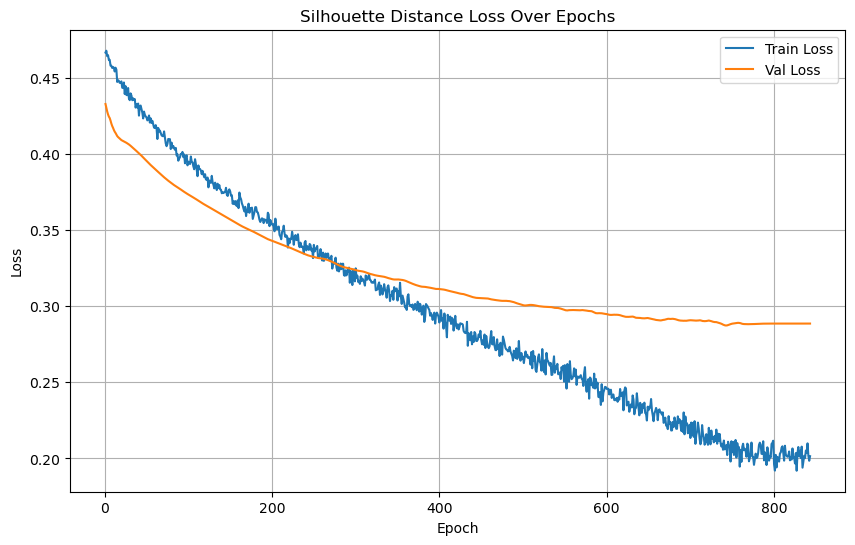

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/665], Loss: 0.2226
Test Batch [20/665], Loss: 0.1741
Test Batch [30/665], Loss: 0.3531
Test Batch [40/665], Loss: 0.3509


Test Batch [50/665], Loss: 0.5020
Test Batch [60/665], Loss: 0.3744
Test Batch [70/665], Loss: 0.2973
Test Batch [80/665], Loss: 0.2953
Test Batch [90/665], Loss: 0.2428


Test Batch [100/665], Loss: 0.1995
Test Batch [110/665], Loss: 0.5000
Test Batch [120/665], Loss: 0.2617
Test Batch [130/665], Loss: 0.1797
Test Batch [140/665], Loss: 0.1861


Test Batch [150/665], Loss: 0.5000
Test Batch [160/665], Loss: 0.2397
Test Batch [170/665], Loss: 0.2566
Test Batch [180/665], Loss: 0.5000
Test Batch [190/665], Loss: 0.2383
Test Batch [200/665], Loss: 0.2995
Test Batch [210/665], Loss: 0.5000


Test Batch [220/665], Loss: 0.2579
Test Batch [230/665], Loss: 0.2329
Test Batch [240/665], Loss: 0.5000
Test Batch [250/665], Loss: 0.5000
Test Batch [260/665], Loss: 0.5000
Test Batch [270/665], Loss: 0.5000
Test Batch [280/665], Loss: 0.5000
Test Batch [290/665], Loss: 0.5000
Test Batch [300/665], Loss: 0.5000
Test Batch [310/665], Loss: 0.1623


Test Batch [320/665], Loss: 0.2027
Test Batch [330/665], Loss: 0.1832
Test Batch [340/665], Loss: 0.1740


Test Batch [350/665], Loss: 0.1425
Test Batch [360/665], Loss: 0.2137
Test Batch [370/665], Loss: 0.1211


Test Batch [380/665], Loss: 0.1701
Test Batch [390/665], Loss: 0.1047
Test Batch [400/665], Loss: 0.0775


Test Batch [410/665], Loss: 0.1443
Test Batch [420/665], Loss: 0.1318
Test Batch [430/665], Loss: 0.2094


Test Batch [440/665], Loss: 0.3350
Test Batch [450/665], Loss: 0.3287
Test Batch [460/665], Loss: 0.3740


Test Batch [470/665], Loss: 0.2725
Test Batch [480/665], Loss: 0.3074
Test Batch [490/665], Loss: 0.1995
Test Batch [500/665], Loss: 0.3456


Test Batch [510/665], Loss: 0.2135
Test Batch [520/665], Loss: 0.2352
Test Batch [530/665], Loss: 0.2451
Test Batch [540/665], Loss: 0.2431


Test Batch [550/665], Loss: 0.5000
Test Batch [560/665], Loss: 0.2510
Test Batch [570/665], Loss: 0.2619


Test Batch [580/665], Loss: 0.1930
Test Batch [590/665], Loss: 0.2143
Test Batch [600/665], Loss: 0.3609
Test Batch [610/665], Loss: 0.2142


Test Batch [620/665], Loss: 0.4484
Test Batch [630/665], Loss: 0.2606
Test Batch [640/665], Loss: 0.2113
Test Batch [650/665], Loss: 0.4416


Test Batch [660/665], Loss: 0.3945

Test Loss: 0.2921


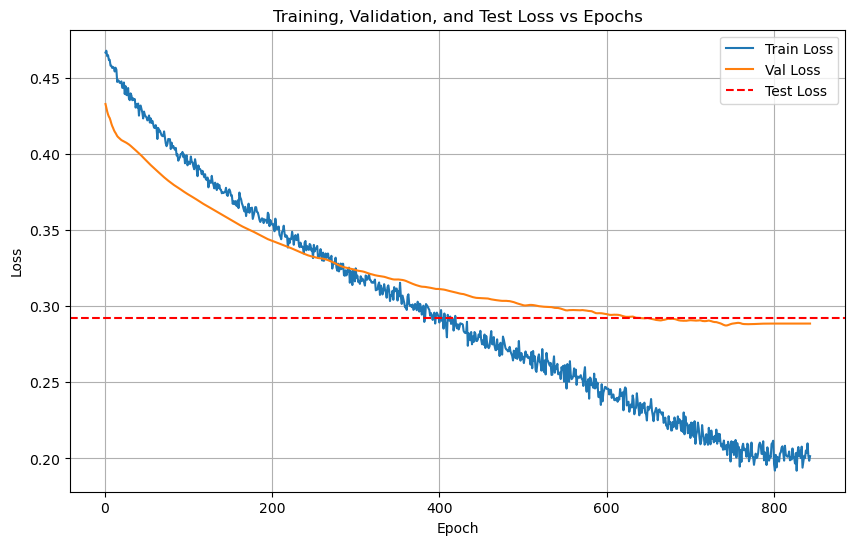

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/665 for test dataset.


  Processed batch 20/665 for test dataset.
  Processed batch 30/665 for test dataset.
  Processed batch 40/665 for test dataset.
  Processed batch 50/665 for test dataset.


  Processed batch 60/665 for test dataset.
  Processed batch 70/665 for test dataset.
  Processed batch 80/665 for test dataset.


  Processed batch 90/665 for test dataset.
  Processed batch 100/665 for test dataset.
  Processed batch 110/665 for test dataset.
  Processed batch 120/665 for test dataset.


  Processed batch 130/665 for test dataset.
  Processed batch 140/665 for test dataset.
  Processed batch 150/665 for test dataset.


  Processed batch 160/665 for test dataset.
  Processed batch 170/665 for test dataset.
  Processed batch 180/665 for test dataset.


  Processed batch 190/665 for test dataset.
  Processed batch 200/665 for test dataset.


  Processed batch 210/665 for test dataset.
  Processed batch 220/665 for test dataset.
  Processed batch 230/665 for test dataset.
  Processed batch 240/665 for test dataset.


  Processed batch 250/665 for test dataset.
  Processed batch 260/665 for test dataset.
  Processed batch 270/665 for test dataset.


  Processed batch 280/665 for test dataset.
  Processed batch 290/665 for test dataset.
  Processed batch 300/665 for test dataset.
  Processed batch 310/665 for test dataset.


  Processed batch 320/665 for test dataset.
  Processed batch 330/665 for test dataset.
  Processed batch 340/665 for test dataset.


  Processed batch 350/665 for test dataset.
  Processed batch 360/665 for test dataset.
  Processed batch 370/665 for test dataset.


  Processed batch 380/665 for test dataset.
  Processed batch 390/665 for test dataset.
  Processed batch 400/665 for test dataset.
  Processed batch 410/665 for test dataset.


  Processed batch 420/665 for test dataset.
  Processed batch 430/665 for test dataset.
  Processed batch 440/665 for test dataset.


  Processed batch 450/665 for test dataset.
  Processed batch 460/665 for test dataset.
  Processed batch 470/665 for test dataset.


  Processed batch 480/665 for test dataset.
  Processed batch 490/665 for test dataset.
  Processed batch 500/665 for test dataset.
  Processed batch 510/665 for test dataset.


  Processed batch 520/665 for test dataset.
  Processed batch 530/665 for test dataset.
  Processed batch 540/665 for test dataset.
  Processed batch 550/665 for test dataset.


  Processed batch 560/665 for test dataset.
  Processed batch 570/665 for test dataset.
  Processed batch 580/665 for test dataset.
  Processed batch 590/665 for test dataset.


  Processed batch 600/665 for test dataset.
  Processed batch 610/665 for test dataset.
  Processed batch 620/665 for test dataset.


  Processed batch 630/665 for test dataset.
  Processed batch 640/665 for test dataset.
  Processed batch 650/665 for test dataset.


  Processed batch 660/665 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       0.67      0.40      0.50         5
           2       0.71      1.00      0.83         5
           3       0.80      0.80      0.80         5
           4       1.00      1.00      1.00         5
           5       0.75      0.60      0.67         5
           6       0.80      0.80      0.80         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.80        45
   macro avg       0.80      0.80      0.79        45
weighted avg       0.80      0.80      0.79        45


LOG: Evaluating on the test set...
Test Accuracy: 72.62%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (180, 128)
Train labels shape: (180,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42551, 128)
Test labels shape: (42551,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1139  |  Val Loss: 2.0816
Validation loss improved from inf to 2.0816.
[Epoch 2/1000] Train Loss: 2.0614  |  Val Loss: 2.0310
Validation loss improved from 2.0816 to 2.0310.
[Epoch 3/1000] Train Loss: 2.0136  |  Val Loss: 1.9857
Validation loss improved from 2.0310 to 1.9857.
[Epoch 4/1000] Train Loss: 1.9712  |  Val Loss: 1.9443
Validation loss improved from 1.9857 to 1.9443.
[Epoch 5/1000] Train Loss: 1.9282  |  Val Loss: 1.9080
Validation loss improved from 1.9443 to 1.9080.
[Epoch 6/1000] Train Loss: 1.8934  |  Val Loss: 1.8757
Validation loss improved from 1.9080 to 1.8757.
[Epoch 7/1000] Train Loss: 1.8616  |  Val Loss: 1.8484
Validation loss improved from 1.8757 to 1.8484.
[Epoch 8/1000] Train Loss: 1.8311  |  Val Loss: 1.8233
Validation loss improved from 1.8484 to 1.8233.
[Epoch 9/1000] Train Loss: 1.8049  |  Val Loss: 1.7998
Validation loss improved from 1.8233 to 1.7998.
[Epoch 10/1000] Train Loss: 1.7798  |  Val Loss: 1.7784
Validation loss impr

[Epoch 27/1000] Train Loss: 1.4787  |  Val Loss: 1.5215
Validation loss improved from 1.5337 to 1.5215.
[Epoch 28/1000] Train Loss: 1.4636  |  Val Loss: 1.5098
Validation loss improved from 1.5215 to 1.5098.
[Epoch 29/1000] Train Loss: 1.4496  |  Val Loss: 1.4986
Validation loss improved from 1.5098 to 1.4986.
[Epoch 30/1000] Train Loss: 1.4358  |  Val Loss: 1.4874
Validation loss improved from 1.4986 to 1.4874.
[Epoch 31/1000] Train Loss: 1.4223  |  Val Loss: 1.4765
Validation loss improved from 1.4874 to 1.4765.
[Epoch 32/1000] Train Loss: 1.4085  |  Val Loss: 1.4661
Validation loss improved from 1.4765 to 1.4661.
[Epoch 33/1000] Train Loss: 1.3954  |  Val Loss: 1.4556
Validation loss improved from 1.4661 to 1.4556.
[Epoch 34/1000] Train Loss: 1.3826  |  Val Loss: 1.4453
Validation loss improved from 1.4556 to 1.4453.
[Epoch 35/1000] Train Loss: 1.3695  |  Val Loss: 1.4351
Validation loss improved from 1.4453 to 1.4351.
[Epoch 36/1000] Train Loss: 1.3572  |  Val Loss: 1.4249
Validati

[Epoch 60/1000] Train Loss: 1.0764  |  Val Loss: 1.1940
Validation loss improved from 1.2030 to 1.1940.
[Epoch 61/1000] Train Loss: 1.0648  |  Val Loss: 1.1851
Validation loss improved from 1.1940 to 1.1851.
[Epoch 62/1000] Train Loss: 1.0531  |  Val Loss: 1.1760
Validation loss improved from 1.1851 to 1.1760.
[Epoch 63/1000] Train Loss: 1.0416  |  Val Loss: 1.1670
Validation loss improved from 1.1760 to 1.1670.
[Epoch 64/1000] Train Loss: 1.0296  |  Val Loss: 1.1579
Validation loss improved from 1.1670 to 1.1579.
[Epoch 65/1000] Train Loss: 1.0176  |  Val Loss: 1.1487
Validation loss improved from 1.1579 to 1.1487.
[Epoch 66/1000] Train Loss: 1.0057  |  Val Loss: 1.1395
Validation loss improved from 1.1487 to 1.1395.
[Epoch 67/1000] Train Loss: 0.9937  |  Val Loss: 1.1301
Validation loss improved from 1.1395 to 1.1301.
[Epoch 68/1000] Train Loss: 0.9819  |  Val Loss: 1.1207
Validation loss improved from 1.1301 to 1.1207.
[Epoch 69/1000] Train Loss: 0.9702  |  Val Loss: 1.1113
Validati

[Epoch 91/1000] Train Loss: 0.7131  |  Val Loss: 0.9320
Validation loss improved from 0.9394 to 0.9320.
[Epoch 92/1000] Train Loss: 0.7021  |  Val Loss: 0.9249
Validation loss improved from 0.9320 to 0.9249.
[Epoch 93/1000] Train Loss: 0.6911  |  Val Loss: 0.9180
Validation loss improved from 0.9249 to 0.9180.
[Epoch 94/1000] Train Loss: 0.6807  |  Val Loss: 0.9111
Validation loss improved from 0.9180 to 0.9111.
[Epoch 95/1000] Train Loss: 0.6700  |  Val Loss: 0.9044
Validation loss improved from 0.9111 to 0.9044.
[Epoch 96/1000] Train Loss: 0.6592  |  Val Loss: 0.8978
Validation loss improved from 0.9044 to 0.8978.
[Epoch 97/1000] Train Loss: 0.6490  |  Val Loss: 0.8909
Validation loss improved from 0.8978 to 0.8909.
[Epoch 98/1000] Train Loss: 0.6381  |  Val Loss: 0.8844
Validation loss improved from 0.8909 to 0.8844.
[Epoch 99/1000] Train Loss: 0.6282  |  Val Loss: 0.8777
Validation loss improved from 0.8844 to 0.8777.
[Epoch 100/1000] Train Loss: 0.6180  |  Val Loss: 0.8712
Validat

[Epoch 124/1000] Train Loss: 0.4160  |  Val Loss: 0.7533
Validation loss improved from 0.7568 to 0.7533.
[Epoch 125/1000] Train Loss: 0.4093  |  Val Loss: 0.7501
Validation loss improved from 0.7533 to 0.7501.
[Epoch 126/1000] Train Loss: 0.4026  |  Val Loss: 0.7472
Validation loss improved from 0.7501 to 0.7472.
[Epoch 127/1000] Train Loss: 0.3963  |  Val Loss: 0.7439
Validation loss improved from 0.7472 to 0.7439.
[Epoch 128/1000] Train Loss: 0.3899  |  Val Loss: 0.7410
Validation loss improved from 0.7439 to 0.7410.
[Epoch 129/1000] Train Loss: 0.3837  |  Val Loss: 0.7381
Validation loss improved from 0.7410 to 0.7381.
[Epoch 130/1000] Train Loss: 0.3775  |  Val Loss: 0.7351
Validation loss improved from 0.7381 to 0.7351.
[Epoch 131/1000] Train Loss: 0.3713  |  Val Loss: 0.7323
Validation loss improved from 0.7351 to 0.7323.
[Epoch 132/1000] Train Loss: 0.3655  |  Val Loss: 0.7296
Validation loss improved from 0.7323 to 0.7296.
[Epoch 133/1000] Train Loss: 0.3596  |  Val Loss: 0.726

[Epoch 154/1000] Train Loss: 0.2571  |  Val Loss: 0.6857
Validation loss improved from 0.6865 to 0.6857.
[Epoch 155/1000] Train Loss: 0.2533  |  Val Loss: 0.6845
Validation loss improved from 0.6857 to 0.6845.
[Epoch 156/1000] Train Loss: 0.2497  |  Val Loss: 0.6835
Validation loss improved from 0.6845 to 0.6835.
[Epoch 157/1000] Train Loss: 0.2459  |  Val Loss: 0.6824
Validation loss improved from 0.6835 to 0.6824.
[Epoch 158/1000] Train Loss: 0.2425  |  Val Loss: 0.6816
Validation loss improved from 0.6824 to 0.6816.
[Epoch 159/1000] Train Loss: 0.2390  |  Val Loss: 0.6813
Validation loss improved from 0.6816 to 0.6813.
[Epoch 160/1000] Train Loss: 0.2356  |  Val Loss: 0.6808
Validation loss improved from 0.6813 to 0.6808.
[Epoch 161/1000] Train Loss: 0.2321  |  Val Loss: 0.6802
Validation loss improved from 0.6808 to 0.6802.
[Epoch 162/1000] Train Loss: 0.2289  |  Val Loss: 0.6791
Validation loss improved from 0.6802 to 0.6791.
[Epoch 163/1000] Train Loss: 0.2254  |  Val Loss: 0.678

[Epoch 188/1000] Train Loss: 0.1617  |  Val Loss: 0.6782
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 189/1000] Train Loss: 0.1599  |  Val Loss: 0.6786
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 190/1000] Train Loss: 0.1578  |  Val Loss: 0.6791
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 191/1000] Train Loss: 0.1560  |  Val Loss: 0.6797
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 192/1000] Train Loss: 0.1543  |  Val Loss: 0.6806
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 193/1000] Train Loss: 0.1524  |  Val Loss: 0.6809
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 194/1000] Train Loss: 0.1509  |  Val Loss: 0.6819
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 195/1000] Train Loss: 0.1491  |  Val Loss: 0.6828
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 196/1000] Train Loss: 0.1474  |  Val Loss: 0.6833
!! Validation loss did NOT improve !! Patience:

[Epoch 218/1000] Train Loss: 0.1178  |  Val Loss: 0.7010
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 219/1000] Train Loss: 0.1167  |  Val Loss: 0.7014
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 220/1000] Train Loss: 0.1157  |  Val Loss: 0.7023
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 221/1000] Train Loss: 0.1147  |  Val Loss: 0.7031
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 222/1000] Train Loss: 0.1136  |  Val Loss: 0.7039
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 223/1000] Train Loss: 0.1125  |  Val Loss: 0.7049
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 224/1000] Train Loss: 0.1115  |  Val Loss: 0.7056
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 225/1000] Train Loss: 0.1106  |  Val Loss: 0.7062
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 226/1000] Train Loss: 0.1097  |  Val Loss: 0.7075
!! Validation loss did NOT improve !! Patience:

[Epoch 250/1000] Train Loss: 0.0907  |  Val Loss: 0.7266
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 251/1000] Train Loss: 0.0900  |  Val Loss: 0.7277
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 252/1000] Train Loss: 0.0894  |  Val Loss: 0.7283
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 253/1000] Train Loss: 0.0887  |  Val Loss: 0.7292
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 254/1000] Train Loss: 0.0882  |  Val Loss: 0.7303
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 255/1000] Train Loss: 0.0876  |  Val Loss: 0.7309
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 256/1000] Train Loss: 0.0869  |  Val Loss: 0.7317
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 257/1000] Train Loss: 0.0863  |  Val Loss: 0.7327
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 258/1000] Train Loss: 0.0858  |  Val Loss: 0.7338
!! Validation loss did NOT improve !! Patience:

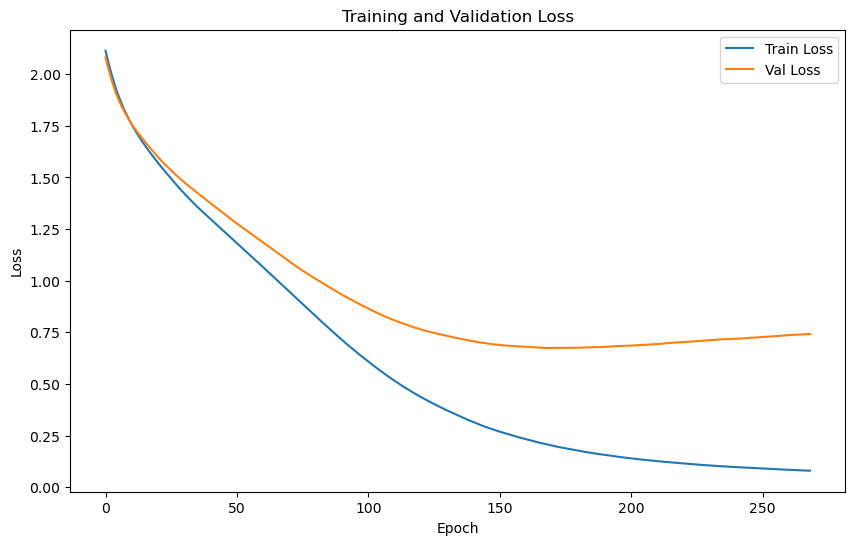

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.9811 | Test Accuracy: 72.94%


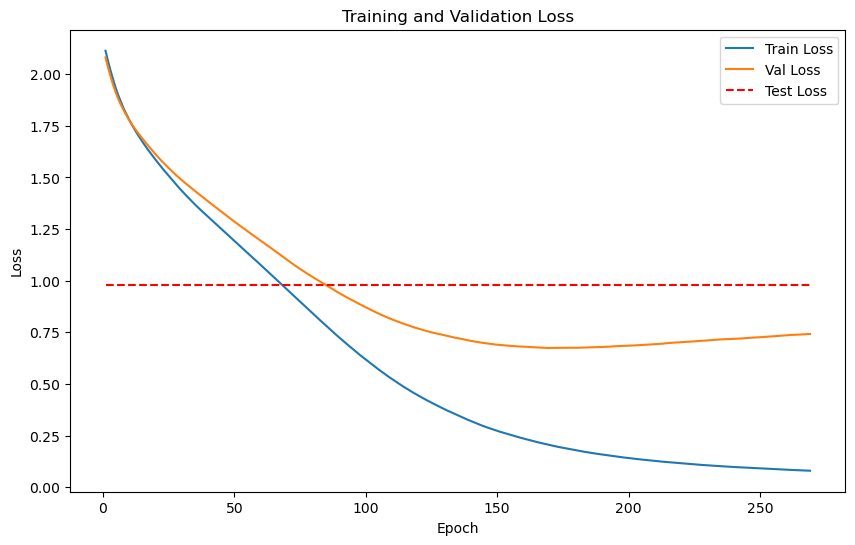

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


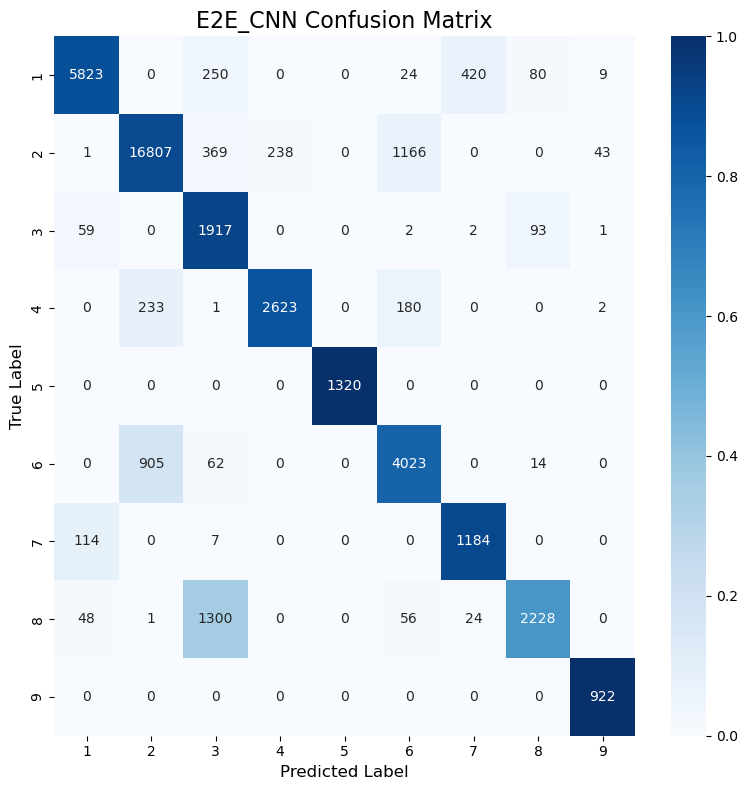

Classification Accuracy: 86.59%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


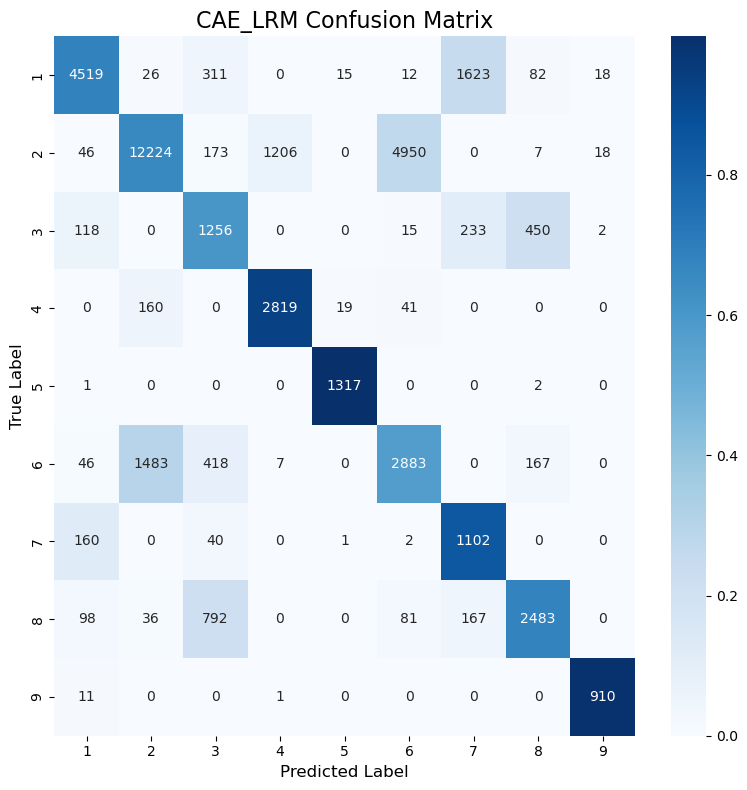

Classification Accuracy: 69.36%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


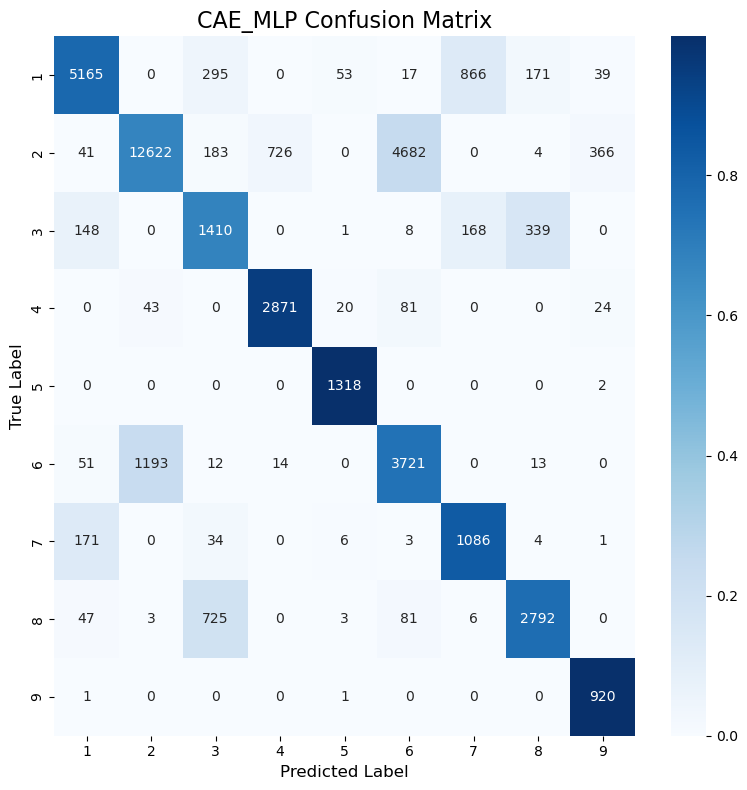

Classification Accuracy: 74.98%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


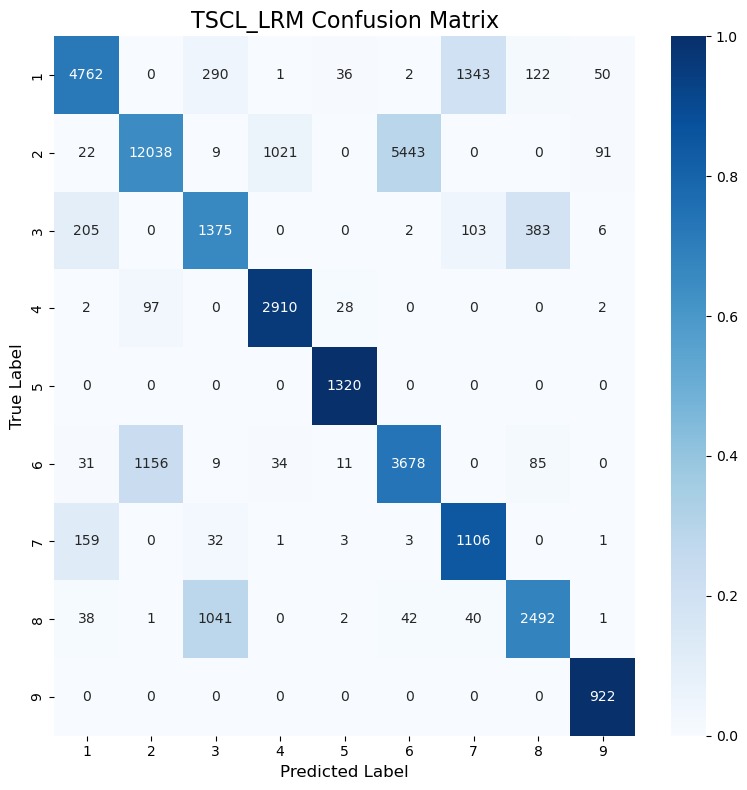

Classification Accuracy: 71.92%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


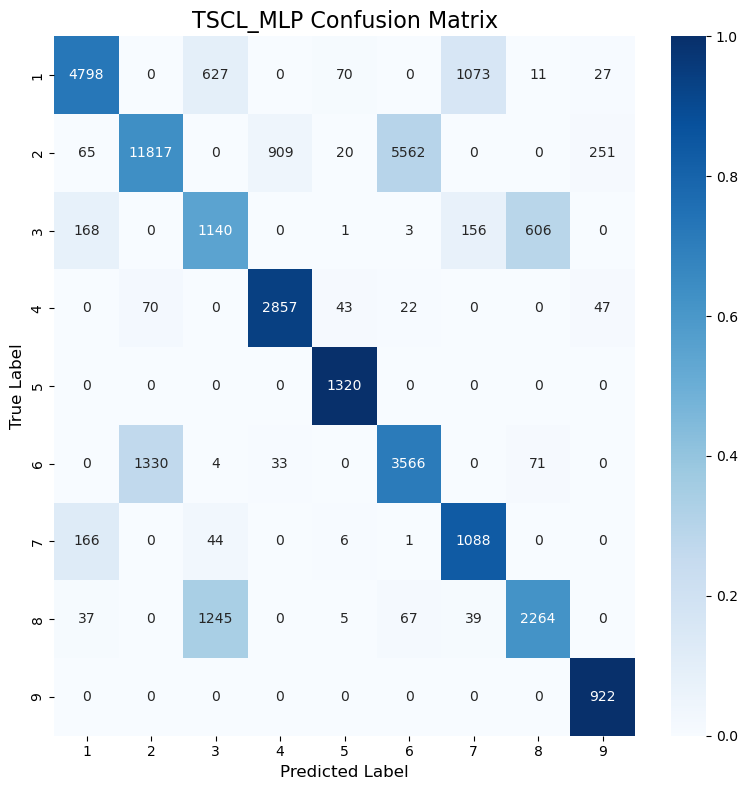

Classification Accuracy: 69.97%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


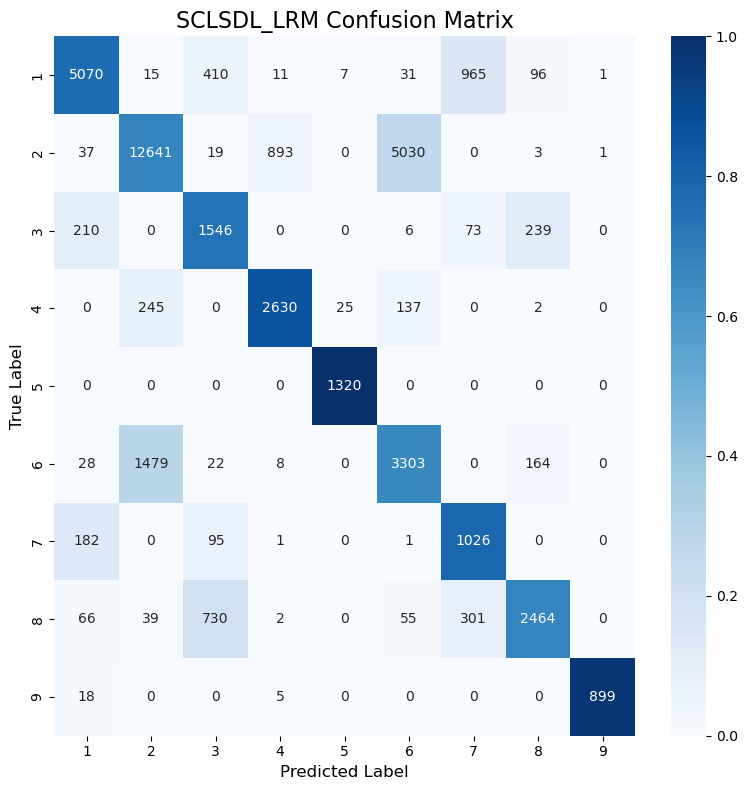

Classification Accuracy: 72.62%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


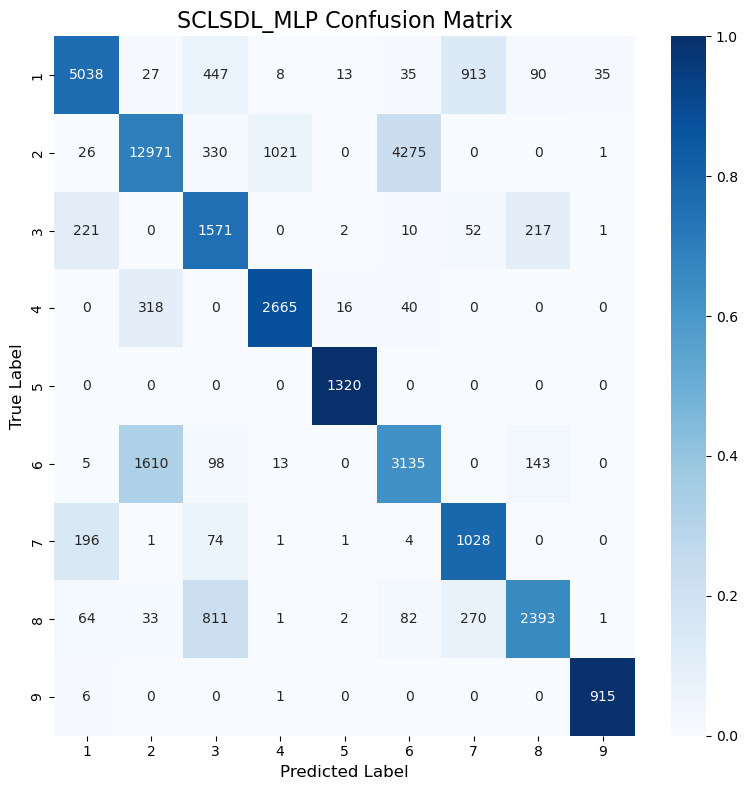

Classification Accuracy: 72.94%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          86.59
1    LRM (CAE)          69.36
2    MLP (CAE)          74.98
3     TSCL LRM          71.92
4     TSCL MLP          69.97
5  SCL_SDL LRM          72.62
6  SCL_SDL MLP          72.94

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          86.59
2    MLP (CAE)          74.98
6  SCL_SDL MLP          72.94
5  SCL_SDL LRM          72.62
3     TSCL LRM          71.92
4     TSCL MLP          69.97
1    LRM (CAE)          69.36
